In [1]:
import urllib, os
import urllib.request as urllib2
from bs4 import BeautifulSoup
import pandas as pd
from lxml import html
import xml.etree.ElementTree as ET
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from regressors import stats 
# %config InlineBackend.figure_format = 'png'

## 1. Data Collection

### 1.1 Get Form-4 Websites for ticker

In [2]:
# get a list of Form-4 websites for ticker
def get_list(ticker):

    base_url_part1 = "http://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK="
    base_url_part2 = "&type=&dateb=&owner=&start="
    base_url_part3 = "&count=100&output=xml"
    href = []
    
    # each page have 0~99 records, page one: start=0, page two: start=100,page three: start=200,...
    for page_number in range(0,2000,100):
    
        base_url = base_url_part1 + ticker + base_url_part2 + str(page_number) + base_url_part3
        
        sec_page = urllib2.urlopen(base_url)
        sec_soup = BeautifulSoup(sec_page,'lxml')
        
        # select element "filing"
        filings = sec_soup.findAll('filing')
        
        for filing in filings:
            report_year = int(filing.datefiled.get_text()[0:4]) 
            # select element "datefiled", first four characters represent year, e.g. "2019-08-01"
            
            if (filing.type.get_text() == "4") & (report_year > 2008): # "type" element represent filetype, we want to get Form 4
                print (filing.filinghref.get_text())  # filinghref contains the link for Form 4
                href.append(filing.filinghref.get_text())
    
    return href

### 1.2 Get Insider Information from the website

In [3]:
# get the insider information, transaction information, filing number and date
def get_data(url,n):
    page = urllib2.urlopen(url) # open the Form 4 link
    sec_soup = BeautifulSoup(page,'lxml')
    for link in sec_soup.find_all(href=re.compile("xml"),string=re.compile("xml")): # find the link for xml file, select from "html" file and "xml" file
        href_file = link.get('href') # get the xml file link
    xml_doc = "https://www.sec.gov"+ href_file # add the "xml" file link
    form = urllib2.urlopen(xml_doc)
    form4 = form.read()
    root = ET.fromstring(form4)
    
    # iterate through all "nonDerivativeTransaction" element, some files might contain several transaction records
    for transaction in root.iter('nonDerivativeTransaction'):
        # File Number:
        file_number.append(n)
        # Insider name
        name = root.find(".//rptOwnerName").text
        insider_name.append(name) 
        
        # Insider Title
        relation_list = []
        relation_whole = []
        relationship = root.find(".//reportingOwnerRelationship")
        
        # the position part has four elements in most cases(and one element sometimes), the text would be 1 if selected and 0 if not.
        for relation in relationship:
            if relation.text=='1':
                relation_list.append(relation.tag[2:]) # format is "isDirector", so we only select from character 3
        
        # we put the text of relation with "tag==1" and also the text if it is not 1,0 and None
        relation_whole = '+ '.join(relation_list) # join the element in list with the symobol ":", e.g. Officer: COO
        insider_title.append(relation_whole)  
        
        # Transaction Date      
        date = transaction.find('.//transactionDate/value').text
        transaction_date.append(date)
        # Transaction Code for the transaction
        code = transaction.find('.//transactionCode').text
        transaction_code.append(code)
        # Number of securities purchased or sold
        shares = transaction.find('.//transactionShares/value').text
        transaction_shares.append(shares)
        
        # Price of Securities Sold
        # sometimes we will get Nonetype value, so we just ignore and set "NA" to the price in that case
        try:
            price = transaction.find('.//transactionPricePerShare/value').text
            transaction_price.append(price)
        except:
            price = 'NA'
            transaction_price.append(price)
            
        # Buy or Sell
        buysell = transaction.find('.//transactionAcquiredDisposedCode/value').text
        buy_sell.append(buysell)   
        # Filing Date
        filing = root.find(".//signatureDate").text
        filing_date.append(filing)
                

### 1.3 Create Insider Activity DataFrame

In [4]:
# Define the function to get the dataframe
def variable_dataframe(ticker):
    url_list= get_list(ticker) # get a list of htm link for Form-4
    
    # get a list of insider information
    for i in range(0,len(url_list)):
        get_data(url_list[i],i+1)
        # get the insider activity information
        print("Finish File: ",i+1) # show the current progress of completion

    # create the insider activity dataframe
    df = {'File Number':file_number,'Insider Name':insider_name,'Insider Title':insider_title,'Transaction Date':transaction_date,
          'Transaction Code':transaction_code,'Transaction Shares':transaction_shares,'Transaction Price':transaction_price,
          'Acquired/Disposed(A/D)':buy_sell,'Filing Date':filing_date}
    Insider_Activity = pd.DataFrame(df)
    return Insider_Activity # DataFrame for Insider_Acitivity

In [5]:
ticker_list = ['AAPL','ATVI','ABT','BIIB','EA','TTWO']

In [6]:
Insider = {}
for ticker in ticker_list:
    # initialize the list, data would append to the list after each iterative loop
    file_number = []
    insider_name = []
    insider_title = []
    transaction_date = []
    transaction_code = []
    transaction_shares = []
    transaction_price = []
    buy_sell = []
    filing_date = []
    # insider activity dataframe
    Insider[ticker] = variable_dataframe(ticker)

https://www.sec.gov/Archives/edgar/data/320193/000032019319000090/0000320193-19-000090-index.htm
https://www.sec.gov/Archives/edgar/data/320193/000032019319000088/0000320193-19-000088-index.htm
https://www.sec.gov/Archives/edgar/data/320193/000032019319000086/0000320193-19-000086-index.htm
https://www.sec.gov/Archives/edgar/data/320193/000032019319000082/0000320193-19-000082-index.htm
https://www.sec.gov/Archives/edgar/data/320193/000032019319000081/0000320193-19-000081-index.htm
https://www.sec.gov/Archives/edgar/data/320193/000032019319000080/0000320193-19-000080-index.htm
https://www.sec.gov/Archives/edgar/data/320193/000032019319000070/0000320193-19-000070-index.htm
https://www.sec.gov/Archives/edgar/data/320193/000032019319000069/0000320193-19-000069-index.htm
https://www.sec.gov/Archives/edgar/data/320193/000032019319000060/0000320193-19-000060-index.htm
https://www.sec.gov/Archives/edgar/data/320193/000032019319000059/0000320193-19-000059-index.htm
https://www.sec.gov/Archives/e

In [7]:
for ticker in ticker_list:
    Insider[ticker]

File Number        Insider Name      Insider Title Transaction Date  \
0               1      COOK TIMOTHY D  Director+ Officer       2019-08-24   
1               1      COOK TIMOTHY D  Director+ Officer       2019-08-24   
2               1      COOK TIMOTHY D  Director+ Officer       2019-08-26   
3               1      COOK TIMOTHY D  Director+ Officer       2019-08-26   
4               1      COOK TIMOTHY D  Director+ Officer       2019-08-26   
5               2      COOK TIMOTHY D  Director+ Officer       2019-08-22   
6               3   LEVINSON ARTHUR D           Director       2019-08-12   
7               3   LEVINSON ARTHUR D           Director       2019-08-12   
8               4        BELL JAMES A           Director       2019-08-02   
9               5   LEVINSON ARTHUR D           Director       2019-08-01   
10              5   LEVINSON ARTHUR D           Director       2019-08-01   
11              6         KONDO CHRIS            Officer       2019-08-01   
12              7   LEVINSON ARTHUR D           Director       2019-05-03   
13              7   LEVINSON ARTHUR D           Director       2019-05-03   
14              8  WILLIAMS JEFFREY E            Officer       2019-05-02   
15              8  WILLIAMS JEFFREY E            Officer       2019-05-02   
16              8  WILLIAMS JEFFREY E            Officer       2019-05-02   
17              8  WILLIAMS JEFFREY E            Officer       2019-05-02   
18              8  WILLIAMS JEFFREY E            Officer       2019-05-02   
19              9     O'BRIEN DEIRDRE            Officer       2019-04-15   
20              9     O'BRIEN DEIRDRE            Officer       2019-04-15   
21             10         KONDO CHRIS            Officer       2019-02-19   
22             10         KONDO CHRIS            Officer       2019-04-15   
23             10         KONDO CHRIS            Officer       2019-04-15   
24             11        Maestri Luca            Officer       2019-04-05   
25             12  WILLIAMS JEFFREY E            Officer       2019-04-01   
26             12  WILLIAMS JEFFREY E            Officer       2019-04-01   
27             13        Maestri Luca            Officer       2019-04-01   
28             13        Maestri Luca            Officer       2019-04-01   
29             22        WAGNER SUSAN           Director       2019-02-01   
...           ...                 ...                ...              ...   
1372          685    Forstall Scott J            Officer       2009-07-24   
1373          685    Forstall Scott J            Officer       2009-07-24   
1374          685    Forstall Scott J            Officer       2009-07-24   
1375          685    Forstall Scott J            Officer       2009-07-24   
1376          685    Forstall Scott J            Officer       2009-07-24   
1377          686     SERLET BERTRAND            Officer       2009-07-17   
1378          686     SERLET BERTRAND            Officer       2009-07-08   
1379          687    Forstall Scott J            Officer       2009-07-19   
1380          687    Forstall Scott J            Officer       2009-07-19   
1381          688    JOHNSON RONALD B            Officer       2009-06-26   
1382          689       TAMADDON SINA            Officer       2009-06-26   
1383          690     SERLET BERTRAND            Officer       2009-06-26   
1384          691        RAFAEL BETSY            Officer       2009-06-26   
1385          692   OPPENHEIMER PETER            Officer       2009-06-26   
1386          693  MANSFIELD ROBERT J            Officer       2009-06-26   
1387          694      IVE JONATHAN P            Officer       2009-06-26   
1388          695    Forstall Scott J            Officer       2009-06-26   
1389          696    COOPERMAN DANIEL            Officer       2009-06-26   
1390          697      COOK TIMOTHY D            Officer       2009-06-26   
1391          698      IVE JONATHAN P            Officer       2009-06-18   
13

File Number           Insider Name      Insider Title Transaction Date  \
0               1  Walther Christopher B            Officer       2019-09-03   
1               2         Stolz Brian M.              Other       2019-08-13   
2               2         Stolz Brian M.              Other       2019-08-13   
3               3        Wereb Stephen G              Other       2019-08-13   
4               3        Wereb Stephen G              Other       2019-08-13   
5               3        Wereb Stephen G              Other       2019-08-13   
6               3        Wereb Stephen G              Other       2019-08-13   
7               3        Wereb Stephen G              Other       2019-08-13   
8               4      Johnson Collister            Officer       2019-08-12   
9               5        KOTICK ROBERT A  Director+ Officer       2019-08-12   
10              5        KOTICK ROBERT A  Director+ Officer       2019-08-12   
11              6  Walther Christopher B            Officer       2019-08-01   
12              7  Walther Christopher B            Officer       2019-07-01   
13              8      Johnson Collister            Officer       2019-06-29   
14              9        Wereb Stephen G            Officer       2019-06-29   
15             10        BOWERS REVETA F           Director       2019-06-25   
16             11         CORTI ROBERT J           Director       2019-06-25   
17             12    Hartong Hendrik III           Director       2019-06-25   
18             13          KELLY BRIAN G           Director       2019-06-25   
19             14            Meyer Barry           Director       2019-06-25   
20             15       MORGADO ROBERT J           Director       2019-06-25   
21             16          NOLAN PETER J           Director       2019-06-25   
22             17        Wasserman Casey           Director       2019-06-25   
23             18          WYNN ELAINE P           Director       2019-06-25   
24             19  Walther Christopher B            Officer       2019-06-05   
25             20         Stolz Brian M.            Officer       2019-05-30   
26             21  Walther Christopher B            Officer       2019-05-15   
27             22  Walther Christopher B            Officer       2019-05-06   
28             23        Wereb Stephen G            Officer       2019-05-06   
29             24        KOTICK ROBERT A  Director+ Officer       2019-03-31   
...           ...                    ...                ...              ...   
1021          454           Tippl Thomas            Officer       2009-05-11   
1022          454           Tippl Thomas            Officer       2009-05-11   
1023          454           Tippl Thomas            Officer       2009-05-11   
1024          454           Tippl Thomas            Officer       2009-05-11   
1025          455          ROSE GEORGE L            Officer       2009-05-11   
1026          456           Hodous Brian            Officer       2009-05-11   
1027          457        DOORNINK RONALD              Other       2009-05-11   
1028          457        DOORNINK RONALD              Other       2009-05-11   
1029          458        DOORNINK RONALD              Other       2009-04-11   
1030          459        DOORNINK RONALD              Other       2009-02-20   
1031          459        DOORNINK RONALD              Other       2009-02-23   
1032          459        DOORNINK RONALD              Other       2009-02-24   
1033          459        DOORNINK RONALD              Other       2009-02-25   
1034          459        DOORNINK RONALD              Other       2009-03-13   
1035          460          KELLY BRIAN G           Director       2009-03-09   
1036          460          KELLY BRIAN G           Director       2009-03-10   
1037          461        KOTICK ROBERT A  Director+ Officer       2009-03-09   
1038          461        KOTICK ROBERT A  Director+ Officer       2009-03-09   
1039  

File Number                 Insider Name      Insider Title  \
0               1             MANNING JOSEPH J            Officer   
1               1             MANNING JOSEPH J            Officer   
2               2           PEDERSON MICHAEL J            Officer   
3               2           PEDERSON MICHAEL J            Officer   
4               2           PEDERSON MICHAEL J            Officer   
5               3               Funck Robert E            Officer   
6               3               Funck Robert E            Officer   
7               4                 YOOR BRIAN B            Officer   
8               4                 YOOR BRIAN B            Officer   
9               4                 YOOR BRIAN B            Officer   
10              5              Moreland Mary K            Officer   
11              6              Blount Sally E.           Director   
12              7                   BIRD ROGER            Officer   
13              8     WOODGRIFT RANDEL WILLIAM            Officer   
14              8     WOODGRIFT RANDEL WILLIAM            Officer   
15              9            BRYNELSEN CHARLES            Officer   
16             10           PEDERSON MICHAEL J            Officer   
17             11  Salvadori Daniel Gesua Sive            Officer   
18             12         Wellisch Alejandro D            Officer   
19             12         Wellisch Alejandro D            Officer   
20             15  Salvadori Daniel Gesua Sive            Officer   
21             15  Salvadori Daniel Gesua Sive            Officer   
22             16              Wainer Andrea F            Officer   
23             17                 CAPEK JOHN M            Officer   
24             17                 CAPEK JOHN M            Officer   
25             18               ALLEN HUBERT L            Officer   
26             18               ALLEN HUBERT L            Officer   
27             19                LANE ANDREW H            Officer   
28             19                LANE ANDREW H            Officer   
29             20  Salvadori Daniel Gesua Sive            Officer   
...           ...                          ...                ...   
4472         1263                WHITE MILES D  Director+ Officer   
4473         1263                WHITE MILES D  Director+ Officer   
4474         1263                WHITE MILES D  Director+ Officer   
4475         1263                WHITE MILES D  Director+ Officer   
4476         1263                WHITE MILES D  Director+ Officer   
4477         1264              Mason Heather L            Officer   
4478         1264              Mason Heather L            Officer   
4479         1264              Mason Heather L            Officer   
4480         1264              Mason Heather L            Officer   
4481         1264              Mason Heather L            Officer   
4482         1265                Chen Thomas F            Officer   
4483         1265                Chen Thomas F            Officer   
4484         1265                Chen Thomas F            Officer   
4485         1265                Chen Thomas F            Officer   
4486         1265                Chen Thomas F            Officer   
4487         1265                Chen Thomas F            Officer   
4488         1265                Chen Thomas F            Officer   
4489         1265                Chen Thomas F            Officer   
4490         1266            Warmuth Michael J            Officer   
4491         1266            Warmuth Michael J            Officer   
4492         1266            Warmuth Michael J            Officer   
4493         1266            Warmuth Michael J            Officer   
4494         1266            Warmuth Michael J            Officer   
4495         1266            Warmuth Michael J            Officer   
4496         1266            Warmuth Michael J            Officer   
4497         1267          SMITHBURG WILLIAM D           Director   
4498

File Number          Insider Name      Insider Title Transaction Date  \
0               1        Gregory Ginger            Officer       2019-08-01   
1               1        Gregory Ginger            Officer       2019-08-01   
2               1        Gregory Ginger            Officer       2019-08-01   
3               2           Karp Daniel            Officer       2019-07-02   
4               2           Karp Daniel            Officer       2019-07-02   
5               3        Mantas Jesus B           Director       2019-06-19   
6               4     HAWKINS WILLIAM A           Director       2019-06-19   
7               5     SHERWIN STEPHEN A           Director       2019-06-19   
8               6           SCHENK LYNN           Director       2019-06-19   
9               7       Rowinsky Eric K           Director       2019-06-19   
10              8        Posner Brian S           Director       2019-06-19   
11              9  PAPADOPOULOS STELIOS           Director       2019-06-19   
12             10       PANGIA ROBERT W           Director       2019-06-19   
13             11      Mulligan Richard           Director       2019-06-19   
14             12         LEAMING NANCY           Director       2019-06-19   
15             13        DORSA CAROLINE           Director       2019-06-19   
16             14    DENNER ALEXANDER J           Director       2019-06-19   
17             15      Ehlers Michael D            Officer       2019-06-01   
18             15      Ehlers Michael D            Officer       2019-06-01   
19             15      Ehlers Michael D            Officer       2019-06-01   
20             16      Vounatsos Michel  Director+ Officer       2019-05-02   
21             16      Vounatsos Michel  Director+ Officer       2019-05-02   
22             17    DENNER ALEXANDER J           Director       2019-04-30   
23             17    DENNER ALEXANDER J           Director       2019-05-01   
24             17    DENNER ALEXANDER J           Director       2019-05-02   
25             18      Vounatsos Michel  Director+ Officer       2019-05-01   
26             19       PANGIA ROBERT W           Director       2019-03-18   
27             19       PANGIA ROBERT W           Director       2019-03-18   
28             20         McKenzie Paul            Officer       2019-03-01   
29             20         McKenzie Paul            Officer       2019-03-01   
...           ...                   ...                ...              ...   
1348          717         Clancy Paul J            Officer       2009-02-12   
1349          718        MULLEN JAMES C  Director+ Officer       2009-02-13   
1350          718        MULLEN JAMES C  Director+ Officer       2009-02-13   
1351          719     HASLER HANS PETER            Officer       2009-02-12   
1352          719     HASLER HANS PETER            Officer       2009-02-12   
1353          720   SCHNEIER CRAIG ERIC            Officer       2009-02-12   
1354          720   SCHNEIER CRAIG ERIC            Officer       2009-02-12   
1355          721         Hamm Robert A            Officer       2009-02-12   
1356          721         Hamm Robert A            Officer       2009-02-12   
1357          722     DUNN JOHN MICHAEL            Officer       2009-02-12   
1358          722     DUNN JOHN MICHAEL            Officer       2009-02-12   
1359          723     HASLER HANS PETER            Officer       2009-02-11   
1360          724     DUNN JOHN MICHAEL            Officer       2009-02-11   
1361          725   SCHNEIER CRAIG ERIC            Officer       2009-02-11   
1362          726         Hamm Robert A            Officer       2009-02-11   
1363          727     DUNN JOHN MICHAEL            Officer       2009-02-06   
1364          727     DUNN JOHN MICHAEL            Officer       2009-02-06   
1365          728        MULLEN JAMES C  Director+ Officer       2009-02-07   
1366          728        MULLEN JAMES C  Director+ Offic

File Number             Insider Name      Insider Title  \
0               1          Schatz Jacob J.            Officer   
1               2        Jorgensen Blake J            Officer   
2               2        Jorgensen Blake J            Officer   
3               2        Jorgensen Blake J            Officer   
4               3             Bruzzo Chris            Officer   
5               4           Bilbey Matthew            Officer   
6               5            Wilson Andrew  Director+ Officer   
7               5            Wilson Andrew  Director+ Officer   
8               5            Wilson Andrew  Director+ Officer   
9               6     Singh Vijayanthimala            Officer   
10              7              Miele Laura            Officer   
11              8        Jorgensen Blake J            Officer   
12              8        Jorgensen Blake J            Officer   
13             17            Ubinas Luis A           Director   
14             18               HOAG JAY C           Director   
15             18               HOAG JAY C           Director   
16             19       Simonson Richard A           Director   
17             19       Simonson Richard A           Director   
18             20          Ueberroth Heidi           Director   
19             21    PROBST LAWRENCE F III           Director   
20             22               Huber Jeff           Director   
21             22               Huber Jeff           Director   
22             23  Hoskins Roche L Talbott           Director   
23             23  Hoskins Roche L Talbott           Director   
24             24            Ubinas Luis A           Director   
25             24            Ubinas Luis A           Director   
26             25            Wilson Andrew  Director+ Officer   
27             25            Wilson Andrew  Director+ Officer   
28             25            Wilson Andrew  Director+ Officer   
29             25            Wilson Andrew  Director+ Officer   
...           ...                      ...                ...   
2388         1176     COLEMAN LEONARD S JR           Director   
2389         1177             BROWN ERIC F            Officer   
2390         1177             BROWN ERIC F            Officer   
2391         1178     Toledano Gabrielle B            Officer   
2392         1178     Toledano Gabrielle B            Officer   
2393         1179           PLEASANTS JOHN            Officer   
2394         1179           PLEASANTS JOHN            Officer   
2395         1180             LINZNER JOEL            Officer   
2396         1180             LINZNER JOEL            Officer   
2397         1181            HUMBLE RODNEY            Officer   
2398         1181            HUMBLE RODNEY            Officer   
2399         1182             Gibeau Frank            Officer   
2400         1182             Gibeau Frank            Officer   
2401         1183           FLORIN GERHARD            Officer   
2402         1183           FLORIN GERHARD            Officer   
2403         1184           Bene Stephen G            Officer   
2404         1184           Bene Stephen G            Officer   
2405         1185         BARKER KENNETH A            Officer   
2406         1185         BARKER KENNETH A            Officer   
2407         1186     Toledano Gabrielle B            Officer   
2408         1187           Bene Stephen G            Officer   
2409         1188     Toledano Gabrielle B            Officer   
2410         1188     Toledano Gabrielle B            Officer   
2411         1189    PROBST LAWRENCE F III           Director   
2412         1190             KUSIN GARY M           Director   
2413         1191            SRERE LINDA J           Director   
2414         1192       Simonson Richard A           Director   
2415         1193               Paul Vivek           Director   
2416         1194    LAYBOURNE GERALDINE B           Director   
2417         1195     COLEMAN LEONARD S J

File Number              Insider Name      Insider Title  \
0              1          Emerson Daniel P            Officer   
1              2              Viera Paul E           Director   
2              3              Tolson Susan           Director   
3              4  Srinivasan LaVerne Evans           Director   
4              5          Sheresky Michael           Director   
5              5          Sheresky Michael           Director   
6              6               Moses Jon J           Director   
7              7         Dornemann Michael           Director   
8              8           ZELNICK STRAUSS  Director+ Officer   
9              8           ZELNICK STRAUSS  Director+ Officer   
10             9          Emerson Daniel P            Officer   
11            10           ZELNICK STRAUSS  Director+ Officer   
12            11          Goldstein Lainie            Officer   
13            11          Goldstein Lainie            Officer   
14            12          Emerson Daniel P            Officer   
15            12          Emerson Daniel P            Officer   
16            13           ZELNICK STRAUSS  Director+ Officer   
17            14          Sheresky Michael           Director   
18            15              Viera Paul E           Director   
19            16              Tolson Susan           Director   
20            17  Srinivasan LaVerne Evans           Director   
21            18          Sheresky Michael           Director   
22            19               Moses Jon J           Director   
23            20         Dornemann Michael           Director   
24            21           ZELNICK STRAUSS  Director+ Officer   
25            21           ZELNICK STRAUSS  Director+ Officer   
26            22              Slatoff Karl            Officer   
27            22              Slatoff Karl            Officer   
28            23           ZELNICK STRAUSS  Director+ Officer   
29            23           ZELNICK STRAUSS  Director+ Officer   
..           ...                       ...                ...   
696          506          Goldstein Lainie            Officer   
697          507           ZELNICK STRAUSS  Director+ Officer   
698          508            BROWN GROVER C           Director   
699          509         Dornemann Michael           Director   
700          510          Goldstein Lainie            Officer   
701          510          Goldstein Lainie            Officer   
702          510          Goldstein Lainie            Officer   
703          510          Goldstein Lainie            Officer   
704          510          Goldstein Lainie            Officer   
705          510          Goldstein Lainie            Officer   
706          511               LEVY JOHN F           Director   
707          512               Moses Jon J           Director   
708          513            Feder Benjamim  Director+ Officer   
709          514              Sousa Manuel            Officer   
710          515              Slatoff Karl            Officer   
711          516          Sheresky Michael           Director   
712          517           BOWMAN ROBERT A           Director   
713          518                 Dale Gary            Officer   
714          518                 Dale Gary            Officer   
715          518                 Dale Gary            Officer   
716          518                 Dale Gary            Officer   
717          518                 Dale Gary            Officer   
718          518                 Dale Gary            Officer   
719          518                 Dale Gary            Officer   
720          518                 Dale Gary            Officer   
721          518                 Dale Gary            Officer   
722          518                 Dale Gary            Officer   
723          518                 Dale Gary            Officer   
724          519          Goldstein Lainie            Officer   
725          519          Goldstein Lain

### 1.4 Filter Open Market Purchases and Sales

In [8]:
# calculate transaction value for purchase and sales
df = {}
def dollar_value(df,ticker):
    df1 = df[ticker].copy()
    df1 = df1[df1['Transaction Code'].isin(['S','P'])]
    df1['Transaction Shares'] = pd.to_numeric(df1['Transaction Shares'])
    df1['Transaction Price'] = pd.to_numeric(df1['Transaction Price'])
    Dummy1 = pd.get_dummies(df1['Transaction Code'],prefix='Transaction Code')
    df1 = pd.concat([df1,Dummy1],sort=False,axis=1)
    df1['Transaction Dollar Value'] = df1['Transaction Shares'].multiply(df1['Transaction Price'], fill_value=0)
    for i in df1.filter(regex='Transaction Code_'):
        df1['Transaction Dollar Value_'+i[-1]] = df1[i].multiply(df1['Transaction Dollar Value'], fill_value=0)
    return df1

for ticker in ticker_list:
    df[ticker] = dollar_value(Insider,ticker)
    df[ticker].to_csv(ticker+'_Insider.csv')
    df[ticker]

File Number        Insider Name      Insider Title Transaction Date  \
2               1      COOK TIMOTHY D  Director+ Officer       2019-08-26   
3               1      COOK TIMOTHY D  Director+ Officer       2019-08-26   
4               1      COOK TIMOTHY D  Director+ Officer       2019-08-26   
7               3   LEVINSON ARTHUR D           Director       2019-08-12   
10              5   LEVINSON ARTHUR D           Director       2019-08-01   
11              6         KONDO CHRIS            Officer       2019-08-01   
13              7   LEVINSON ARTHUR D           Director       2019-05-03   
14              8  WILLIAMS JEFFREY E            Officer       2019-05-02   
15              8  WILLIAMS JEFFREY E            Officer       2019-05-02   
16              8  WILLIAMS JEFFREY E            Officer       2019-05-02   
17              8  WILLIAMS JEFFREY E            Officer       2019-05-02   
18              8  WILLIAMS JEFFREY E            Officer       2019-05-02   
24             11        Maestri Luca            Officer       2019-04-05   
32             24   LEVINSON ARTHUR D           Director       2019-02-01   
38             30         KONDO CHRIS            Officer       2018-11-19   
43             33  WILLIAMS JEFFREY E            Officer       2018-10-03   
44             33  WILLIAMS JEFFREY E            Officer       2018-10-03   
45             34        Maestri Luca            Officer       2018-10-04   
46             34        Maestri Luca            Officer       2018-10-04   
47             34        Maestri Luca            Officer       2018-10-04   
48             34        Maestri Luca            Officer       2018-10-04   
49             34        Maestri Luca            Officer       2018-10-04   
50             35   AHRENDTS ANGELA J            Officer       2018-10-03   
51             35   AHRENDTS ANGELA J            Officer       2018-10-04   
52             35   AHRENDTS ANGELA J            Officer       2018-10-05   
61             44      COOK TIMOTHY D  Director+ Officer       2018-08-27   
62             44      COOK TIMOTHY D  Director+ Officer       2018-08-27   
63             44      COOK TIMOTHY D  Director+ Officer       2018-08-27   
65             46        Srouji Johny            Officer       2018-08-17   
66             46        Srouji Johny            Officer       2018-08-17   
...           ...                 ...                ...              ...   
1317          649      COOK TIMOTHY D            Officer       2010-03-25   
1318          649      COOK TIMOTHY D            Officer       2010-03-25   
1319          649      COOK TIMOTHY D            Officer       2010-03-25   
1320          649      COOK TIMOTHY D            Officer       2010-03-25   
1321          649      COOK TIMOTHY D            Officer       2010-03-25   
1324          650    JOHNSON RONALD B            Officer       2010-03-25   
1327          651   OPPENHEIMER PETER            Officer       2010-03-25   
1330          652   SCHILLER PHILIP W            Officer       2010-03-25   
1333          660   DREXLER MILLARD S           Director       2010-02-23   
1336          662     SERLET BERTRAND            Officer       2010-01-04   
1340          665    JOHNSON RONALD B            Officer       2009-12-01   
1341          665    JOHNSON RONALD B            Officer       2009-12-01   
1342          666        RAFAEL BETSY            Officer       2009-10-26   
1348          668       YORK JEROME B           Director       2009-10-22   
1350          669  MANSFIELD ROBERT J            Officer       2009-10-22   
1353          671     SERLET BERTRAND            Officer       2009-10-06   
1356          675  CAMPBELL WILLIAM V           Director       2008-01-28   
1363          681      IVE JONATHAN P            Officer       2009-07-31   
1364          681      IVE JONATHAN P            Officer       2009-07-31   
1366          682    JOHNSON RONALD B            Officer       2009-07-28   
13

File Number           Insider Name      Insider Title Transaction Date  \
0               1  Walther Christopher B            Officer       2019-09-03   
2               2         Stolz Brian M.              Other       2019-08-13   
3               3        Wereb Stephen G              Other       2019-08-13   
7               3        Wereb Stephen G              Other       2019-08-13   
11              6  Walther Christopher B            Officer       2019-08-01   
12              7  Walther Christopher B            Officer       2019-07-01   
24             19  Walther Christopher B            Officer       2019-06-05   
26             21  Walther Christopher B            Officer       2019-05-15   
33             27       MORGADO ROBERT J           Director       2019-03-12   
34             28          NOLAN PETER J           Director       2019-03-12   
51             37       ZACCONI RICCARDO            Officer       2018-08-20   
52             37       ZACCONI RICCARDO            Officer       2018-08-20   
69             50       ZACCONI RICCARDO            Officer       2018-05-17   
70             50       ZACCONI RICCARDO            Officer       2018-05-17   
75             55        Durkin Dennis M            Officer       2018-03-12   
77             55        Durkin Dennis M            Officer       2018-03-14   
79             56        Wereb Stephen G            Officer       2018-03-01   
81             56        Wereb Stephen G            Officer       2018-03-01   
83             56        Wereb Stephen G            Officer       2018-03-01   
85             56        Wereb Stephen G            Officer       2018-03-01   
87             56        Wereb Stephen G            Officer       2018-03-01   
89             56        Wereb Stephen G            Officer       2018-03-01   
91             57       MORGADO ROBERT J           Director       2018-02-23   
92             58          KELLY BRIAN G           Director       2018-02-21   
93             58          KELLY BRIAN G           Director       2018-02-21   
94             58          KELLY BRIAN G           Director       2018-02-22   
95             58          KELLY BRIAN G           Director       2018-02-22   
96             58          KELLY BRIAN G           Director       2018-02-23   
97             58          KELLY BRIAN G           Director       2018-02-23   
99             59       Morhaime Michael            Officer       2018-02-20   
...           ...                    ...                ...              ...   
991           448        KOTICK ROBERT A  Director+ Officer       2009-05-18   
993           448        KOTICK ROBERT A  Director+ Officer       2009-05-19   
994           449          KELLY BRIAN G           Director       2009-05-18   
996           449          KELLY BRIAN G           Director       2009-05-19   
999           449          KELLY BRIAN G           Director       2009-05-20   
1001          450        DOORNINK RONALD              Other       2009-05-18   
1005          451          KELLY BRIAN G           Director       2009-05-14   
1007          451          KELLY BRIAN G           Director       2009-05-15   
1010          452        DOORNINK RONALD              Other       2009-05-14   
1012          452        DOORNINK RONALD              Other       2009-05-15   
1014          453       MORGADO ROBERT J           Director       2009-05-13   
1016          453       MORGADO ROBERT J           Director       2009-05-14   
1018          453       MORGADO ROBERT J           Director       2009-05-15   
1028          457        DOORNINK RONALD              Other       2009-05-11   
1030          459        DOORNINK RONALD              Other       2009-02-20   
1031          459        DOORNINK RONALD              Other       2009-02-23   
1032          459        DOORNINK RONALD              Other       2009-02-24   
1033          459        DOORNINK RONALD              Other       2009-02-25   
1034  

File Number                 Insider Name      Insider Title  \
1               1             MANNING JOSEPH J            Officer   
3               2           PEDERSON MICHAEL J            Officer   
9               4                 YOOR BRIAN B            Officer   
11              6              Blount Sally E.           Director   
14              8     WOODGRIFT RANDEL WILLIAM            Officer   
21             15  Salvadori Daniel Gesua Sive            Officer   
22             16              Wainer Andrea F            Officer   
24             17                 CAPEK JOHN M            Officer   
26             18               ALLEN HUBERT L            Officer   
28             19                LANE ANDREW H            Officer   
29             20  Salvadori Daniel Gesua Sive            Officer   
30             20  Salvadori Daniel Gesua Sive            Officer   
41             25               Blaser Brian J            Officer   
46             26                 Watkin Jared            Officer   
61             39              Contreras Jaime            Officer   
62             39              Contreras Jaime            Officer   
66             40            Fussell Stephen R            Officer   
67             41              Contreras Jaime            Officer   
68             42     WOODGRIFT RANDEL WILLIAM            Officer   
76             50             MANNING JOSEPH J            Officer   
77             50             MANNING JOSEPH J            Officer   
78             51                WHITE MILES D  Director+ Officer   
79             51                WHITE MILES D  Director+ Officer   
80             51                WHITE MILES D  Director+ Officer   
81             51                WHITE MILES D  Director+ Officer   
82             51                WHITE MILES D  Director+ Officer   
83             51                WHITE MILES D  Director+ Officer   
84             51                WHITE MILES D  Director+ Officer   
85             51                WHITE MILES D  Director+ Officer   
86             51                WHITE MILES D  Director+ Officer   
...           ...                          ...                ...   
4457         1263                WHITE MILES D  Director+ Officer   
4458         1263                WHITE MILES D  Director+ Officer   
4459         1263                WHITE MILES D  Director+ Officer   
4460         1263                WHITE MILES D  Director+ Officer   
4461         1263                WHITE MILES D  Director+ Officer   
4462         1263                WHITE MILES D  Director+ Officer   
4463         1263                WHITE MILES D  Director+ Officer   
4464         1263                WHITE MILES D  Director+ Officer   
4465         1263                WHITE MILES D  Director+ Officer   
4466         1263                WHITE MILES D  Director+ Officer   
4468         1263                WHITE MILES D  Director+ Officer   
4469         1263                WHITE MILES D  Director+ Officer   
4470         1263                WHITE MILES D  Director+ Officer   
4471         1263                WHITE MILES D  Director+ Officer   
4472         1263                WHITE MILES D  Director+ Officer   
4478         1264              Mason Heather L            Officer   
4479         1264              Mason Heather L            Officer   
4480         1264              Mason Heather L            Officer   
4481         1264              Mason Heather L            Officer   
4485         1265                Chen Thomas F            Officer   
4486         1265                Chen Thomas F            Officer   
4487         1265                Chen Thomas F            Officer   
4488         1265                Chen Thomas F            Officer   
4489         1265                Chen Thomas F            Officer   
4492         1266            Warmuth Michael J            Officer   
4497         1267          SMITHBURG WILLIAM D           Director   
4498

File Number         Insider Name      Insider Title Transaction Date  \
22             17   DENNER ALEXANDER J           Director       2019-04-30   
23             17   DENNER ALEXANDER J           Director       2019-05-01   
24             17   DENNER ALEXANDER J           Director       2019-05-02   
25             18     Vounatsos Michel  Director+ Officer       2019-05-01   
27             19      PANGIA ROBERT W           Director       2019-03-18   
73             39   DENNER ALEXANDER J           Director       2019-01-30   
74             39   DENNER ALEXANDER J           Director       2019-01-31   
75             39   DENNER ALEXANDER J           Director       2019-02-01   
86             45     Ehlers Michael D            Officer       2018-09-26   
105            60   DENNER ALEXANDER J           Director       2018-04-25   
109            63      Sandrock Alfred            Officer       2018-02-27   
110            64      Sandrock Alfred            Officer       2018-02-23   
123            70      Sandrock Alfred            Officer       2018-02-20   
124            71      Sandrock Alfred            Officer       2018-02-15   
141            85      PANGIA ROBERT W           Director       2018-01-09   
142            87     Vounatsos Michel  Director+ Officer       2017-12-29   
149            91   DENNER ALEXANDER J           Director       2017-11-28   
150            91   DENNER ALEXANDER J           Director       2017-11-29   
153            94    ALEXANDER SUSAN H            Officer       2017-07-25   
154            95    ALEXANDER SUSAN H            Officer       2017-07-19   
155            97       Posner Brian S           Director       2017-06-09   
171           110     Vounatsos Michel  Director+ Officer       2017-05-01   
172           111   DENNER ALEXANDER J           Director       2017-04-27   
173           111   DENNER ALEXANDER J           Director       2017-04-27   
174           112        Clancy Paul J            Officer       2017-04-25   
175           113      Sandrock Alfred            Officer       2017-04-03   
176           114        Clancy Paul J            Officer       2017-03-13   
180           116      Sandrock Alfred            Officer       2017-03-01   
228           123     Vounatsos Michel  Director+ Officer       2017-02-27   
231           134      PANGIA ROBERT W           Director       2017-01-09   
...           ...                  ...                ...              ...   
1247          655  SCHNEIER CRAIG ERIC            Officer       2010-03-03   
1269          664        Hamm Robert A            Officer       2010-02-18   
1270          664        Hamm Robert A            Officer       2010-02-18   
1271          665  SCHNEIER CRAIG ERIC            Officer       2010-02-18   
1272          665  SCHNEIER CRAIG ERIC            Officer       2010-02-18   
1285          672    MacLean Michael F            Officer       2010-01-19   
1288          674      PANGIA ROBERT W           Director       2009-12-24   
1289          675       MULLEN JAMES C  Director+ Officer       2009-12-16   
1290          676        Hamm Robert A            Officer       2009-11-04   
1291          676        Hamm Robert A            Officer       2009-11-04   
1300          681      PANGIA ROBERT W           Director       2009-09-29   
1305          685           ROSS BRUCE           Director       2009-06-24   
1306          685           ROSS BRUCE           Director       2009-06-24   
1307          686        LEAMING NANCY           Director       2009-06-24   
1308          687        Hamm Robert A            Officer       2009-06-22   
1309          687        Hamm Robert A            Officer       2009-06-22   
1322          700      PICKETT CECIL B  Director+ Officer       2009-04-08   
1323          700      PICKETT CECIL B  Director+ Officer       2009-04-08   
1335          711        Hamm Robert A            Officer       2009-02-19   
1336          712    DUNN JO

File Number           Insider Name      Insider Title Transaction Date  \
0               1        Schatz Jacob J.            Officer       2019-09-10   
1               2      Jorgensen Blake J            Officer       2019-09-10   
2               2      Jorgensen Blake J            Officer       2019-09-10   
3               2      Jorgensen Blake J            Officer       2019-09-10   
4               3           Bruzzo Chris            Officer       2019-09-10   
5               4         Bilbey Matthew            Officer       2019-09-10   
6               5          Wilson Andrew  Director+ Officer       2019-09-03   
7               5          Wilson Andrew  Director+ Officer       2019-09-03   
8               5          Wilson Andrew  Director+ Officer       2019-09-03   
9               6   Singh Vijayanthimala            Officer       2019-09-03   
10              7            Miele Laura            Officer       2019-09-03   
11              8      Jorgensen Blake J            Officer       2019-08-13   
12              8      Jorgensen Blake J            Officer       2019-08-13   
13             17          Ubinas Luis A           Director       2019-08-05   
26             25          Wilson Andrew  Director+ Officer       2019-08-01   
27             25          Wilson Andrew  Director+ Officer       2019-08-01   
28             25          Wilson Andrew  Director+ Officer       2019-08-01   
29             25          Wilson Andrew  Director+ Officer       2019-08-01   
30             26            Miele Laura            Officer       2019-08-01   
31             27   Singh Vijayanthimala            Officer       2019-08-01   
34             30      Jorgensen Blake J            Officer       2019-07-09   
35             30      Jorgensen Blake J            Officer       2019-07-09   
37             31          Wilson Andrew  Director+ Officer       2019-07-01   
38             31          Wilson Andrew  Director+ Officer       2019-07-01   
39             31          Wilson Andrew  Director+ Officer       2019-07-01   
40             31          Wilson Andrew  Director+ Officer       2019-07-01   
41             31          Wilson Andrew  Director+ Officer       2019-07-01   
42             31          Wilson Andrew  Director+ Officer       2019-07-01   
43             32   Singh Vijayanthimala            Officer       2019-07-01   
44             33            Miele Laura            Officer       2019-07-01   
...           ...                    ...                ...              ...   
2126         1000            Moore Peter            Officer       2011-05-13   
2137         1009         Bene Stephen G            Officer       2011-02-17   
2138         1010   Toledano Gabrielle B            Officer       2011-02-17   
2139         1011         Schappert John            Officer       2011-02-17   
2140         1012           BROWN ERIC F            Officer       2011-02-16   
2141         1013           Gibeau Frank            Officer       2011-02-08   
2142         1014   Toledano Gabrielle B            Officer       2011-02-03   
2143         1015            Moore Peter            Officer       2011-02-03   
2144         1016         Bene Stephen G            Officer       2011-02-03   
2145         1017       BARKER KENNETH A            Officer       2011-02-03   
2150         1022           BROWN ERIC F            Officer       2010-12-22   
2151         1024   Toledano Gabrielle B            Officer       2010-11-30   
2152         1025          HUMBLE RODNEY            Officer       2010-11-22   
2153         1027           BROWN ERIC F            Officer       2010-11-15   
2201         1035       BARKER KENNETH A            Officer       2010-11-09   
2207         1040            Moore Peter            Officer       2010-09-17   
2284         1093   Toledano Gabrielle B     Officer+ Other       2010-02-24   
2290         1105          HUMBLE RODNEY            Officer       2009-11-16   
2291  

File Number      Insider Name      Insider Title Transaction Date  \
0              1  Emerson Daniel P            Officer       2019-08-16   
5              5  Sheresky Michael           Director       2019-08-13   
8              8   ZELNICK STRAUSS  Director+ Officer       2019-08-08   
9              8   ZELNICK STRAUSS  Director+ Officer       2019-08-08   
10             9  Emerson Daniel P            Officer       2019-06-17   
11            10   ZELNICK STRAUSS  Director+ Officer       2019-06-12   
17            14  Sheresky Michael           Director       2019-05-28   
29            23   ZELNICK STRAUSS  Director+ Officer       2019-04-04   
30            23   ZELNICK STRAUSS  Director+ Officer       2019-04-04   
31            23   ZELNICK STRAUSS  Director+ Officer       2019-04-04   
32            23   ZELNICK STRAUSS  Director+ Officer       2019-04-04   
33            23   ZELNICK STRAUSS  Director+ Officer       2019-04-04   
38            24      Slatoff Karl            Officer       2019-04-04   
39            24      Slatoff Karl            Officer       2019-04-04   
40            24      Slatoff Karl            Officer       2019-04-04   
41            24      Slatoff Karl            Officer       2019-04-04   
42            24      Slatoff Karl            Officer       2019-04-04   
44            25  Sheresky Michael           Director       2019-02-19   
55            35  Sheresky Michael           Director       2018-11-16   
58            38  Emerson Daniel P            Officer       2018-10-10   
59            39      Viera Paul E           Director       2018-08-24   
60            39      Viera Paul E           Director       2018-08-27   
61            39      Viera Paul E           Director       2018-08-27   
66            43  Sheresky Michael           Director       2018-08-13   
69            46  Goldstein Lainie            Officer       2018-08-10   
70            46  Goldstein Lainie            Officer       2018-08-13   
71            46  Goldstein Lainie            Officer       2018-08-13   
72            47  Goldstein Lainie            Officer       2018-08-03   
73            48  Sheresky Michael           Director       2018-06-04   
78            50  Emerson Daniel P            Officer       2018-06-04   
..           ...               ...                ...              ...   
673          489      ICAHN CARL C    TenPercentOwner       2010-01-26   
674          489      ICAHN CARL C    TenPercentOwner       2010-01-27   
675          489      ICAHN CARL C    TenPercentOwner       2010-01-27   
676          489      ICAHN CARL C    TenPercentOwner       2010-01-28   
685          497     KRAUSS SETH D            Officer       2009-12-29   
686          498  Goldstein Lainie            Officer       2009-12-28   
687          498  Goldstein Lainie            Officer       2009-12-28   
696          506  Goldstein Lainie            Officer       2009-06-18   
697          507   ZELNICK STRAUSS  Director+ Officer       2009-06-15   
700          510  Goldstein Lainie            Officer       2009-06-15   
701          510  Goldstein Lainie            Officer       2009-06-15   
702          510  Goldstein Lainie            Officer       2009-06-15   
703          510  Goldstein Lainie            Officer       2009-06-15   
704          510  Goldstein Lainie            Officer       2009-06-15   
705          510  Goldstein Lainie            Officer       2009-06-15   
708          513    Feder Benjamim  Director+ Officer       2009-06-15   
710          515      Slatoff Karl            Officer       2009-06-15   
713          518         Dale Gary            Officer       2009-02-02   
714          518         Dale Gary            Officer       2009-02-02   
715          518         Dale Gary            Officer       2009-02-02   
716          518         Dale Gary            Officer       2009-02-02   
717          518         Dale Gary            Officer       2009-02-02   
718      

## 2. Predict with Insider Activity Information

### 2.1 Data Transformation

#### 2.1.1 Quarterly Data

In [9]:
# aggregate to quaterly data
def aggregate_quarter(df,ticker,freq):
    df2 = df[ticker].copy()
    # set 'Filing Date' as DateTimeIndex
    df2['Filing Date'] = pd.to_datetime(df2['Filing Date'])
    df2 = df2.set_index('Filing Date')
    df2 = df2.resample(freq).sum()
    return df2

df_Q = {}
for ticker in ticker_list:
    df_Q[ticker] = aggregate_quarter(df,ticker,'Q')
    df_Q[ticker]

File Number  Transaction Shares  Transaction Price  \
Filing Date                                                       
2009-06-30          2104               17198           380.2601   
2009-09-30          7509              501816          1721.1534   
2009-12-31          4004              310627          1202.4430   
2010-03-31          6520              484525          2247.0017   
2010-06-30          6414              155248          2640.6482   
2010-09-30          3103               33807          1404.9467   
2010-12-31          4887              245135          2462.9595   
2011-03-31         11095              102879          6617.3160   
2011-06-30         12567               72783          7529.9446   
2011-09-30         14497               39072          9933.9257   
2011-12-31         21648               55095         15851.1315   
2012-03-31         13546              312616         15151.0437   
2012-06-30         13241              118678         15758.4393   
2012-09-30          5794               45881          7869.8999   
2012-12-31         14659               93795         18131.3008   
2013-03-31             0                   0             0.0000   
2013-06-30          8199               76165          7732.4155   
2013-09-30         12273              158105         14057.9354   
2013-12-31          4128                8326          5181.8951   
2014-03-31          9420               14842         12919.8380   
2014-06-30          4803               16387          6557.5859   
2014-09-30          6098             1485628          1690.4900   
2014-12-31          3051              357204           994.7500   
2015-03-31          2625               64631           966.3500   
2015-06-30          8585              255990          3582.5200   
2015-09-30          4754               89292          1996.9500   
2015-12-31          4891              405044          2118.2000   
2016-03-31           756              288893           306.3000   
2016-06-30          2345              598267          1029.0900   
2016-09-30          4571              950192          2254.7600   
2016-12-31          3019              532790          1817.9800   
2017-03-31          5385              737458          3930.2350   
2017-06-30          3937              447411          4360.4600   
2017-09-30          1451              432930          1902.8900   
2017-12-31          1399              242849          2304.8600   
2018-03-31           182               15641           348.9100   
2018-06-30          1752              279074          5225.5300   
2018-09-30           716              393400          3126.3200   
2018-12-31           371              229845          2493.5600   
2019-03-31            24                1521           167.7100   
2019-06-30            58              142549          1461.4400   
2019-09-30            17              304536          1252.6069   

             Transaction Code_P  Transaction Code_S  Transaction Dollar Value  \
Filing Date                                                                     
2009-06-30                    0                   3              2.154983e+06   
2009-09-30                    0                  11              7.984059e+07   
2009-12-31                    0                   6              6.271640e+07   
2010-03-31                    0                  10              1.105943e+08   
2010-06-30                    0                  10              4.062523e+07   
2010-09-30                    0                   5              9.652900e+06   
2010-12-31                    0                   8              7.513832e+07   
2011-03-31                    0                  19              3.576761e+07   
2011-06-30                    0                  22              2.539953e+07   
2011-09-30                    0                  26              1.530274e+07   
2011-12-31                    2                  38              2.155994e+07   
2012-03-31 

File Number  Transaction Shares  Transaction Price  \
Filing Date                                                       
2009-03-31          7377             8242425           159.4036   
2009-06-30         16048            16264194           434.4669   
2009-09-30          4269             3690000           124.4364   
2009-12-31          9651             5369864           284.9216   
2010-03-31             0                   0             0.0000   
2010-06-30             0                   0             0.0000   
2010-09-30          2000              228502            55.8826   
2010-12-31           397              240000            11.8275   
2011-03-31          1151              220276            32.4246   
2011-06-30          2272              923934            69.1423   
2011-09-30          2591             1675057            81.8600   
2011-12-31          1433            35621317            48.8036   
2012-03-31          2795              690427            97.4829   
2012-06-30             0                   0             0.0000   
2012-09-30           334              100000            11.6150   
2012-12-31             0                   0             0.0000   
2013-03-31             0                   0             0.0000   
2013-06-30          1262              877466            58.7800   
2013-09-30          5422             2200862           313.2277   
2013-12-31          2835          1184226692           156.1500   
2014-03-31          5221             2328432           389.0243   
2014-06-30           493            41529313            41.3035   
2014-09-30          2078              511060           205.8585   
2014-12-31           216               52585            21.0450   
2015-03-31           621               78334            68.6520   
2015-06-30           193               43942            24.5716   
2015-09-30           530               46827            86.5613   
2015-12-31           168               15996            37.5012   
2016-03-31          1191              473421           252.7477   
2016-06-30          1560             1546775           457.2586   
2016-09-30          2075            21857308           738.4342   
2016-12-31           309               19761           120.3281   
2017-03-31          2638            10116908          1314.4579   
2017-06-30           261               19761           166.3834   
2017-09-30          1259             3867161          1036.1383   
2017-12-31           126               19761           127.3192   
2018-03-31          1567             2225645          1929.6989   
2018-06-30           100               19761           140.9513   
2018-09-30            74               19761           137.3978   
2018-12-31             0                   0             0.0000   
2019-03-31            55              115000            85.8692   
2019-06-30            40                4666            89.9112   
2019-09-30            22              217397           292.8556   

             Transaction Code_P  Transaction Code_S  Transaction Dollar Value  \
Filing Date                                                                     
2009-03-31                    0                  16              8.384549e+07   
2009-06-30                    0                  36              1.958509e+08   
2009-09-30                    0                  10              4.596317e+07   
2009-12-31                    5                  18              6.209497e+07   
2010-03-31                    0                   0              0.000000e+00   
2010-06-30                    0                   0              0.000000e+00   
2010-09-30                    0                   5              2.551110e+06   
2010-12-31                    0                   1              2.838600e+06   
2011-03-31                    0                   3              2.378541e+06   
2011-06-30                    0                   6              1.066063e+07   
2011-09-30               

File Number  Transaction Shares  Transaction Price  \
Filing Date                                                       
2009-03-31        222552           102025993          9506.3331   
2009-06-30          9329               35122           349.8603   
2009-09-30          7977               79970           313.4611   
2009-12-31         94646              426181          4512.8623   
2010-03-31        164739              394167          8388.4261   
2010-06-30         31226            62700679          1531.6182   
2010-09-30         27593               53044          1382.5694   
2010-12-31         48119              138830          2495.2805   
2011-03-31         96828              175189          5006.6368   
2011-06-30        121971              297013          7089.9923   
2011-09-30         14623               32333           870.8300   
2011-12-31        239526             1157931         15658.2351   
2012-03-31        132898              802027          9695.8771   
2012-06-30         49046              129738          4119.6999   
2012-09-30         53546              296064          4908.7840   
2012-12-31         78556              756776          7301.9435   
2013-03-31         13541               39364           689.2267   
2013-06-30          4424               12000           259.2005   
2013-09-30           624                 146            35.7500   
2013-12-31         30734              343806          1904.2500   
2014-03-31         23850              107586          1587.3318   
2014-06-30             0                   0             0.0000   
2014-09-30             0                   0             0.0000   
2014-12-31          8971              498700           741.6115   
2015-03-31         44024              120401          3902.3839   
2015-06-30          6335               52776           665.9060   
2015-09-30          5632               25211           637.4730   
2015-12-31          5538              438000           598.3100   
2016-03-31         13344               39603          1324.6368   
2016-06-30          2578                5032           280.9214   
2016-09-30         47270              827415          5929.8870   
2016-12-31         50633              403405          6230.5420   
2017-03-31         10892            44212927          1653.5647   
2017-06-30          4169              207669           725.0091   
2017-09-30          5119              334495          1125.2848   
2017-12-31         35123              754286          8763.7267   
2018-03-31         58187              755736         18567.6185   
2018-06-30           995                5999           416.1521   
2018-09-30         11661              309282          6530.0956   
2018-12-31          7683              396732          5073.0731   
2019-03-31         14353              834986         19722.2775   
2019-06-30           377             1269253          1101.1225   
2019-09-30            21              181497           432.9557   

             Transaction Code_P  Transaction Code_S  Transaction Dollar Value  \
Filing Date                                                                     
2009-03-31                  3.0               177.0              2.273173e+09   
2009-06-30                  1.0                 7.0              1.528670e+06   
2009-09-30                  0.0                 7.0              3.650906e+06   
2009-12-31                  0.0                85.0              2.286673e+07   
2010-03-31                  0.0               155.0              2.142436e+07   
2010-06-30                  1.0                30.0              1.694032e+09   
2010-09-30                  2.0                26.0              2.625167e+06   
2010-12-31                  1.0                49.0              7.001691e+06   
2011-03-31                  0.0               106.0              8.161406e+06   
2011-06-30                  0.0               138.0              1.521478e+07   
2011-09-30               

File Number  Transaction Shares  Transaction Price  \
Filing Date                                                       
2009-03-31          8643               50420           610.0747   
2009-06-30          4830               23112           355.0914   
2009-09-30           681               15000            52.0000   
2009-12-31          2701              164891           187.9686   
2010-03-31          6600              463362           574.2134   
2010-06-30          8393                9361           654.7451   
2010-09-30          6876               10292           611.3349   
2010-12-31          4931               73684           522.0394   
2011-03-31         12983               62105          1507.4988   
2011-06-30         18213              205940          3021.4402   
2011-09-30          6003              112748          1111.4940   
2011-12-31          3220                7296           639.8095   
2012-03-31         12288               94601          2804.6711   
2012-06-30          6773              133906          1860.9800   
2012-09-30          4624               82199          1471.6700   
2012-12-31          3190               14106          1012.9450   
2013-03-31          5557               79251          2228.7802   
2013-06-30         13540              132021          7644.0773   
2013-09-30         12694              155121          7695.3150   
2013-12-31          4149               28387          2822.4080   
2014-03-31         15585               97828         15049.9100   
2014-06-30          3828               17727          3594.3200   
2014-09-30           904               14572           990.7700   
2014-12-31          2055                9925          2340.7500   
2015-03-31          8763               59488         14384.9130   
2015-06-30          1341                8797          2411.2300   
2015-09-30           428               10000           609.7550   
2015-12-31          1264              311175          1695.5200   
2016-03-31          1084                2815          1544.0300   
2016-06-30          1422                6642          2526.5400   
2016-09-30           281               27727           594.0000   
2016-12-31           412                 690           921.4700   
2017-03-31           487               17647          1162.4000   
2017-06-30           654               88217          1648.8000   
2017-09-30           189               12732           575.0100   
2017-12-31           182               30000           635.9600   
2018-03-31           440                9816          1825.3200   
2018-06-30            60               48000           269.9100   
2018-09-30            45                1000           350.0000   
2018-12-31             0                   0             0.0000   
2019-03-31           136               68914          1312.3826   
2019-06-30            69              122693           921.4300   

             Transaction Code_P  Transaction Code_S  Transaction Dollar Value  \
Filing Date                                                                     
2009-03-31                    0                  12              2.582359e+06   
2009-06-30                    0                   7              1.230387e+06   
2009-09-30                    0                   1              7.800000e+05   
2009-12-31                    0                   4              8.282693e+06   
2010-03-31                    0                  10              2.771860e+07   
2010-06-30                    6                   7              4.738588e+05   
2010-09-30                    4                   7              5.823338e+05   
2010-12-31                    0                   8              4.886971e+06   
2011-03-31                    0                  22              4.228231e+06   
2011-06-30                    0                  32              1.850067e+07   
2011-09-30                    0                  11              1.088966e+07   
2011-12-31 

File Number  Transaction Shares  Transaction Price  \
Filing Date                                                       
2009-03-31          3562             26058.0            51.0220   
2009-06-30          6991             59684.0           128.8485   
2009-09-30          1119              2500.0            18.3820   
2009-12-31          3324             25171.0            57.1735   
2010-03-31          1093              6500.0            16.5000   
2010-06-30             0                 0.0             0.0000   
2010-09-30          1040              2800.0            16.5000   
2010-12-31          5133             63067.0            78.5276   
2011-03-31          9117            154350.0           167.8396   
2011-06-30          4970             28442.0           117.2073   
2011-09-30             0                 0.0             0.0000   
2011-12-31          6611            131942.0           164.4544   
2012-03-31          1857             21284.0            36.0478   
2012-06-30          2724             33507.0            42.2618   
2012-09-30          4362             94286.0            65.7834   
2012-12-31          1717            135000.0            28.8866   
2013-03-31          5887            139239.0           120.9690   
2013-06-30         14722            636533.0           406.4439   
2013-09-30          7831            194409.0           261.3008   
2013-12-31          3056            324874.0           104.3794   
2014-03-31          9007           1618159.0           320.5295   
2014-06-30          6553            359331.0           311.9394   
2014-09-30          4157            103905.0           222.0134   
2014-12-31          6797            144541.0           421.4792   
2015-03-31         12602            362807.0          1058.1855   
2015-06-30         17126           1162951.0          1689.4507   
2015-09-30         17704            481399.0          2102.1929   
2015-12-31         19087            185361.0          2399.7324   
2016-03-31         17811            148219.0          2137.0585   
2016-06-30         21143            372747.0          3031.2317   
2016-09-30         16579            346384.0          2934.9306   
2016-12-31         14802            149062.0          2858.9371   
2017-03-31         14872            165379.0          3256.2344   
2017-06-30         13943            484628.0          4302.3659   
2017-09-30         13788            234847.0          5554.3953   
2017-12-31         11996             94124.0          5283.2557   
2018-03-31         13113             98196.0          6944.5914   
2018-06-30         12081            197792.0          8243.1283   
2018-09-30          7824            153600.0          7314.3269   
2018-12-31          4537             91850.0          4309.1304   
2019-03-31          1904             80350.0          2038.3745   
2019-06-30          1698             82994.0          2688.3079   
2019-09-30           679             91644.0          3314.7547   

             Transaction Code_P  Transaction Code_S  Transaction Dollar Value  \
Filing Date                                                                     
2009-03-31                    0                   3              4.953656e+05   
2009-06-30                    0                   6              1.319218e+06   
2009-09-30                    0                   1              4.595500e+04   
2009-12-31                    0                   3              4.697081e+05   
2010-03-31                    0                   1              1.072500e+05   
2010-06-30                    0                   0              0.000000e+00   
2010-09-30                    0                   1              4.620000e+04   
2010-12-31                    0                   5              9.857599e+05   
2011-03-31                    0                   9              2.840181e+06   
2011-06-30                    0                   5              6.634609e+05   
2011-09-30               

File Number  Transaction Shares  Transaction Price  \
Filing Date                                                       
2009-03-31          6736                5393            91.4675   
2009-06-30          5101              154608            77.2050   
2009-09-30             0                   0             0.0000   
2009-12-31          1493                4898            29.4600   
2010-03-31         14448             4969479           287.3100   
2010-06-30          5089              616732           111.3101   
2010-09-30          7140             1038550           154.5900   
2010-12-31          3066               53067            85.0750   
2011-03-31          1719               45316            60.8060   
2011-06-30          4145             5239514           154.3700   
2011-09-30          1203                1366            40.5900   
2011-12-31             0                   0             0.0000   
2012-03-31          4231               79012           161.1729   
2012-06-30          4412              619570           143.2473   
2012-09-30          2093                3290            63.0900   
2012-12-31          4370             3452101           148.6104   
2013-03-31          5414               64775           240.1788   
2013-06-30          4820              516591           255.2139   
2013-09-30          3864               68015           255.0640   
2013-12-31          2311            12026539           158.7040   
2014-03-31          3389             1130808           270.2670   
2014-06-30          3636              977276           321.1528   
2014-09-30          1670               15192           171.5900   
2014-12-31          1542               68981           205.7200   
2015-03-31          1113               29908           168.8773   
2015-06-30          4321             1479339           685.3330   
2015-09-30           476               13399            91.8813   
2015-12-31           446              165477           106.1147   
2016-03-31           431               32419           104.4876   
2016-06-30          1574              795227           449.8252   
2016-09-30           360               50532           123.1540   
2016-12-31           557              138148           246.3722   
2017-03-31           213               25485           115.9950   
2017-06-30           565              834314           424.0611   
2017-09-30           879               99465           730.0141   
2017-12-31           446               66910           698.2645   
2018-03-31            65                 428           108.1100   
2018-06-30          1351              558007          2278.7949   
2018-09-30           345              125295          1052.0942   
2018-12-31            73               13490           234.9750   
2019-03-31            25                 220            93.0800   
2019-06-30           268              323221          1279.1091   
2019-09-30            22               24726           514.6485   

             Transaction Code_P  Transaction Code_S  Transaction Dollar Value  \
Filing Date                                                                     
2009-03-31                    0                  13              3.778024e+04   
2009-06-30                    0                  10              1.183093e+06   
2009-09-30                    0                   0              0.000000e+00   
2009-12-31                    0                   3              4.812282e+04   
2010-03-31                   22                   8              4.690767e+07   
2010-06-30                    2                   9              6.217164e+06   
2010-09-30                   15                   1              9.970594e+06   
2010-12-31                    0                   7              6.456476e+05   
2011-03-31                    0                   4              6.847671e+05   
2011-06-30                    0                  10              8.544596e+07   
2011-09-30               

In [10]:
# Stock Return
excel = pd.read_excel('Returns.09.06.19.xlsx',sheet_name=None,usecols=[1,2])
def aggregate_return(excel,ticker,freq):
    ret = excel[ticker]
    ret = ret.set_index('Date')
    ret2 = ret.resample(freq).agg(lambda x: (x*0.01 + 1).prod() - 1)*100
    return ret2

ret_Q = {}
for ticker in ticker_list:
    ret_Q[ticker] = aggregate_return(excel,ticker,'Q')
    ret_Q[ticker]

AAPL US EQUITY
Date                      
2009-03-31       23.163379
2009-06-30       35.492749
2009-09-30       30.133737
2009-12-31       13.694043
2010-03-31       11.515564
2010-06-30        7.033830
2010-09-30       12.809462
2010-12-31       13.677136
2011-03-31        8.044283
2011-06-30       -3.683400
2011-09-30       13.599870
2011-12-31        6.209756
2012-03-31       48.037286
2012-06-30       -2.593669
2012-09-30       14.718134
2012-12-31      -19.847748
2013-03-31      -16.349515
2013-06-30       -9.822586
2013-09-30       21.025325
2013-12-31       18.364470
2014-03-31       -3.758516
2014-06-30       21.874772
2014-09-30        8.954170
2014-12-31       10.032310
2015-03-31       13.170062
2015-06-30        1.218022
2015-09-30      -11.662017
2015-12-31       -4.158790
2016-03-31        4.101047
2016-06-30      -11.749182
2016-09-30       18.889816
2016-12-31        2.981937
2017-03-31       24.571162
2017-06-30        0.660969
2017-09-30        7.446782
2017-12-31       10.199941
2018-03-31       -0.457553
2018-06-30       10.755811
2018-09-30       22.378556
2018-12-31      -29.878532
2019-03-31       20.935197
2019-06-30        4.602453
2019-09-30        9.375687

ATVI US EQUITY
Date                      
2009-03-31       21.064388
2009-06-30       20.745485
2009-09-30       -1.899979
2009-12-31      -10.331200
2010-03-31        9.960368
2010-06-30      -12.946185
2010-09-30        3.146056
2010-12-31       14.972642
2011-03-31      -10.480933
2011-06-30        6.472471
2011-09-30        1.883851
2011-12-31        3.529215
2012-03-31        5.554727
2012-06-30       -6.474798
2012-09-30       -5.963051
2012-12-31       -5.809287
2013-03-31       39.007509
2013-06-30       -2.127433
2013-09-30       16.971025
2013-12-31        6.894451
2014-03-31       15.718276
2014-06-30        9.099590
2014-09-30       -6.771151
2014-12-31       -3.078446
2015-03-31       13.932599
2015-06-30        6.534094
2015-09-30       27.591864
2015-12-31       25.315813
2016-03-31      -11.873603
2016-06-30       17.109894
2016-09-30       11.783793
2016-12-31      -18.487591
2017-03-31       38.911022
2017-06-30       15.463749
2017-09-30       12.055118
2017-12-31       -1.844765
2018-03-31        7.087630
2018-06-30       13.133569
2018-09-30        9.001399
2018-12-31      -44.019873
2019-03-31       -1.438810
2019-06-30        3.668122
2019-09-30       16.228789

ABT US EQUITY
Date                     
2009-03-31      -9.981529
2009-06-30      -0.494642
2009-09-30       6.077367
2009-12-31      10.015930
2010-03-31      -1.720494
2010-06-30     -10.452207
2010-09-30      12.702468
2010-12-31      -7.530090
2011-03-31       3.326404
2011-06-30       8.299363
2011-09-30      -1.928798
2011-12-31      10.961534
2012-03-31       9.942163
2012-06-30       6.087523
2012-09-30       7.176097
2012-12-31      -3.761428
2013-03-31      13.172313
2013-06-30      -0.874673
2013-09-30      -4.468589
2013-12-31      15.967132
2014-03-31       1.035051
2014-06-30       6.836962
2014-09-30       2.228434
2014-12-31       8.820379
2015-03-31       3.463539
2015-06-30       6.482352
2015-09-30     -17.656669
2015-12-31      12.316042
2016-03-31      -6.256968
2016-06-30      -5.460492
2016-09-30       8.246922
2016-12-31      -8.598497
2017-03-31      16.366369
2017-06-30      10.122994
2017-09-30      10.371995
2017-12-31       7.470918
2018-03-31       5.492230
2018-06-30       2.270491
2018-09-30      20.818141
2018-12-31      -1.005994
2019-03-31      11.039718
2019-06-30       5.634695
2019-09-30       0.560292

BIIB US EQUITY
Date                      
2009-03-31       10.056823
2009-06-30      -13.868699
2009-09-30       11.893631
2009-12-31        5.898378
2010-03-31        7.271130
2010-06-30      -17.320264
2010-09-30       18.271764
2010-12-31       19.476605
2011-03-31        9.574764
2011-06-30       45.528400
2011-09-30      -12.878574
2011-12-31       18.142175
2012-03-31       14.493454
2012-06-30       14.587362
2012-09-30        3.345122
2012-12-31       -1.903306
2013-03-31       31.596527
2013-06-30       11.723193
2013-09-30       11.877664
2013-12-31       16.120388
2014-03-31        9.406290
2014-06-30        3.086058
2014-09-30        4.915527
2014-12-31        2.611189
2015-03-31       24.389263
2015-06-30       -4.333534
2015-09-30      -27.759027
2015-12-31        4.983258
2016-03-31      -15.025512
2016-06-30       -7.106655
2016-09-30       29.447066
2016-12-31       -9.408030
2017-03-31        4.676512
2017-06-30       -0.753465
2017-09-30       15.389225
2017-12-31        1.740539
2018-03-31      -14.046999
2018-06-30        5.996866
2018-09-30       21.730426
2018-12-31      -14.828357
2019-03-31      -21.447694
2019-06-30       -1.062062
2019-09-30       -2.920268

EA US Equity
Date                    
2009-03-31     13.404409
2009-06-30     19.406437
2009-09-30    -12.292996
2009-12-31     -6.823938
2010-03-31      5.126687
2010-06-30    -22.829406
2010-09-30     14.219096
2010-12-31     -0.410112
2011-03-31     19.230580
2011-06-30     20.839580
2011-09-30    -13.347499
2011-12-31      0.733561
2012-03-31    -19.975825
2012-06-30    -25.083281
2012-09-30      2.752887
2012-12-31     14.420716
2013-03-31     21.900638
2013-06-30     29.887497
2013-09-30     11.135288
2013-12-31    -10.215281
2014-03-31     26.460419
2014-06-30     23.647267
2014-09-30     -0.724996
2014-12-31     32.027459
2015-03-31     25.097970
2015-06-30     13.066394
2015-09-30      1.879479
2015-12-31      1.431819
2016-03-31     -3.797833
2016-06-30     14.596758
2016-09-30     12.724506
2016-12-31     -7.774914
2017-03-31     13.661601
2017-06-30     18.096665
2017-09-30     11.672411
2017-12-31    -11.012012
2018-03-31     15.400410
2018-06-30     16.314826
2018-09-30    -14.558306
2018-12-31    -34.509248
2019-03-31     28.792105
2019-06-30     -0.363924
2019-09-30     -2.093393

TTWO US EQUITY
Date                      
2009-03-31       10.449578
2009-06-30       13.413148
2009-09-30       18.373684
2009-12-31      -10.347733
2010-03-31       -1.815848
2010-06-30       -8.791481
2010-09-30       12.666251
2010-12-31       20.956998
2011-03-31       25.275452
2011-06-30       -0.553127
2011-09-30      -16.753960
2011-12-31        6.525035
2012-03-31       13.542514
2012-06-30      -38.511531
2012-09-30       10.359372
2012-12-31        5.459843
2013-03-31       46.684604
2013-06-30       -7.306577
2013-09-30       21.376039
2013-12-31       -4.402755
2014-03-31       26.251638
2014-06-30        1.413608
2014-09-30        3.732122
2014-12-31       21.499785
2015-03-31       -9.186906
2015-06-30        8.308910
2015-09-30        4.207666
2015-12-31       21.266715
2016-03-31        8.122692
2016-06-30        0.663731
2016-09-30       18.882087
2016-12-31        9.339356
2017-03-31       20.247304
2017-06-30       23.806778
2017-09-30       39.315775
2017-12-31        7.385635
2018-03-31      -10.931039
2018-06-30       21.047656
2018-09-30       16.584561
2018-12-31      -25.400552
2019-03-31       -8.325330
2019-06-30       20.302628
2019-09-30       16.704834

In [11]:
# Merge variables and return
def Merge(df_T,ret_T):
    data = pd.concat([df_T[ticker],ret_T[ticker]],join='inner',axis=1,sort=False).iloc[:-1,:]
    return data

data_Q = {}
for ticker in ticker_list:
    data_Q[ticker] = Merge(df_Q,ret_Q)
    data_Q[ticker]
    data_Q[ticker].to_csv(ticker+'_Merge.csv')

File Number  Transaction Shares  Transaction Price  \
Filing Date                                                       
2009-06-30          2104               17198           380.2601   
2009-09-30          7509              501816          1721.1534   
2009-12-31          4004              310627          1202.4430   
2010-03-31          6520              484525          2247.0017   
2010-06-30          6414              155248          2640.6482   
2010-09-30          3103               33807          1404.9467   
2010-12-31          4887              245135          2462.9595   
2011-03-31         11095              102879          6617.3160   
2011-06-30         12567               72783          7529.9446   
2011-09-30         14497               39072          9933.9257   
2011-12-31         21648               55095         15851.1315   
2012-03-31         13546              312616         15151.0437   
2012-06-30         13241              118678         15758.4393   
2012-09-30          5794               45881          7869.8999   
2012-12-31         14659               93795         18131.3008   
2013-03-31             0                   0             0.0000   
2013-06-30          8199               76165          7732.4155   
2013-09-30         12273              158105         14057.9354   
2013-12-31          4128                8326          5181.8951   
2014-03-31          9420               14842         12919.8380   
2014-06-30          4803               16387          6557.5859   
2014-09-30          6098             1485628          1690.4900   
2014-12-31          3051              357204           994.7500   
2015-03-31          2625               64631           966.3500   
2015-06-30          8585              255990          3582.5200   
2015-09-30          4754               89292          1996.9500   
2015-12-31          4891              405044          2118.2000   
2016-03-31           756              288893           306.3000   
2016-06-30          2345              598267          1029.0900   
2016-09-30          4571              950192          2254.7600   
2016-12-31          3019              532790          1817.9800   
2017-03-31          5385              737458          3930.2350   
2017-06-30          3937              447411          4360.4600   
2017-09-30          1451              432930          1902.8900   
2017-12-31          1399              242849          2304.8600   
2018-03-31           182               15641           348.9100   
2018-06-30          1752              279074          5225.5300   
2018-09-30           716              393400          3126.3200   
2018-12-31           371              229845          2493.5600   
2019-03-31            24                1521           167.7100   
2019-06-30            58              142549          1461.4400   

             Transaction Code_P  Transaction Code_S  Transaction Dollar Value  \
Filing Date                                                                     
2009-06-30                    0                   3              2.154983e+06   
2009-09-30                    0                  11              7.984059e+07   
2009-12-31                    0                   6              6.271640e+07   
2010-03-31                    0                  10              1.105943e+08   
2010-06-30                    0                  10              4.062523e+07   
2010-09-30                    0                   5              9.652900e+06   
2010-12-31                    0                   8              7.513832e+07   
2011-03-31                    0                  19              3.576761e+07   
2011-06-30                    0                  22              2.539953e+07   
2011-09-30                    0                  26              1.530274e+07   
2011-12-31                    2                  38              2.155994e+07   
2012-03-31                    0                  27              1.809997e+08 

File Number  Transaction Shares  Transaction Price  \
2009-03-31         7377             8242425           159.4036   
2009-06-30        16048            16264194           434.4669   
2009-09-30         4269             3690000           124.4364   
2009-12-31         9651             5369864           284.9216   
2010-03-31            0                   0             0.0000   
2010-06-30            0                   0             0.0000   
2010-09-30         2000              228502            55.8826   
2010-12-31          397              240000            11.8275   
2011-03-31         1151              220276            32.4246   
2011-06-30         2272              923934            69.1423   
2011-09-30         2591             1675057            81.8600   
2011-12-31         1433            35621317            48.8036   
2012-03-31         2795              690427            97.4829   
2012-06-30            0                   0             0.0000   
2012-09-30          334              100000            11.6150   
2012-12-31            0                   0             0.0000   
2013-03-31            0                   0             0.0000   
2013-06-30         1262              877466            58.7800   
2013-09-30         5422             2200862           313.2277   
2013-12-31         2835          1184226692           156.1500   
2014-03-31         5221             2328432           389.0243   
2014-06-30          493            41529313            41.3035   
2014-09-30         2078              511060           205.8585   
2014-12-31          216               52585            21.0450   
2015-03-31          621               78334            68.6520   
2015-06-30          193               43942            24.5716   
2015-09-30          530               46827            86.5613   
2015-12-31          168               15996            37.5012   
2016-03-31         1191              473421           252.7477   
2016-06-30         1560             1546775           457.2586   
2016-09-30         2075            21857308           738.4342   
2016-12-31          309               19761           120.3281   
2017-03-31         2638            10116908          1314.4579   
2017-06-30          261               19761           166.3834   
2017-09-30         1259             3867161          1036.1383   
2017-12-31          126               19761           127.3192   
2018-03-31         1567             2225645          1929.6989   
2018-06-30          100               19761           140.9513   
2018-09-30           74               19761           137.3978   
2018-12-31            0                   0             0.0000   
2019-03-31           55              115000            85.8692   
2019-06-30           40                4666            89.9112   

            Transaction Code_P  Transaction Code_S  Transaction Dollar Value  \
2009-03-31                   0                  16              8.384549e+07   
2009-06-30                   0                  36              1.958509e+08   
2009-09-30                   0                  10              4.596317e+07   
2009-12-31                   5                  18              6.209497e+07   
2010-03-31                   0                   0              0.000000e+00   
2010-06-30                   0                   0              0.000000e+00   
2010-09-30                   0                   5              2.551110e+06   
2010-12-31                   0                   1              2.838600e+06   
2011-03-31                   0                   3              2.378541e+06   
2011-06-30                   0                   6              1.066063e+07   
2011-09-30                   0                   7              1.941839e+07   
2011-12-31                   0                   4              4.293572e+08   
2012-03-31                   0                   8              8.515657e+06   
2012-06-30                   0                   0   

File Number  Transaction Shares  Transaction Price  \
2009-03-31       222552           102025993          9506.3331   
2009-06-30         9329               35122           349.8603   
2009-09-30         7977               79970           313.4611   
2009-12-31        94646              426181          4512.8623   
2010-03-31       164739              394167          8388.4261   
2010-06-30        31226            62700679          1531.6182   
2010-09-30        27593               53044          1382.5694   
2010-12-31        48119              138830          2495.2805   
2011-03-31        96828              175189          5006.6368   
2011-06-30       121971              297013          7089.9923   
2011-09-30        14623               32333           870.8300   
2011-12-31       239526             1157931         15658.2351   
2012-03-31       132898              802027          9695.8771   
2012-06-30        49046              129738          4119.6999   
2012-09-30        53546              296064          4908.7840   
2012-12-31        78556              756776          7301.9435   
2013-03-31        13541               39364           689.2267   
2013-06-30         4424               12000           259.2005   
2013-09-30          624                 146            35.7500   
2013-12-31        30734              343806          1904.2500   
2014-03-31        23850              107586          1587.3318   
2014-06-30            0                   0             0.0000   
2014-09-30            0                   0             0.0000   
2014-12-31         8971              498700           741.6115   
2015-03-31        44024              120401          3902.3839   
2015-06-30         6335               52776           665.9060   
2015-09-30         5632               25211           637.4730   
2015-12-31         5538              438000           598.3100   
2016-03-31        13344               39603          1324.6368   
2016-06-30         2578                5032           280.9214   
2016-09-30        47270              827415          5929.8870   
2016-12-31        50633              403405          6230.5420   
2017-03-31        10892            44212927          1653.5647   
2017-06-30         4169              207669           725.0091   
2017-09-30         5119              334495          1125.2848   
2017-12-31        35123              754286          8763.7267   
2018-03-31        58187              755736         18567.6185   
2018-06-30          995                5999           416.1521   
2018-09-30        11661              309282          6530.0956   
2018-12-31         7683              396732          5073.0731   
2019-03-31        14353              834986         19722.2775   
2019-06-30          377             1269253          1101.1225   

            Transaction Code_P  Transaction Code_S  Transaction Dollar Value  \
2009-03-31                 3.0               177.0              2.273173e+09   
2009-06-30                 1.0                 7.0              1.528670e+06   
2009-09-30                 0.0                 7.0              3.650906e+06   
2009-12-31                 0.0                85.0              2.286673e+07   
2010-03-31                 0.0               155.0              2.142436e+07   
2010-06-30                 1.0                30.0              1.694032e+09   
2010-09-30                 2.0                26.0              2.625167e+06   
2010-12-31                 1.0                49.0              7.001691e+06   
2011-03-31                 0.0               106.0              8.161406e+06   
2011-06-30                 0.0               138.0              1.521478e+07   
2011-09-30                 0.0                17.0              1.612143e+06   
2011-12-31                 0.0               286.0              6.373318e+07   
2012-03-31                 0.0               169.0              4.586743e+07   
2012-06-30                 0.0                66.0   

File Number  Transaction Shares  Transaction Price  \
Filing Date                                                       
2009-03-31          8643               50420           610.0747   
2009-06-30          4830               23112           355.0914   
2009-09-30           681               15000            52.0000   
2009-12-31          2701              164891           187.9686   
2010-03-31          6600              463362           574.2134   
2010-06-30          8393                9361           654.7451   
2010-09-30          6876               10292           611.3349   
2010-12-31          4931               73684           522.0394   
2011-03-31         12983               62105          1507.4988   
2011-06-30         18213              205940          3021.4402   
2011-09-30          6003              112748          1111.4940   
2011-12-31          3220                7296           639.8095   
2012-03-31         12288               94601          2804.6711   
2012-06-30          6773              133906          1860.9800   
2012-09-30          4624               82199          1471.6700   
2012-12-31          3190               14106          1012.9450   
2013-03-31          5557               79251          2228.7802   
2013-06-30         13540              132021          7644.0773   
2013-09-30         12694              155121          7695.3150   
2013-12-31          4149               28387          2822.4080   
2014-03-31         15585               97828         15049.9100   
2014-06-30          3828               17727          3594.3200   
2014-09-30           904               14572           990.7700   
2014-12-31          2055                9925          2340.7500   
2015-03-31          8763               59488         14384.9130   
2015-06-30          1341                8797          2411.2300   
2015-09-30           428               10000           609.7550   
2015-12-31          1264              311175          1695.5200   
2016-03-31          1084                2815          1544.0300   
2016-06-30          1422                6642          2526.5400   
2016-09-30           281               27727           594.0000   
2016-12-31           412                 690           921.4700   
2017-03-31           487               17647          1162.4000   
2017-06-30           654               88217          1648.8000   
2017-09-30           189               12732           575.0100   
2017-12-31           182               30000           635.9600   
2018-03-31           440                9816          1825.3200   
2018-06-30            60               48000           269.9100   
2018-09-30            45                1000           350.0000   
2018-12-31             0                   0             0.0000   
2019-03-31           136               68914          1312.3826   

             Transaction Code_P  Transaction Code_S  Transaction Dollar Value  \
Filing Date                                                                     
2009-03-31                    0                  12              2.582359e+06   
2009-06-30                    0                   7              1.230387e+06   
2009-09-30                    0                   1              7.800000e+05   
2009-12-31                    0                   4              8.282693e+06   
2010-03-31                    0                  10              2.771860e+07   
2010-06-30                    6                   7              4.738588e+05   
2010-09-30                    4                   7              5.823338e+05   
2010-12-31                    0                   8              4.886971e+06   
2011-03-31                    0                  22              4.228231e+06   
2011-06-30                    0                  32              1.850067e+07   
2011-09-30                    0                  11              1.088966e+07   
2011-12-31                    0                   6              8.010391e+05 

File Number  Transaction Shares  Transaction Price  \
2009-03-31         3562             26058.0            51.0220   
2009-06-30         6991             59684.0           128.8485   
2009-09-30         1119              2500.0            18.3820   
2009-12-31         3324             25171.0            57.1735   
2010-03-31         1093              6500.0            16.5000   
2010-06-30            0                 0.0             0.0000   
2010-09-30         1040              2800.0            16.5000   
2010-12-31         5133             63067.0            78.5276   
2011-03-31         9117            154350.0           167.8396   
2011-06-30         4970             28442.0           117.2073   
2011-09-30            0                 0.0             0.0000   
2011-12-31         6611            131942.0           164.4544   
2012-03-31         1857             21284.0            36.0478   
2012-06-30         2724             33507.0            42.2618   
2012-09-30         4362             94286.0            65.7834   
2012-12-31         1717            135000.0            28.8866   
2013-03-31         5887            139239.0           120.9690   
2013-06-30        14722            636533.0           406.4439   
2013-09-30         7831            194409.0           261.3008   
2013-12-31         3056            324874.0           104.3794   
2014-03-31         9007           1618159.0           320.5295   
2014-06-30         6553            359331.0           311.9394   
2014-09-30         4157            103905.0           222.0134   
2014-12-31         6797            144541.0           421.4792   
2015-03-31        12602            362807.0          1058.1855   
2015-06-30        17126           1162951.0          1689.4507   
2015-09-30        17704            481399.0          2102.1929   
2015-12-31        19087            185361.0          2399.7324   
2016-03-31        17811            148219.0          2137.0585   
2016-06-30        21143            372747.0          3031.2317   
2016-09-30        16579            346384.0          2934.9306   
2016-12-31        14802            149062.0          2858.9371   
2017-03-31        14872            165379.0          3256.2344   
2017-06-30        13943            484628.0          4302.3659   
2017-09-30        13788            234847.0          5554.3953   
2017-12-31        11996             94124.0          5283.2557   
2018-03-31        13113             98196.0          6944.5914   
2018-06-30        12081            197792.0          8243.1283   
2018-09-30         7824            153600.0          7314.3269   
2018-12-31         4537             91850.0          4309.1304   
2019-03-31         1904             80350.0          2038.3745   
2019-06-30         1698             82994.0          2688.3079   

            Transaction Code_P  Transaction Code_S  Transaction Dollar Value  \
2009-03-31                   0                   3              4.953656e+05   
2009-06-30                   0                   6              1.319218e+06   
2009-09-30                   0                   1              4.595500e+04   
2009-12-31                   0                   3              4.697081e+05   
2010-03-31                   0                   1              1.072500e+05   
2010-06-30                   0                   0              0.000000e+00   
2010-09-30                   0                   1              4.620000e+04   
2010-12-31                   0                   5              9.857599e+05   
2011-03-31                   0                   9              2.840181e+06   
2011-06-30                   0                   5              6.634609e+05   
2011-09-30                   0                   0              0.000000e+00   
2011-12-31                   0                   7              3.111004e+06   
2012-03-31                   0                   2              4.089603e+05   
2012-06-30                   0                   3   

File Number  Transaction Shares  Transaction Price  \
2009-03-31         6736                5393            91.4675   
2009-06-30         5101              154608            77.2050   
2009-09-30            0                   0             0.0000   
2009-12-31         1493                4898            29.4600   
2010-03-31        14448             4969479           287.3100   
2010-06-30         5089              616732           111.3101   
2010-09-30         7140             1038550           154.5900   
2010-12-31         3066               53067            85.0750   
2011-03-31         1719               45316            60.8060   
2011-06-30         4145             5239514           154.3700   
2011-09-30         1203                1366            40.5900   
2011-12-31            0                   0             0.0000   
2012-03-31         4231               79012           161.1729   
2012-06-30         4412              619570           143.2473   
2012-09-30         2093                3290            63.0900   
2012-12-31         4370             3452101           148.6104   
2013-03-31         5414               64775           240.1788   
2013-06-30         4820              516591           255.2139   
2013-09-30         3864               68015           255.0640   
2013-12-31         2311            12026539           158.7040   
2014-03-31         3389             1130808           270.2670   
2014-06-30         3636              977276           321.1528   
2014-09-30         1670               15192           171.5900   
2014-12-31         1542               68981           205.7200   
2015-03-31         1113               29908           168.8773   
2015-06-30         4321             1479339           685.3330   
2015-09-30          476               13399            91.8813   
2015-12-31          446              165477           106.1147   
2016-03-31          431               32419           104.4876   
2016-06-30         1574              795227           449.8252   
2016-09-30          360               50532           123.1540   
2016-12-31          557              138148           246.3722   
2017-03-31          213               25485           115.9950   
2017-06-30          565              834314           424.0611   
2017-09-30          879               99465           730.0141   
2017-12-31          446               66910           698.2645   
2018-03-31           65                 428           108.1100   
2018-06-30         1351              558007          2278.7949   
2018-09-30          345              125295          1052.0942   
2018-12-31           73               13490           234.9750   
2019-03-31           25                 220            93.0800   
2019-06-30          268              323221          1279.1091   

            Transaction Code_P  Transaction Code_S  Transaction Dollar Value  \
2009-03-31                   0                  13              3.778024e+04   
2009-06-30                   0                  10              1.183093e+06   
2009-09-30                   0                   0              0.000000e+00   
2009-12-31                   0                   3              4.812282e+04   
2010-03-31                  22                   8              4.690767e+07   
2010-06-30                   2                   9              6.217164e+06   
2010-09-30                  15                   1              9.970594e+06   
2010-12-31                   0                   7              6.456476e+05   
2011-03-31                   0                   4              6.847671e+05   
2011-06-30                   0                  10              8.544596e+07   
2011-09-30                   0                   3              1.848616e+04   
2011-12-31                   0                   0              0.000000e+00   
2012-03-31                   0                  11              1.166595e+06   
2012-06-30                   0                  12   

In [12]:
# # build interactions between transaction code & shares with seasonal dummies
# def interaction_Q(df3):
#     season = df3.iloc[:,-4:-1]
#     df4 = pd.DataFrame()
#     for i in df3.columns[:-4]:
#         for j in season.columns:
#             df4[i+'_'+j]=df3[i].multiply(df3[j], fill_value=0)
#     df4 = df4.filter(regex='^(?!Insider)')
#     df4 = pd.concat([df4,df3.filter(regex='^Insider'),df3.iloc[:,-1]],join='inner',axis=1)

#     return df4

# data2_Q  = {}
# for ticker in ticker_list:
#         df3 = data_Q[ticker].copy()
#         data2_Q[ticker] = interaction_Q(df3)
#         data2_Q[ticker].columns
#         data2_Q[ticker].to_csv(ticker+'_Merge.csv')

### 2.2 Simple Linear Regression

#### 2.2.1 Quarterly Returns

* with two independent variables

In [13]:
def select_size(data,ticker):
    X = data[ticker].filter(regex = 'Transaction Dollar Value_')
    y = data[ticker].iloc[:,-1:]
    
#     X = data[ticker].iloc[:-1,:-1]
#     y = data[ticker].iloc[1:,-1:]
#     X.index=y.index
    
    # Split data into testing and test data
    test_size = [0.05,0.1,0.2,0.3]
    R2_score = []
    for size in test_size:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, shuffle=False) 
        # fit the linear model and calculate R2 score
        clf = LinearRegression().fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        R2_score.append(r2_score(y_test, y_pred))
    # select size with best r2 score
    size_linear = test_size[R2_score.index(max(R2_score))]
    print("The test size is: ",size_linear)
    
    return size_linear

In [14]:
# run simple linear regression
def linear_regression(data,ticker,size_linear): 
    X = data[ticker].filter(regex = 'Transaction Dollar Value_')
    y = data[ticker].iloc[:,-1:]
    
#     X = data[ticker].iloc[:-1,:-1]
#     y = data[ticker].iloc[1:,-1:]
#     X.index=y.index
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size_linear, shuffle=False)
    # fit the model with best alpha and best size
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train)
    results_fr = model.fit()
    results_as_html = results_fr.summary().tables[1].as_html()
    table = pd.read_html(results_as_html, header=0, index_col=0)[0]
    print(results_fr.summary())
    X_test = sm.add_constant(X_test,has_constant='add')
    y_pred  = results_fr.predict(X_test)
    print("The r2 score is: ", r2_score(y_test,y_pred))
    return y_test,y_train,y_pred,size_linear,table

In [15]:
# Plot outputs
def forecast_plot(y_test_best,y_train_best,y_pred_best,size_linear):
    sns.set(rc={'figure.figsize':(11, 4)})
    fig, ax = plt.subplots(dpi=300)
    date_f = y_test_best.index.values
    plt.plot(date_f, y_pred_best,marker='.', linestyle='-', linewidth=0.7)
    plt.plot(date_f, y_test_best,marker='.', linestyle='-', linewidth=0.7)
    plt.plot(y_train_best.index.values, y_train_best,marker='.', linestyle='-', linewidth=0.7)
    plt.gca().legend((ticker+'_forecast',ticker+'_actual',ticker+'_train'))
    myFmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(myFmt)
    plt.xticks(rotation=30)
    plt.xlabel('Date')
    plt.ylabel('Returns(%)')
    plt.title(ticker + ": Forecast vs Actuals Expected Returns, Train Set = "+ "%.2f%%"% (100-size_linear*100))
    plt.show()

The test size is:  0.3
                            OLS Regression Results                            
Dep. Variable:         AAPL US EQUITY   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     4.139
Date:                Tue, 24 Sep 2019   Prob (F-statistic):             0.0280
Time:                        10:46:20   Log-Likelihood:                -111.30
No. Observations:                  28   AIC:                             228.6
Df Residuals:                      25   BIC:                             232.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


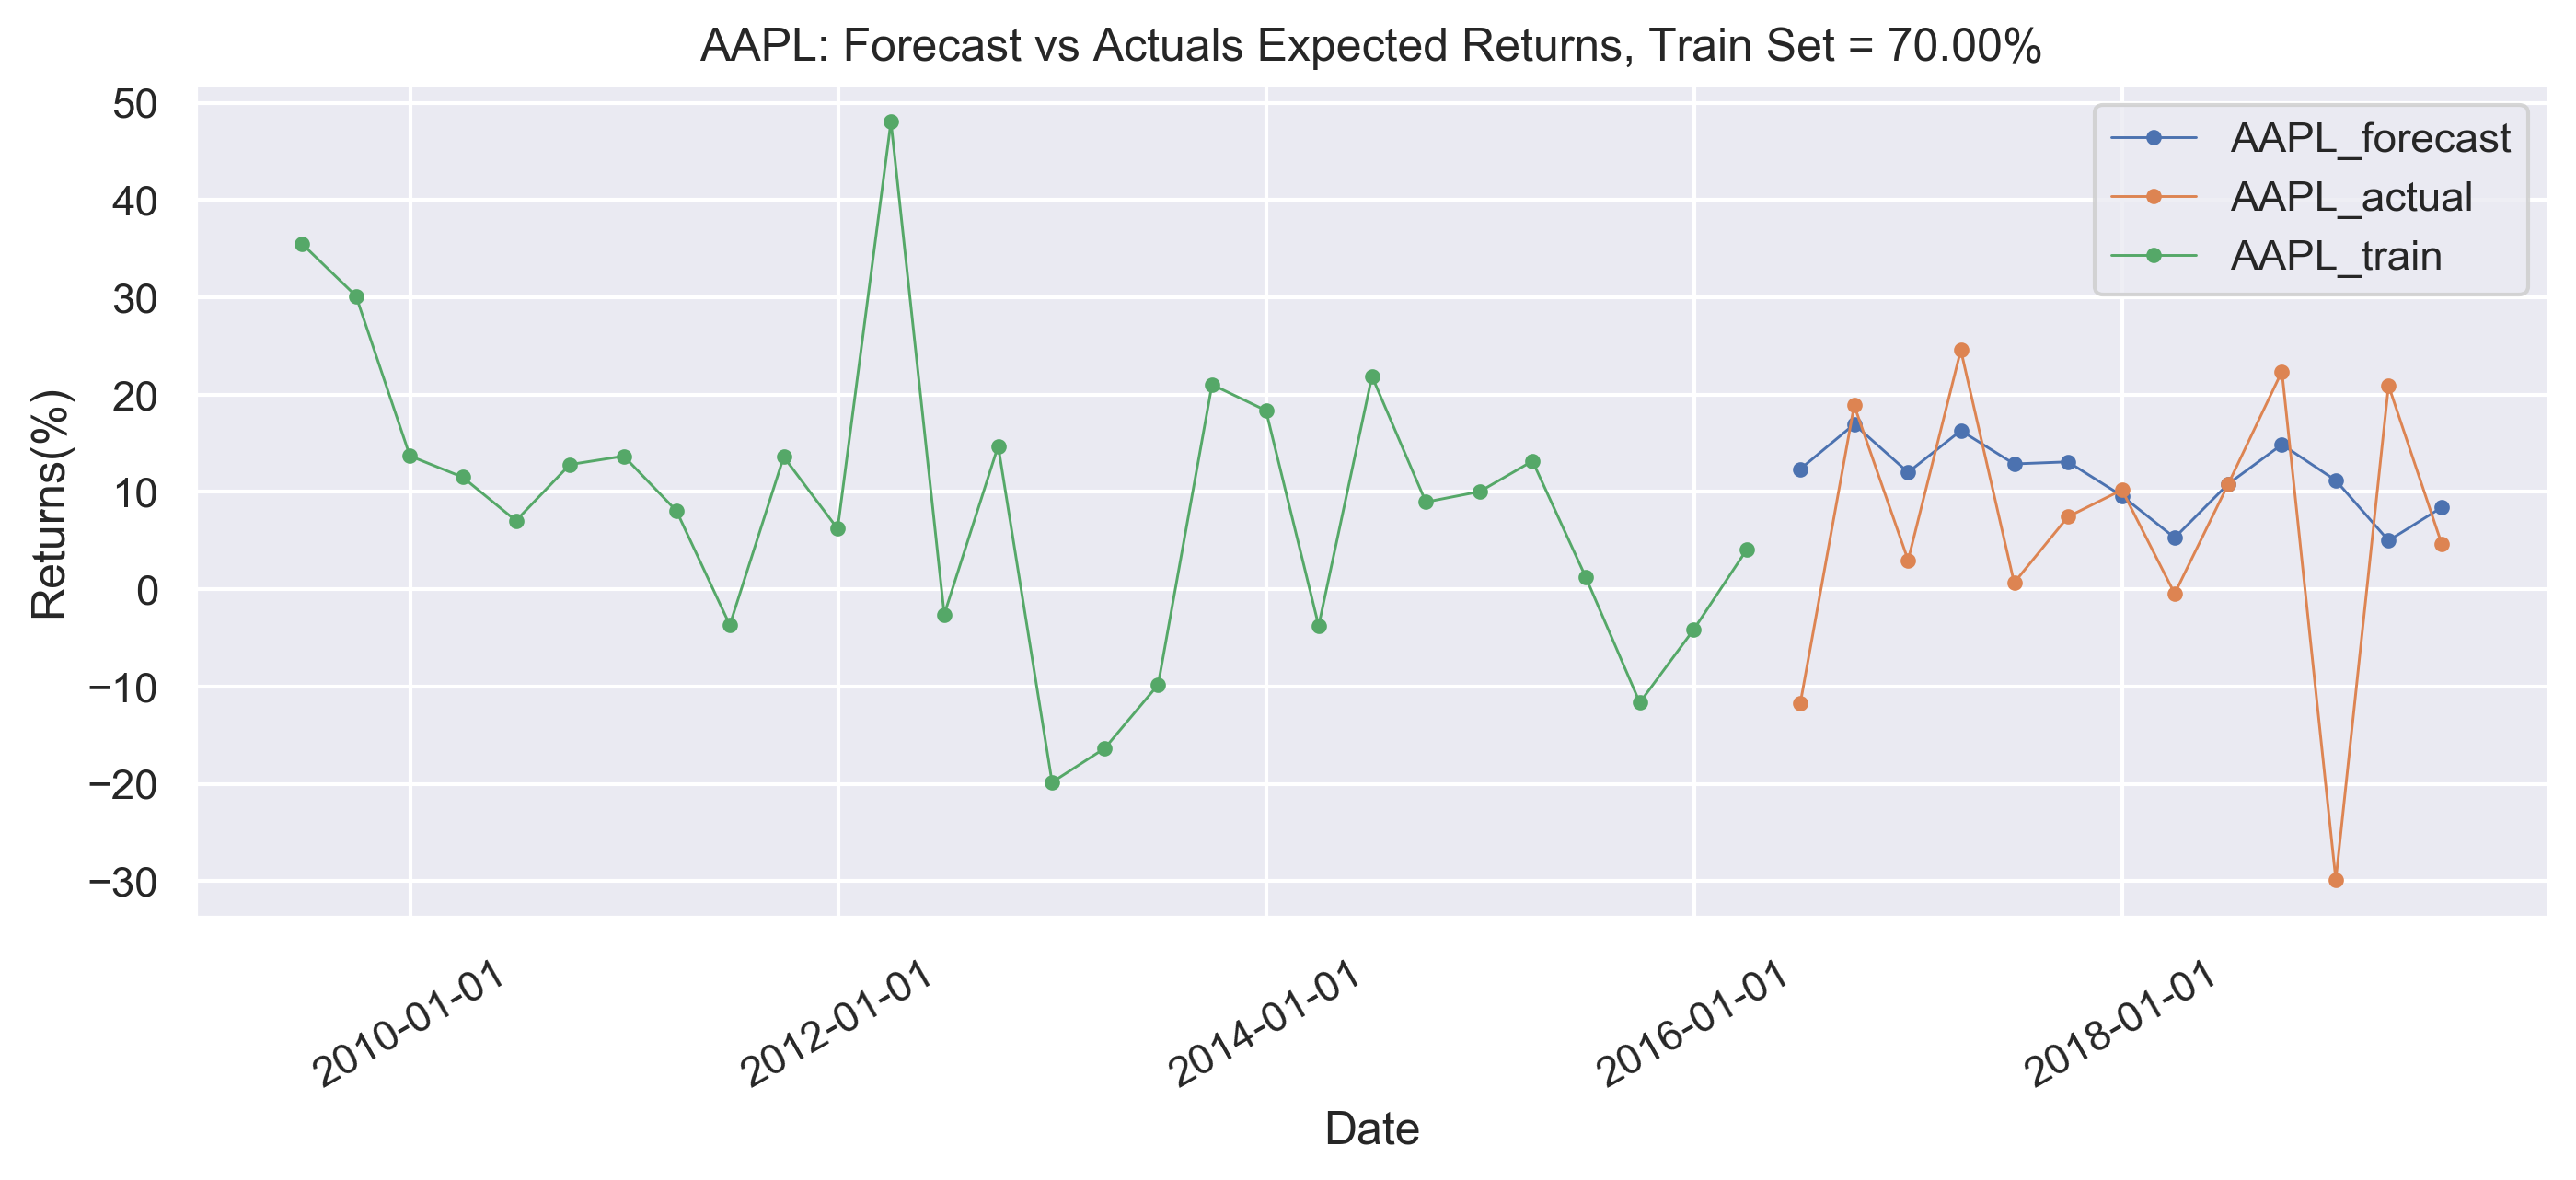

The test size is:  0.2
                            OLS Regression Results                            
Dep. Variable:         ATVI US EQUITY   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                   0.06282
Date:                Tue, 24 Sep 2019   Prob (F-statistic):              0.939
Time:                        10:46:21   Log-Likelihood:                -134.29
No. Observations:                  33   AIC:                             274.6
Df Residuals:                      30   BIC:                             279.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


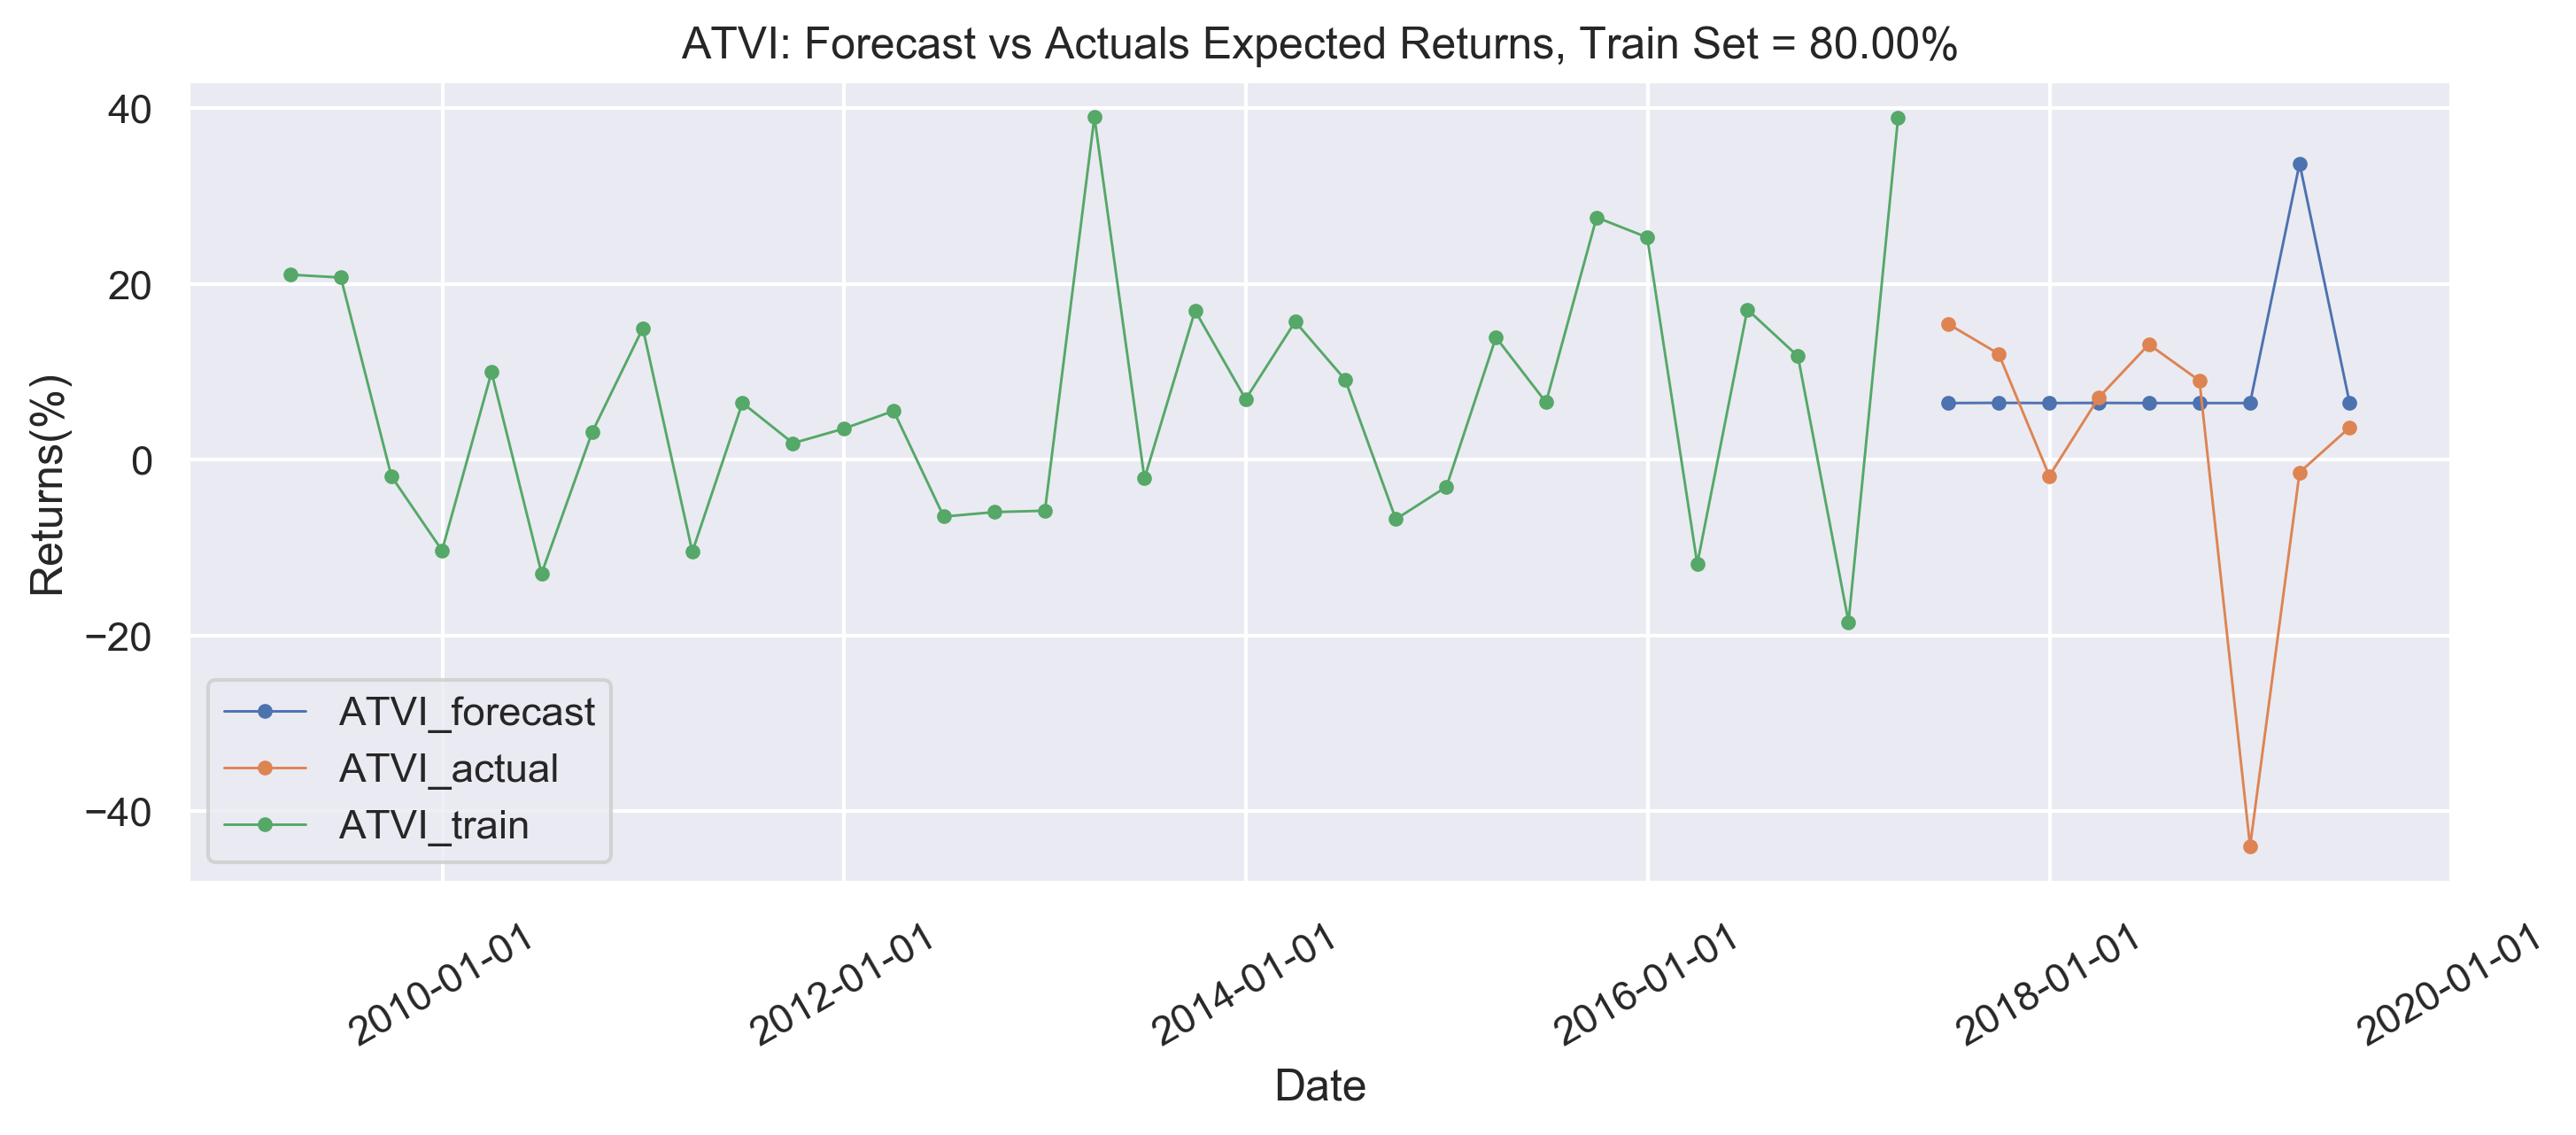

The test size is:  0.05
                            OLS Regression Results                            
Dep. Variable:          ABT US EQUITY   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     4.735
Date:                Tue, 24 Sep 2019   Prob (F-statistic):             0.0149
Time:                        10:46:22   Log-Likelihood:                -133.63
No. Observations:                  39   AIC:                             273.3
Df Residuals:                      36   BIC:                             278.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


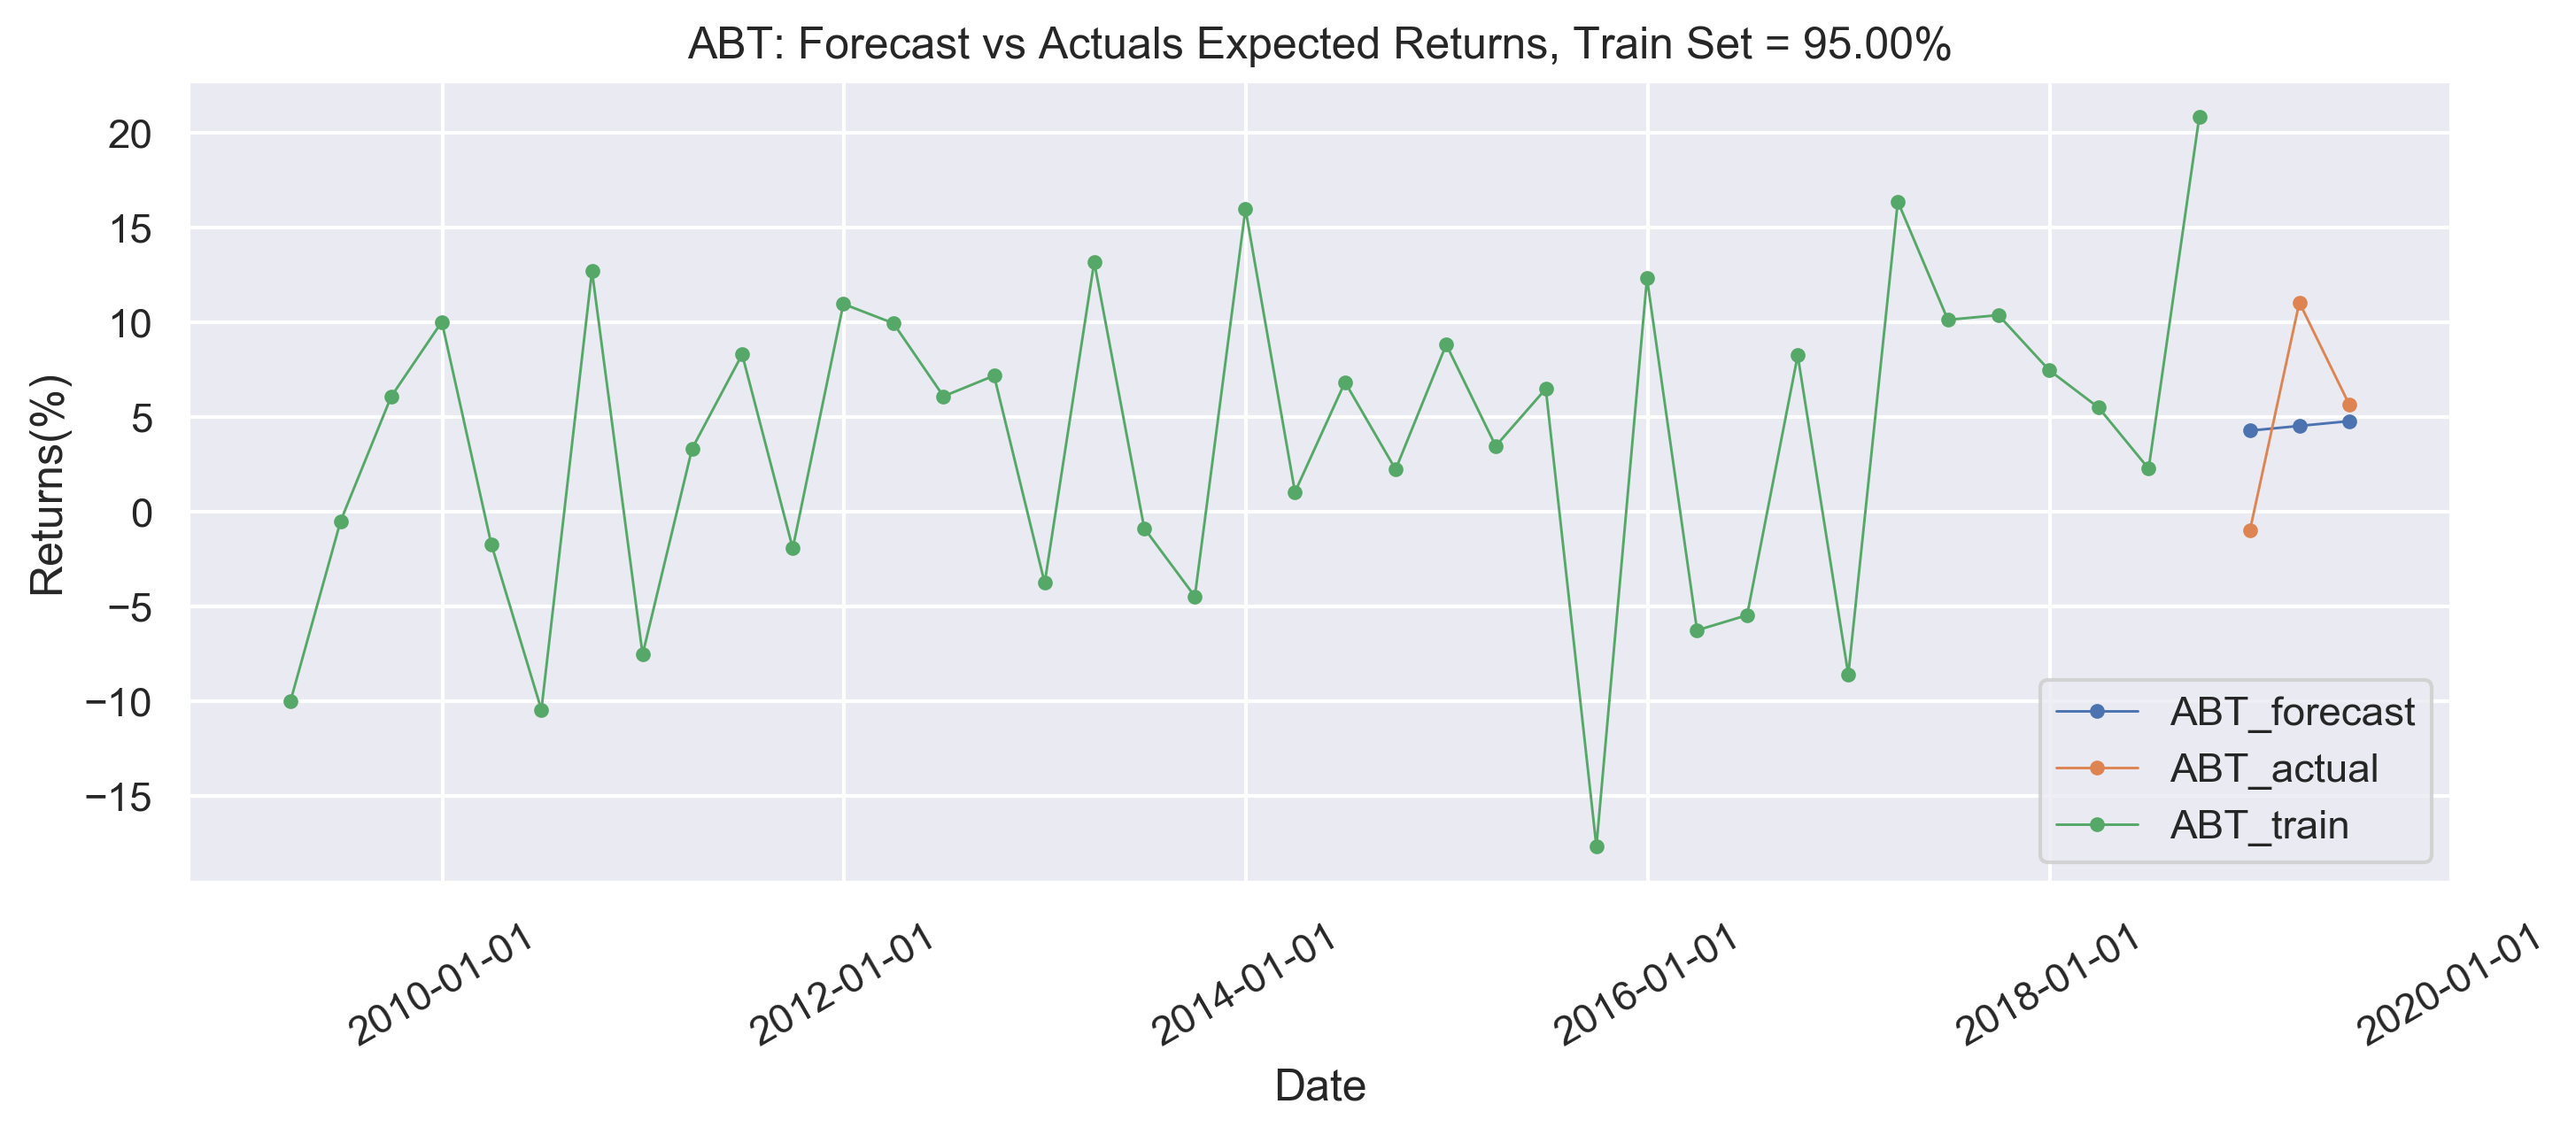

The test size is:  0.3
                            OLS Regression Results                            
Dep. Variable:         BIIB US EQUITY   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     1.939
Date:                Tue, 24 Sep 2019   Prob (F-statistic):              0.165
Time:                        10:46:23   Log-Likelihood:                -112.76
No. Observations:                  28   AIC:                             231.5
Df Residuals:                      25   BIC:                             235.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


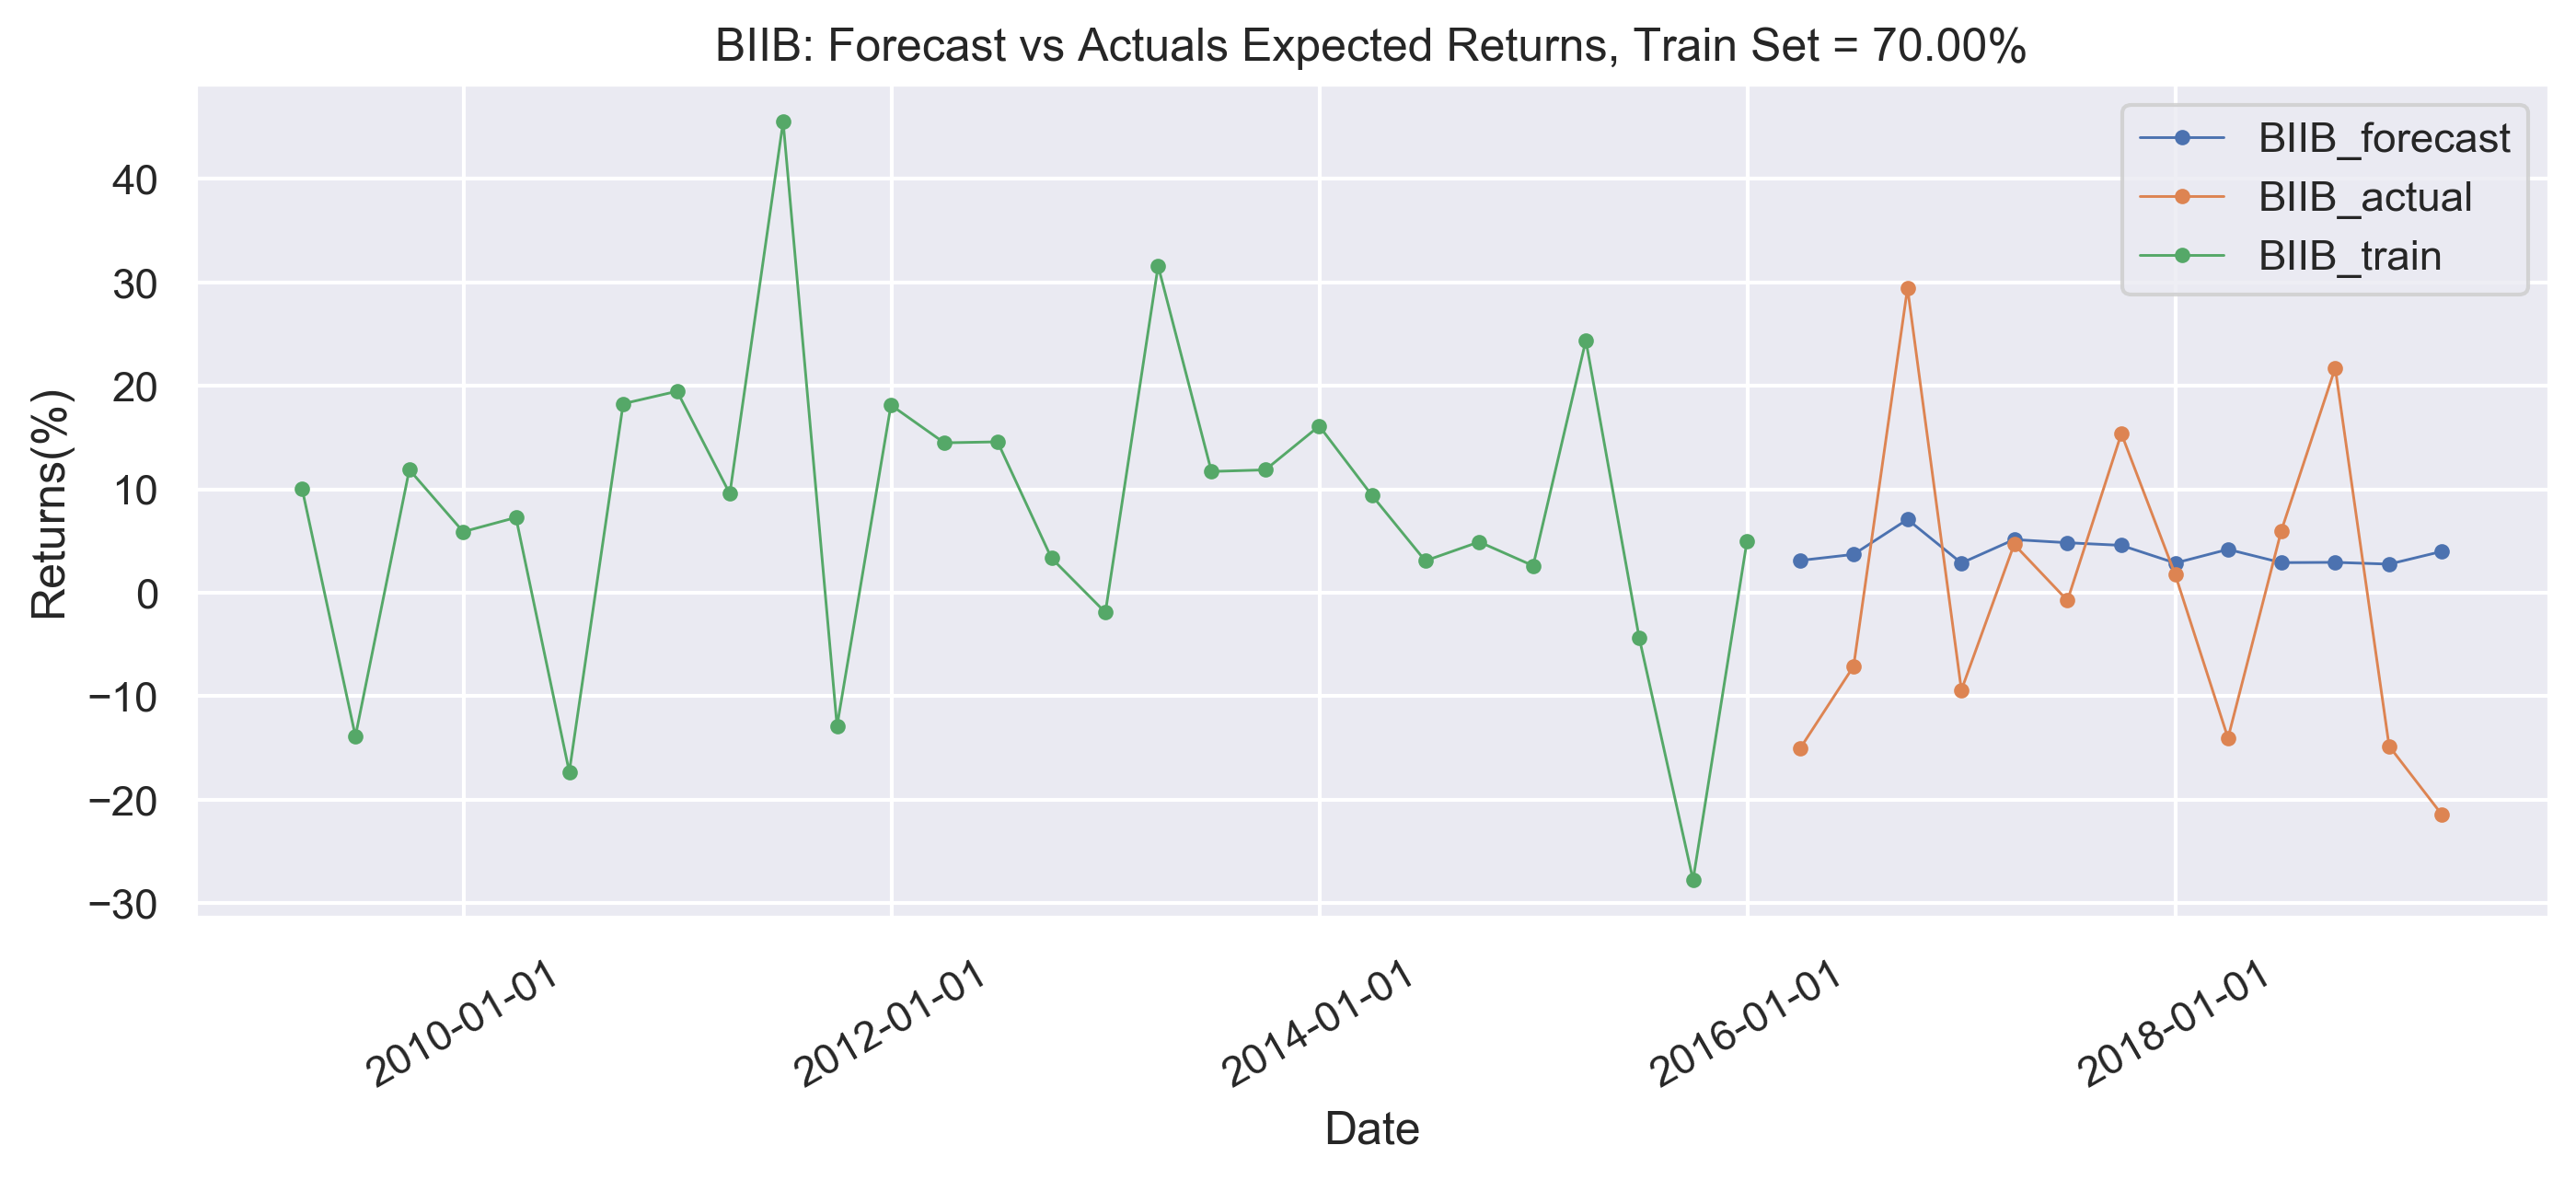

The test size is:  0.2
                            OLS Regression Results                            
Dep. Variable:           EA US Equity   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.467
Date:                Tue, 24 Sep 2019   Prob (F-statistic):              0.247
Time:                        10:46:23   Log-Likelihood:                -135.18
No. Observations:                  33   AIC:                             276.4
Df Residuals:                      30   BIC:                             280.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


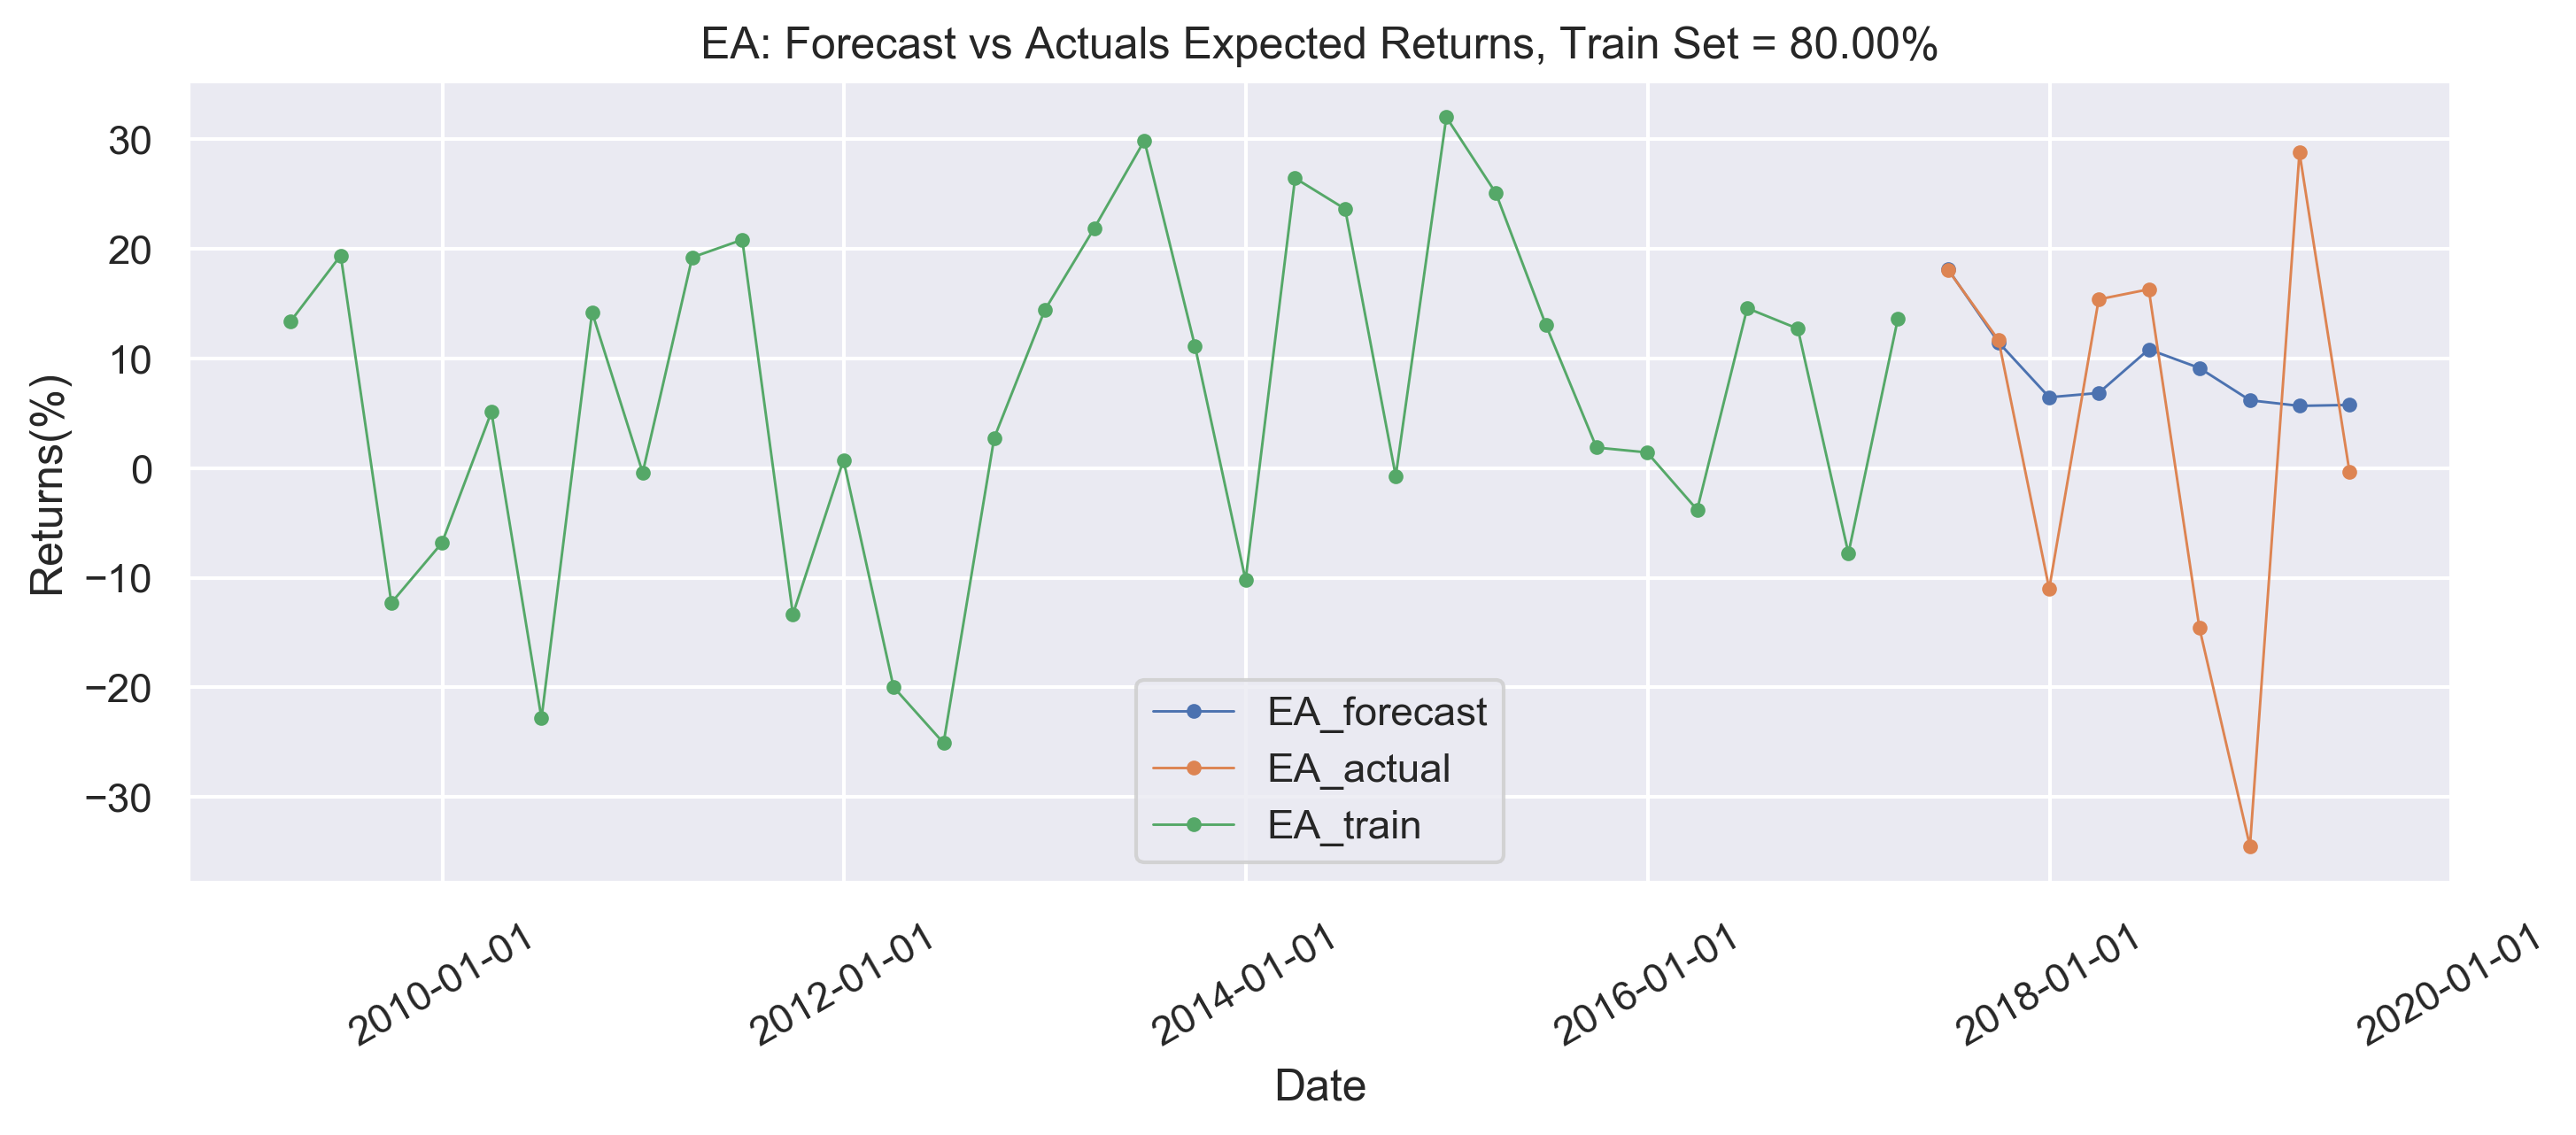

The test size is:  0.3
                            OLS Regression Results                            
Dep. Variable:         TTWO US EQUITY   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                 -0.035
Method:                 Least Squares   F-statistic:                    0.5307
Date:                Tue, 24 Sep 2019   Prob (F-statistic):              0.594
Time:                        10:46:24   Log-Likelihood:                -120.80
No. Observations:                  29   AIC:                             247.6
Df Residuals:                      26   BIC:                             251.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


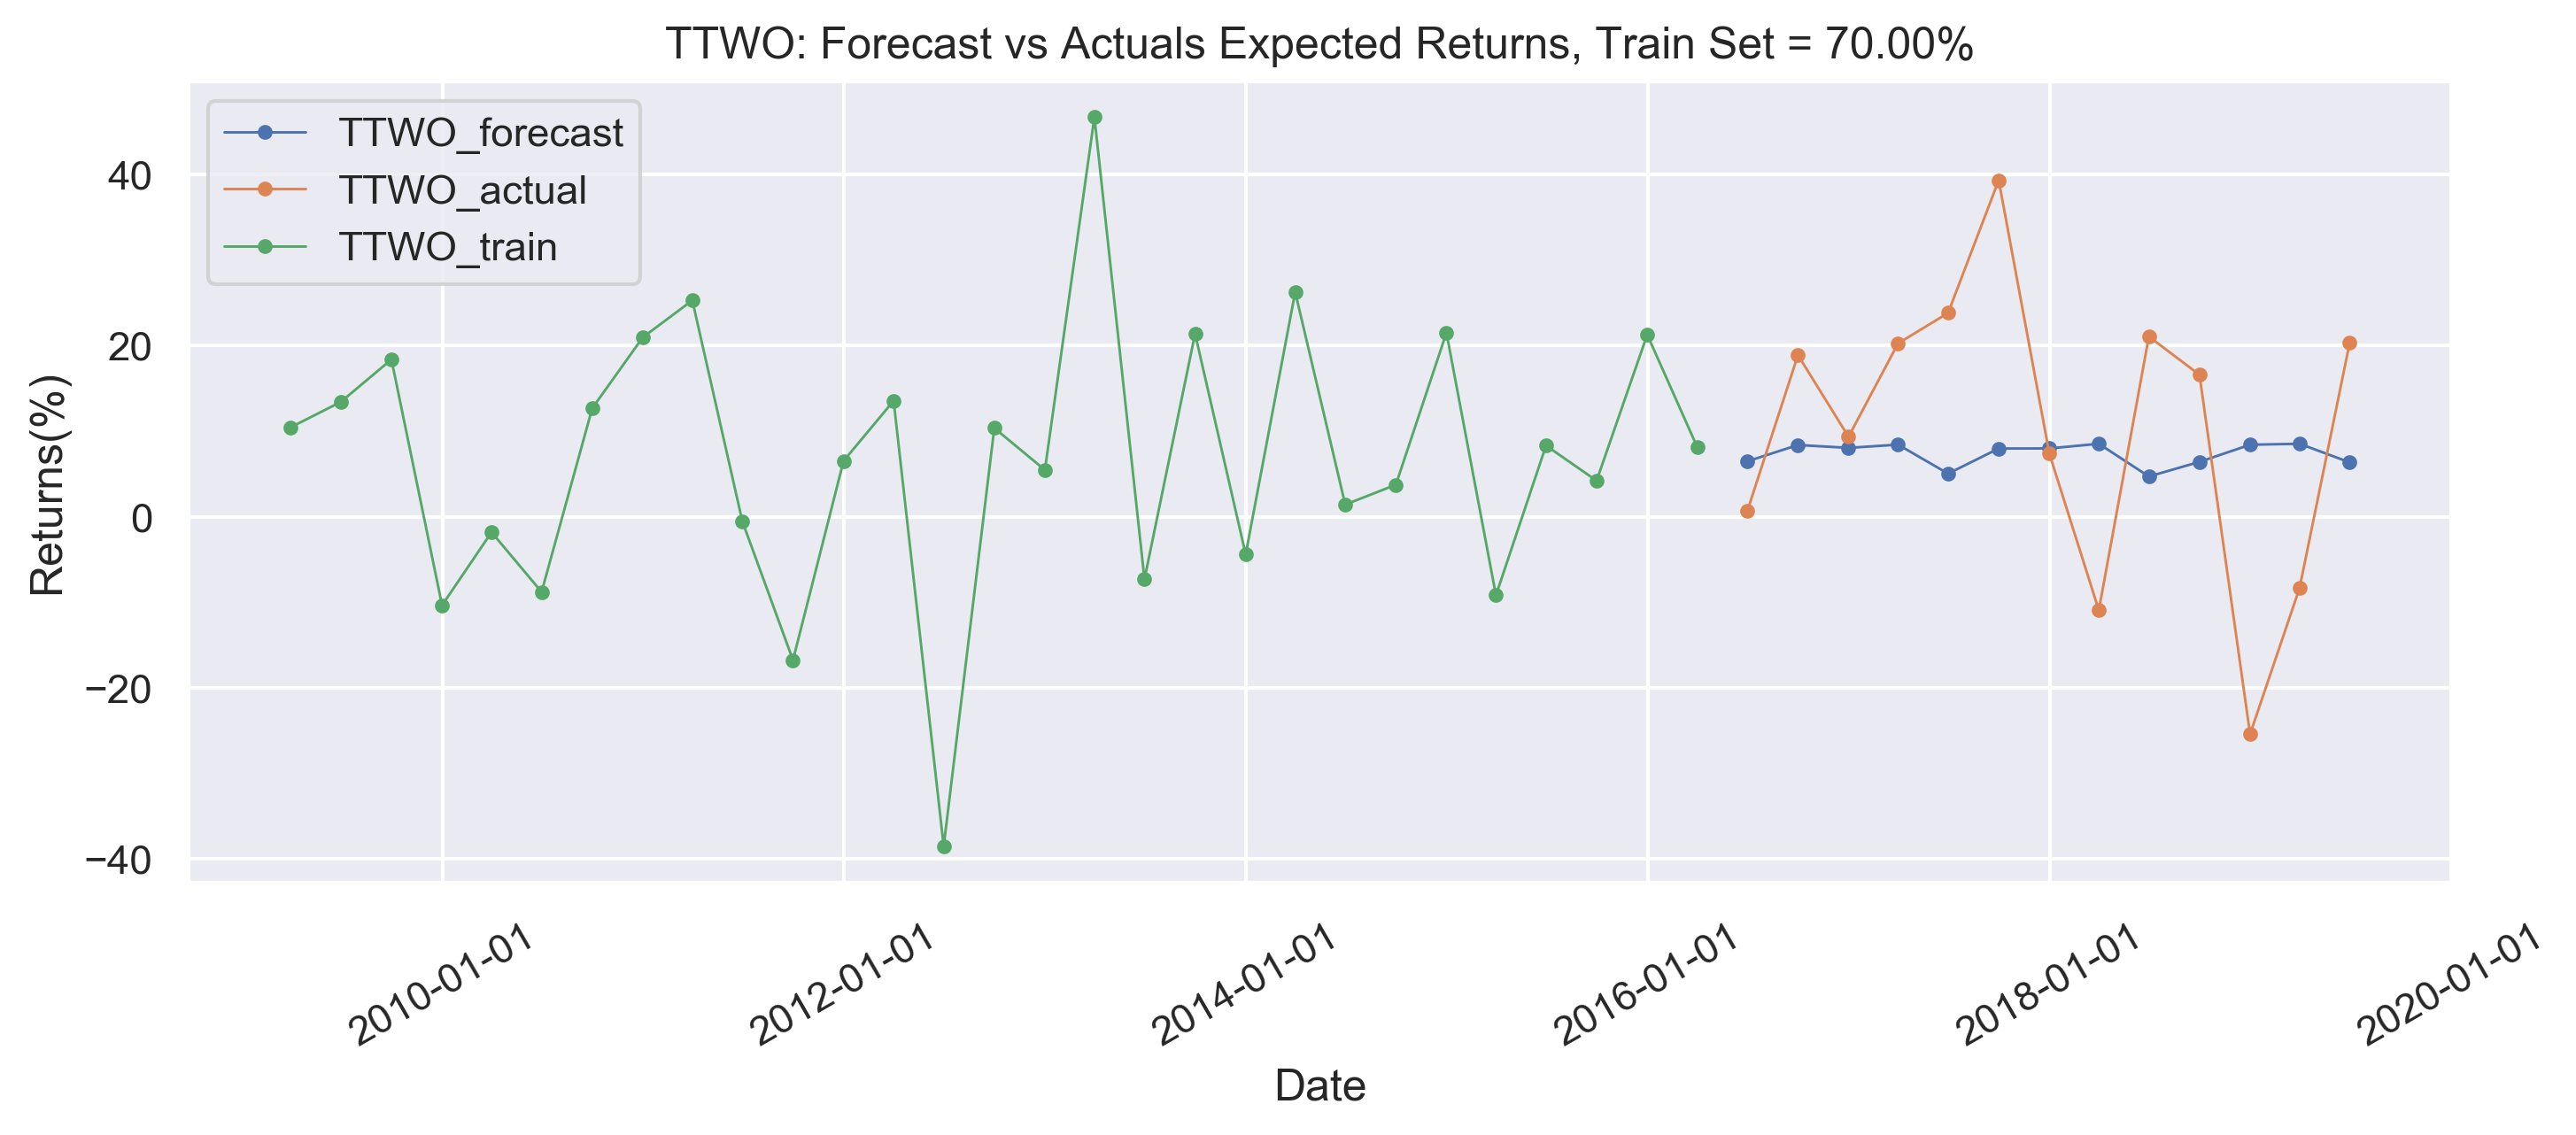

In [16]:
# Forecast and Plot Quarterly Returns
for ticker in ticker_list:
    size_linear_Q = select_size(data_Q,ticker)
    [y_test_Q,y_train_Q,y_pred_Q,test_size_Q,table_Q] = linear_regression(data_Q,ticker,size_linear_Q)
    table_Q = pd.DataFrame(table_Q)
    table_Q = table_Q[table_Q.iloc[:,0]!=0]
    table_Q.to_csv(ticker+"_table_Q"+".csv")
#     table_Q.to_csv(ticker+"_table_Q.csv")
    forecast_plot(y_test_Q,y_train_Q,y_pred_Q,test_size_Q)

* With one independent Variable "Transaction Dollar Value_P"

In [17]:
def select_size(data,ticker):
    X = data[ticker].filter(regex = 'Transaction Dollar Value_P')
    y = data[ticker].iloc[:,-1:]
    
#     X = data[ticker].iloc[:-1,:-1]
#     y = data[ticker].iloc[1:,-1:]
#     X.index=y.index
    
    # Split data into testing and test data
    test_size = [0.05,0.1,0.2,0.3]
    R2_score = []
    for size in test_size:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, shuffle=False) 
        # fit the linear model and calculate R2 score
        clf = LinearRegression().fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        R2_score.append(r2_score(y_test, y_pred))
    # select size with best r2 score
    size_linear = test_size[R2_score.index(max(R2_score))]
    print("The test size is: ",size_linear)
    
    return size_linear

In [18]:
# run simple linear regression
def linear_regression(data,ticker,size_linear): 
    X = data[ticker].filter(regex = 'Transaction Dollar Value_P')
    y = data[ticker].iloc[:,-1:]
    
#     X = data[ticker].iloc[:-1,:-1]
#     y = data[ticker].iloc[1:,-1:]
#     X.index=y.index
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size_linear, shuffle=False)
    # fit the model with best alpha and best size
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train)
    results_fr = model.fit()
    results_as_html = results_fr.summary().tables[1].as_html()
    table = pd.read_html(results_as_html, header=0, index_col=0)[0]
    print(results_fr.summary())
    X_test = sm.add_constant(X_test,has_constant='add')
    y_pred  = results_fr.predict(X_test)
    print("The r2 score is: ", r2_score(y_test,y_pred))
    return y_test,y_train,y_pred,size_linear,table

The test size is:  0.1
                            OLS Regression Results                            
Dep. Variable:         AAPL US EQUITY   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     4.014
Date:                Tue, 24 Sep 2019   Prob (F-statistic):             0.0531
Time:                        10:46:39   Log-Likelihood:                -144.29
No. Observations:                  36   AIC:                             292.6
Df Residuals:                      34   BIC:                             295.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


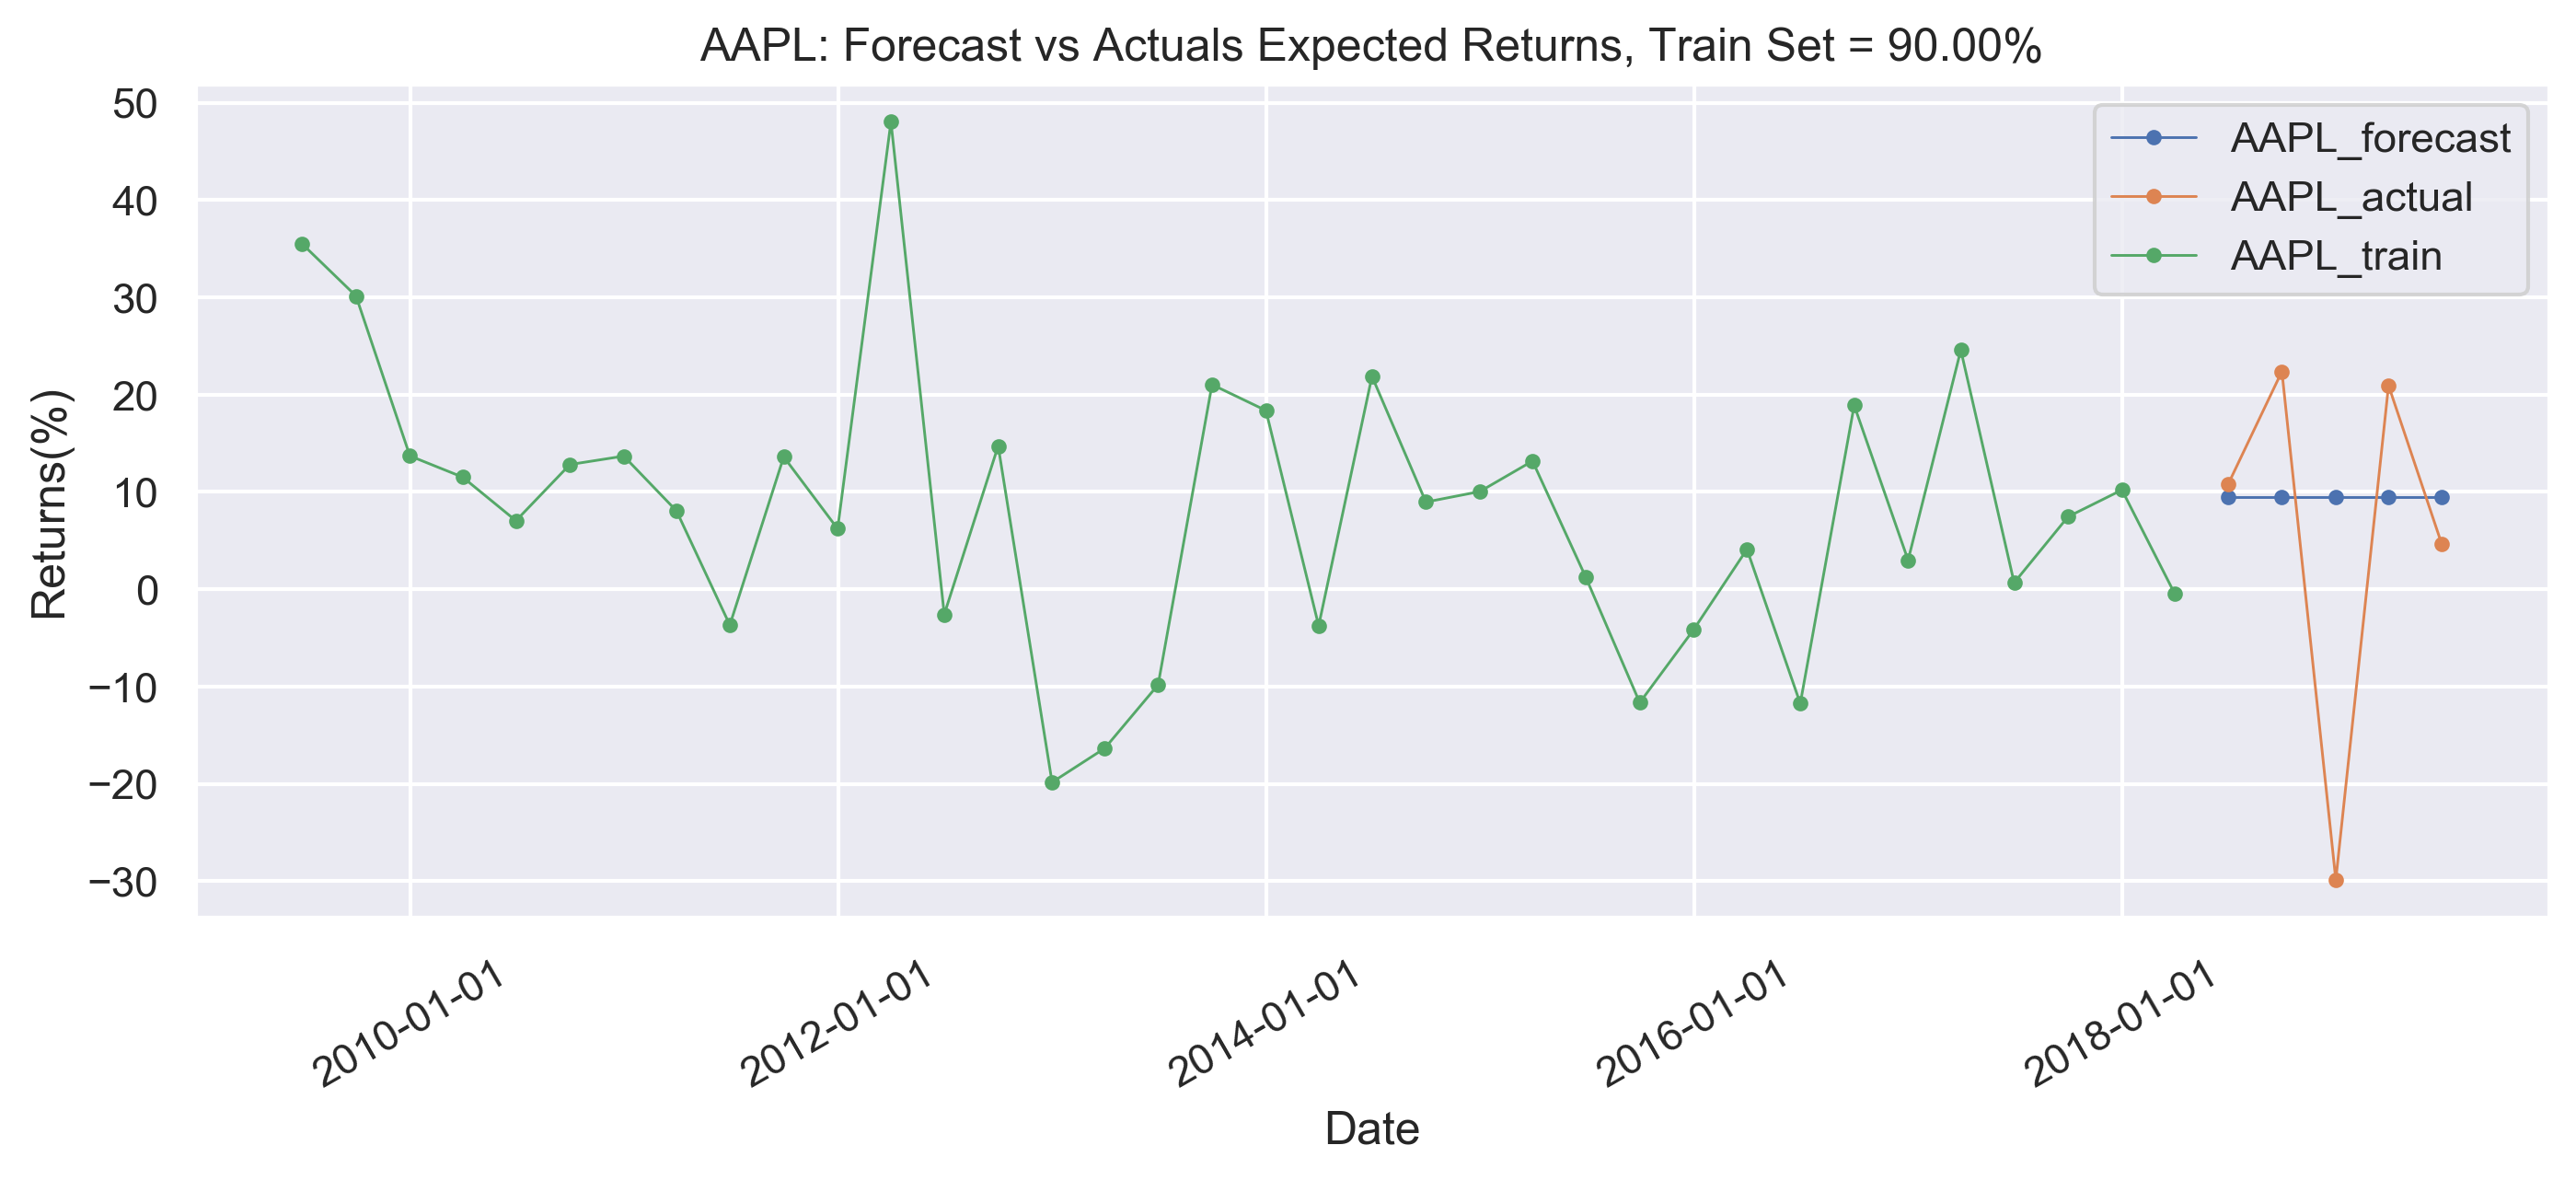

The test size is:  0.2
                            OLS Regression Results                            
Dep. Variable:         ATVI US EQUITY   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                    0.1174
Date:                Tue, 24 Sep 2019   Prob (F-statistic):              0.734
Time:                        10:46:40   Log-Likelihood:                -134.29
No. Observations:                  33   AIC:                             272.6
Df Residuals:                      31   BIC:                             275.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


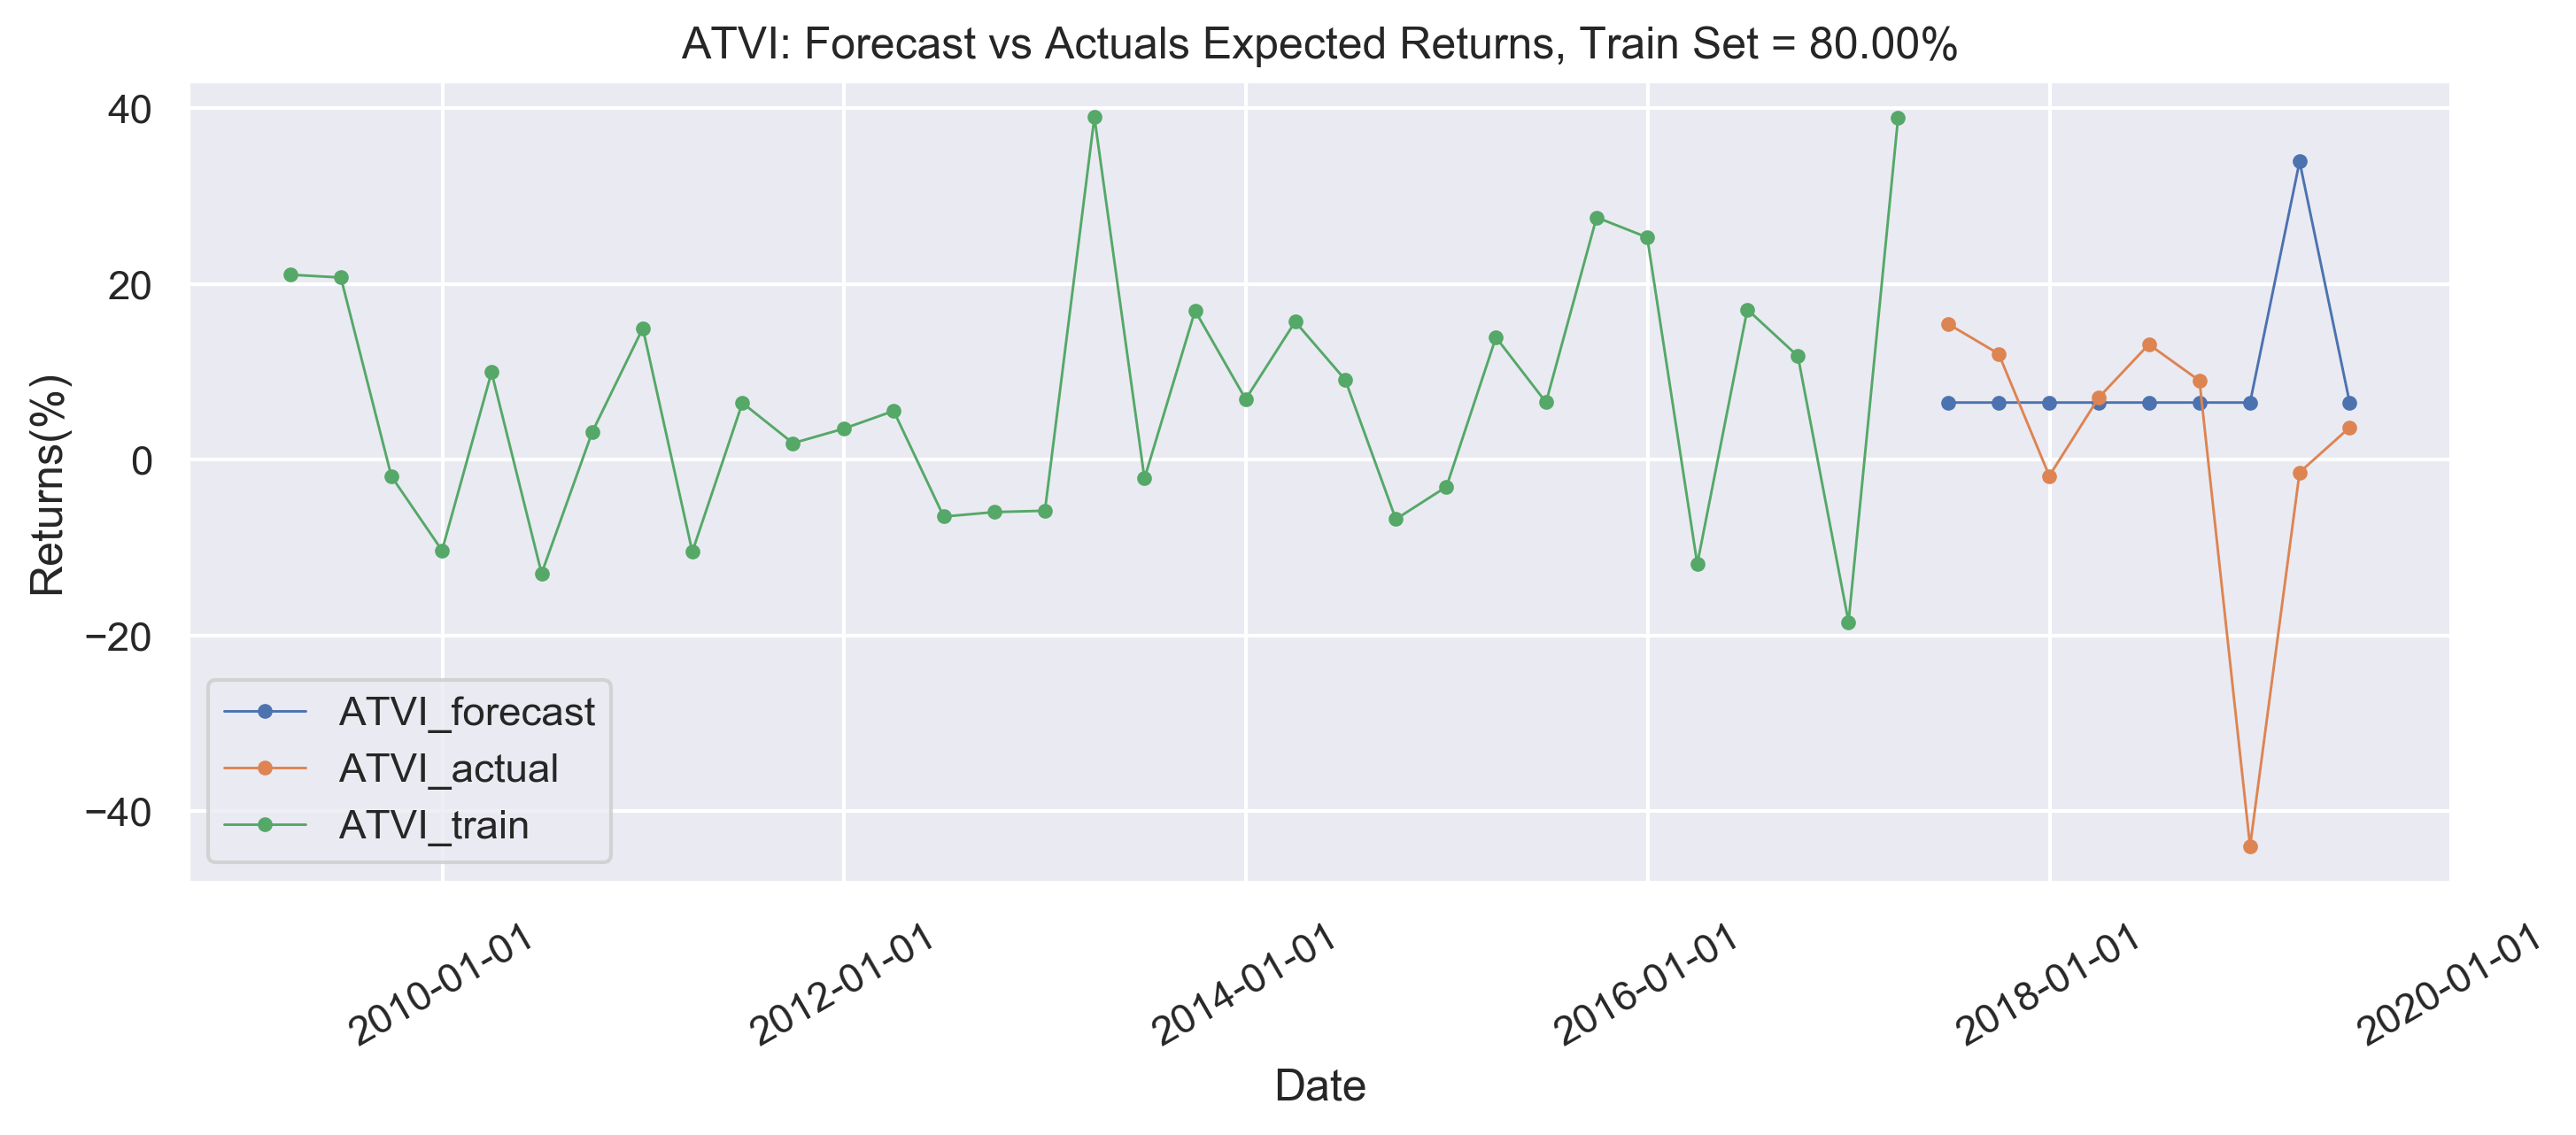

The test size is:  0.05
                            OLS Regression Results                            
Dep. Variable:          ABT US EQUITY   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     6.418
Date:                Tue, 24 Sep 2019   Prob (F-statistic):             0.0157
Time:                        10:46:41   Log-Likelihood:                -135.07
No. Observations:                  39   AIC:                             274.1
Df Residuals:                      37   BIC:                             277.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


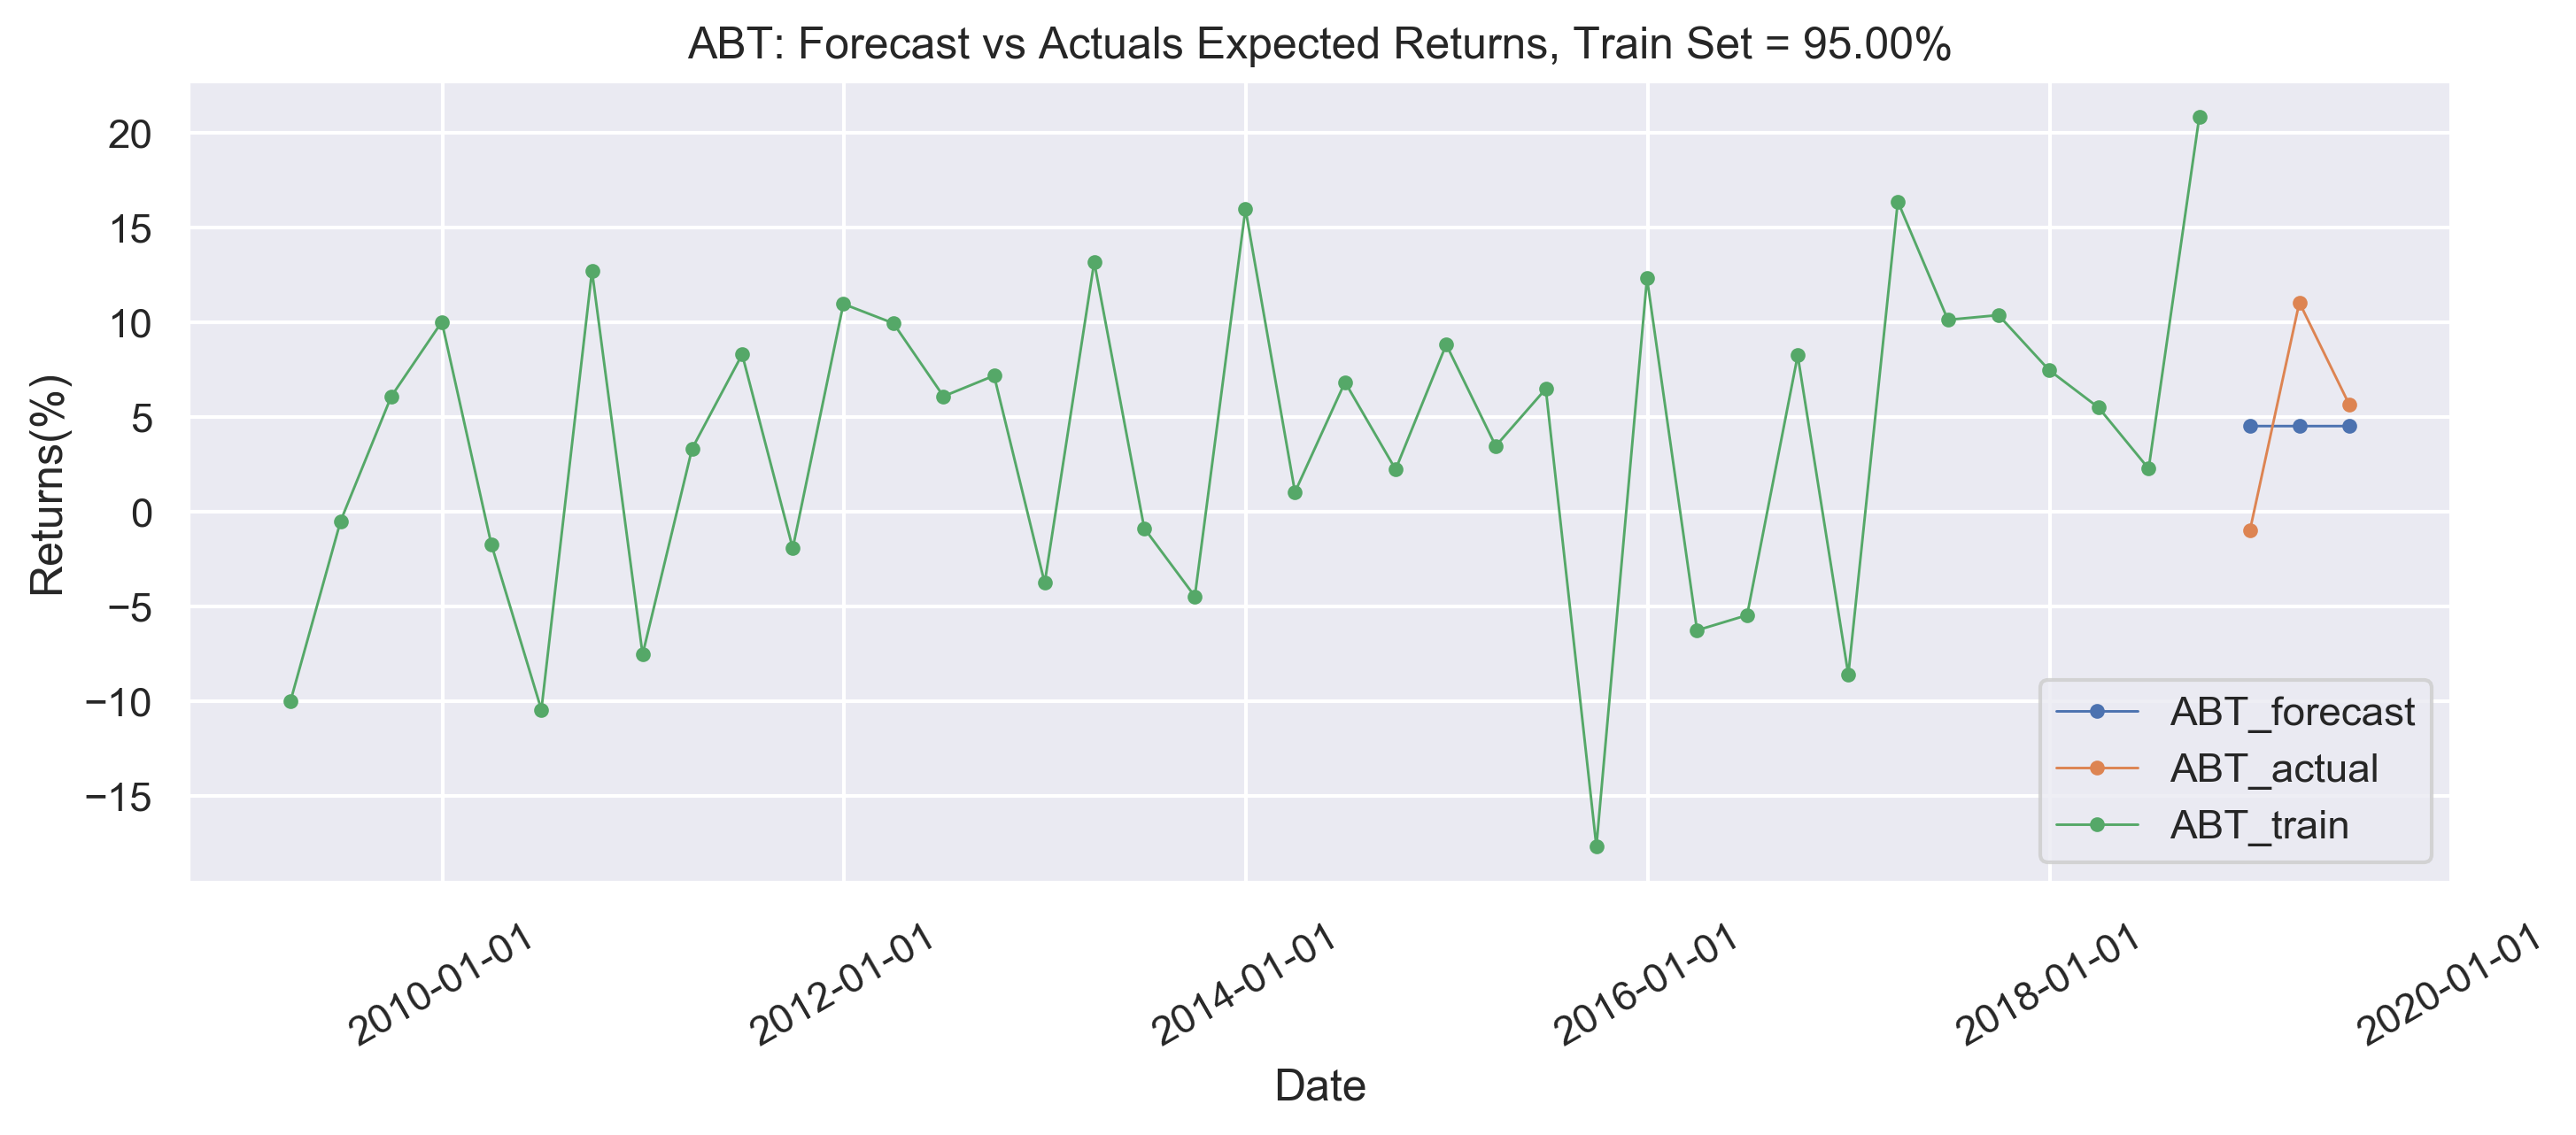

The test size is:  0.2
                            OLS Regression Results                            
Dep. Variable:         BIIB US EQUITY   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                   0.03999
Date:                Tue, 24 Sep 2019   Prob (F-statistic):              0.843
Time:                        10:46:42   Log-Likelihood:                -132.57
No. Observations:                  32   AIC:                             269.1
Df Residuals:                      30   BIC:                             272.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


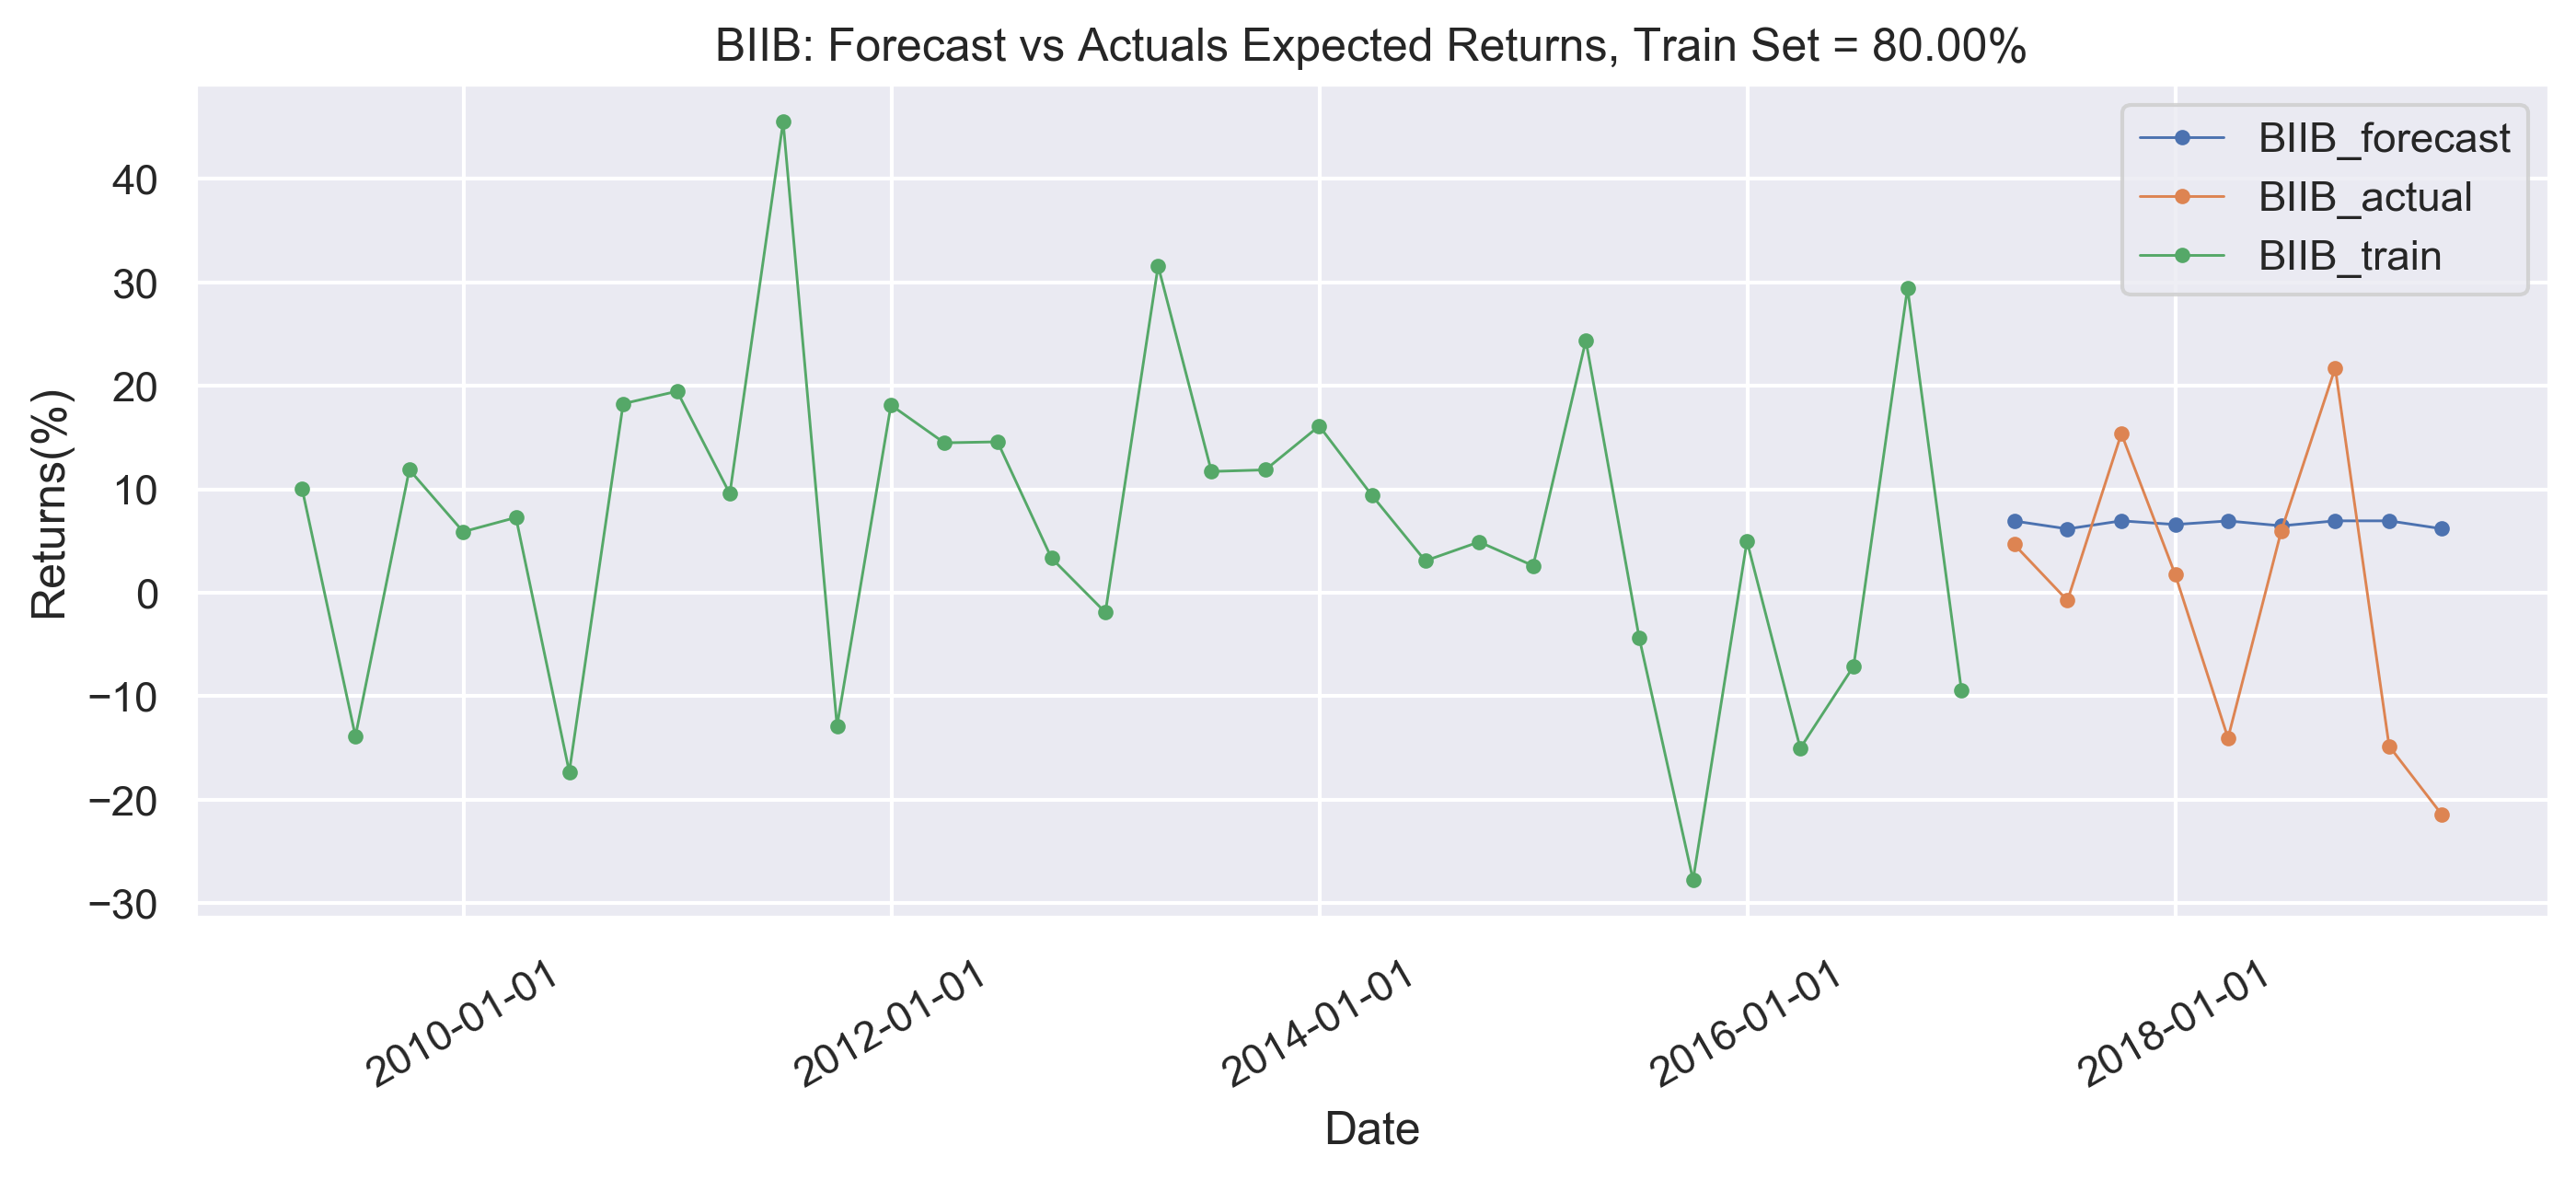

The test size is:  0.2
                            OLS Regression Results                            
Dep. Variable:           EA US Equity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                 0.0009836
Date:                Tue, 24 Sep 2019   Prob (F-statistic):              0.975
Time:                        10:46:43   Log-Likelihood:                -136.72
No. Observations:                  33   AIC:                             277.4
Df Residuals:                      31   BIC:                             280.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


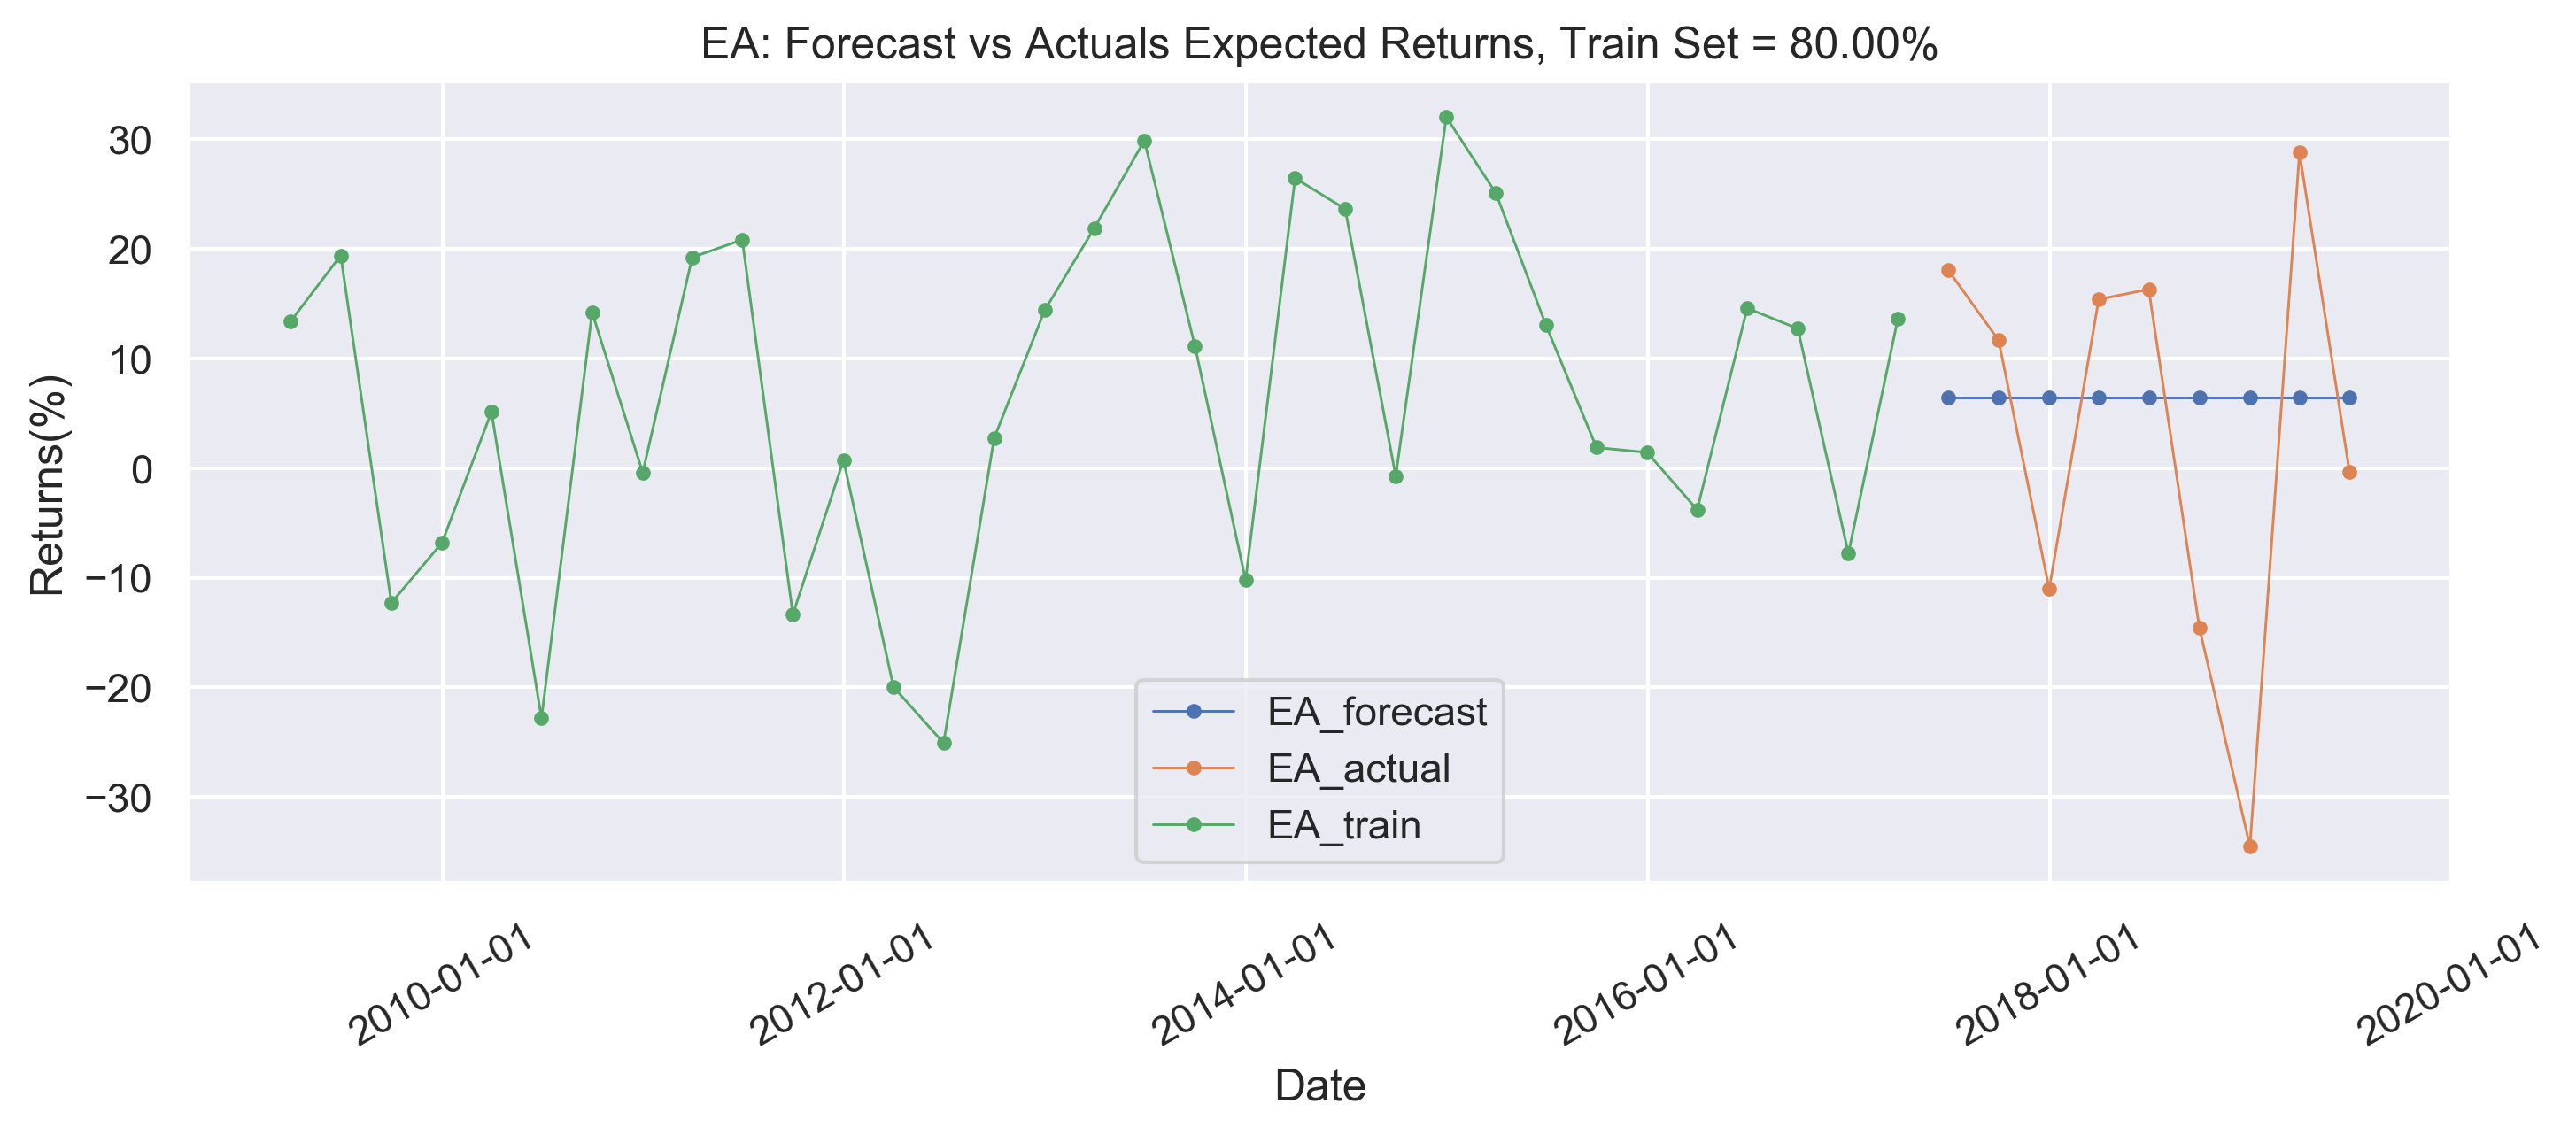

The test size is:  0.2
                            OLS Regression Results                            
Dep. Variable:         TTWO US EQUITY   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.3303
Date:                Tue, 24 Sep 2019   Prob (F-statistic):              0.570
Time:                        10:46:44   Log-Likelihood:                -136.59
No. Observations:                  33   AIC:                             277.2
Df Residuals:                      31   BIC:                             280.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


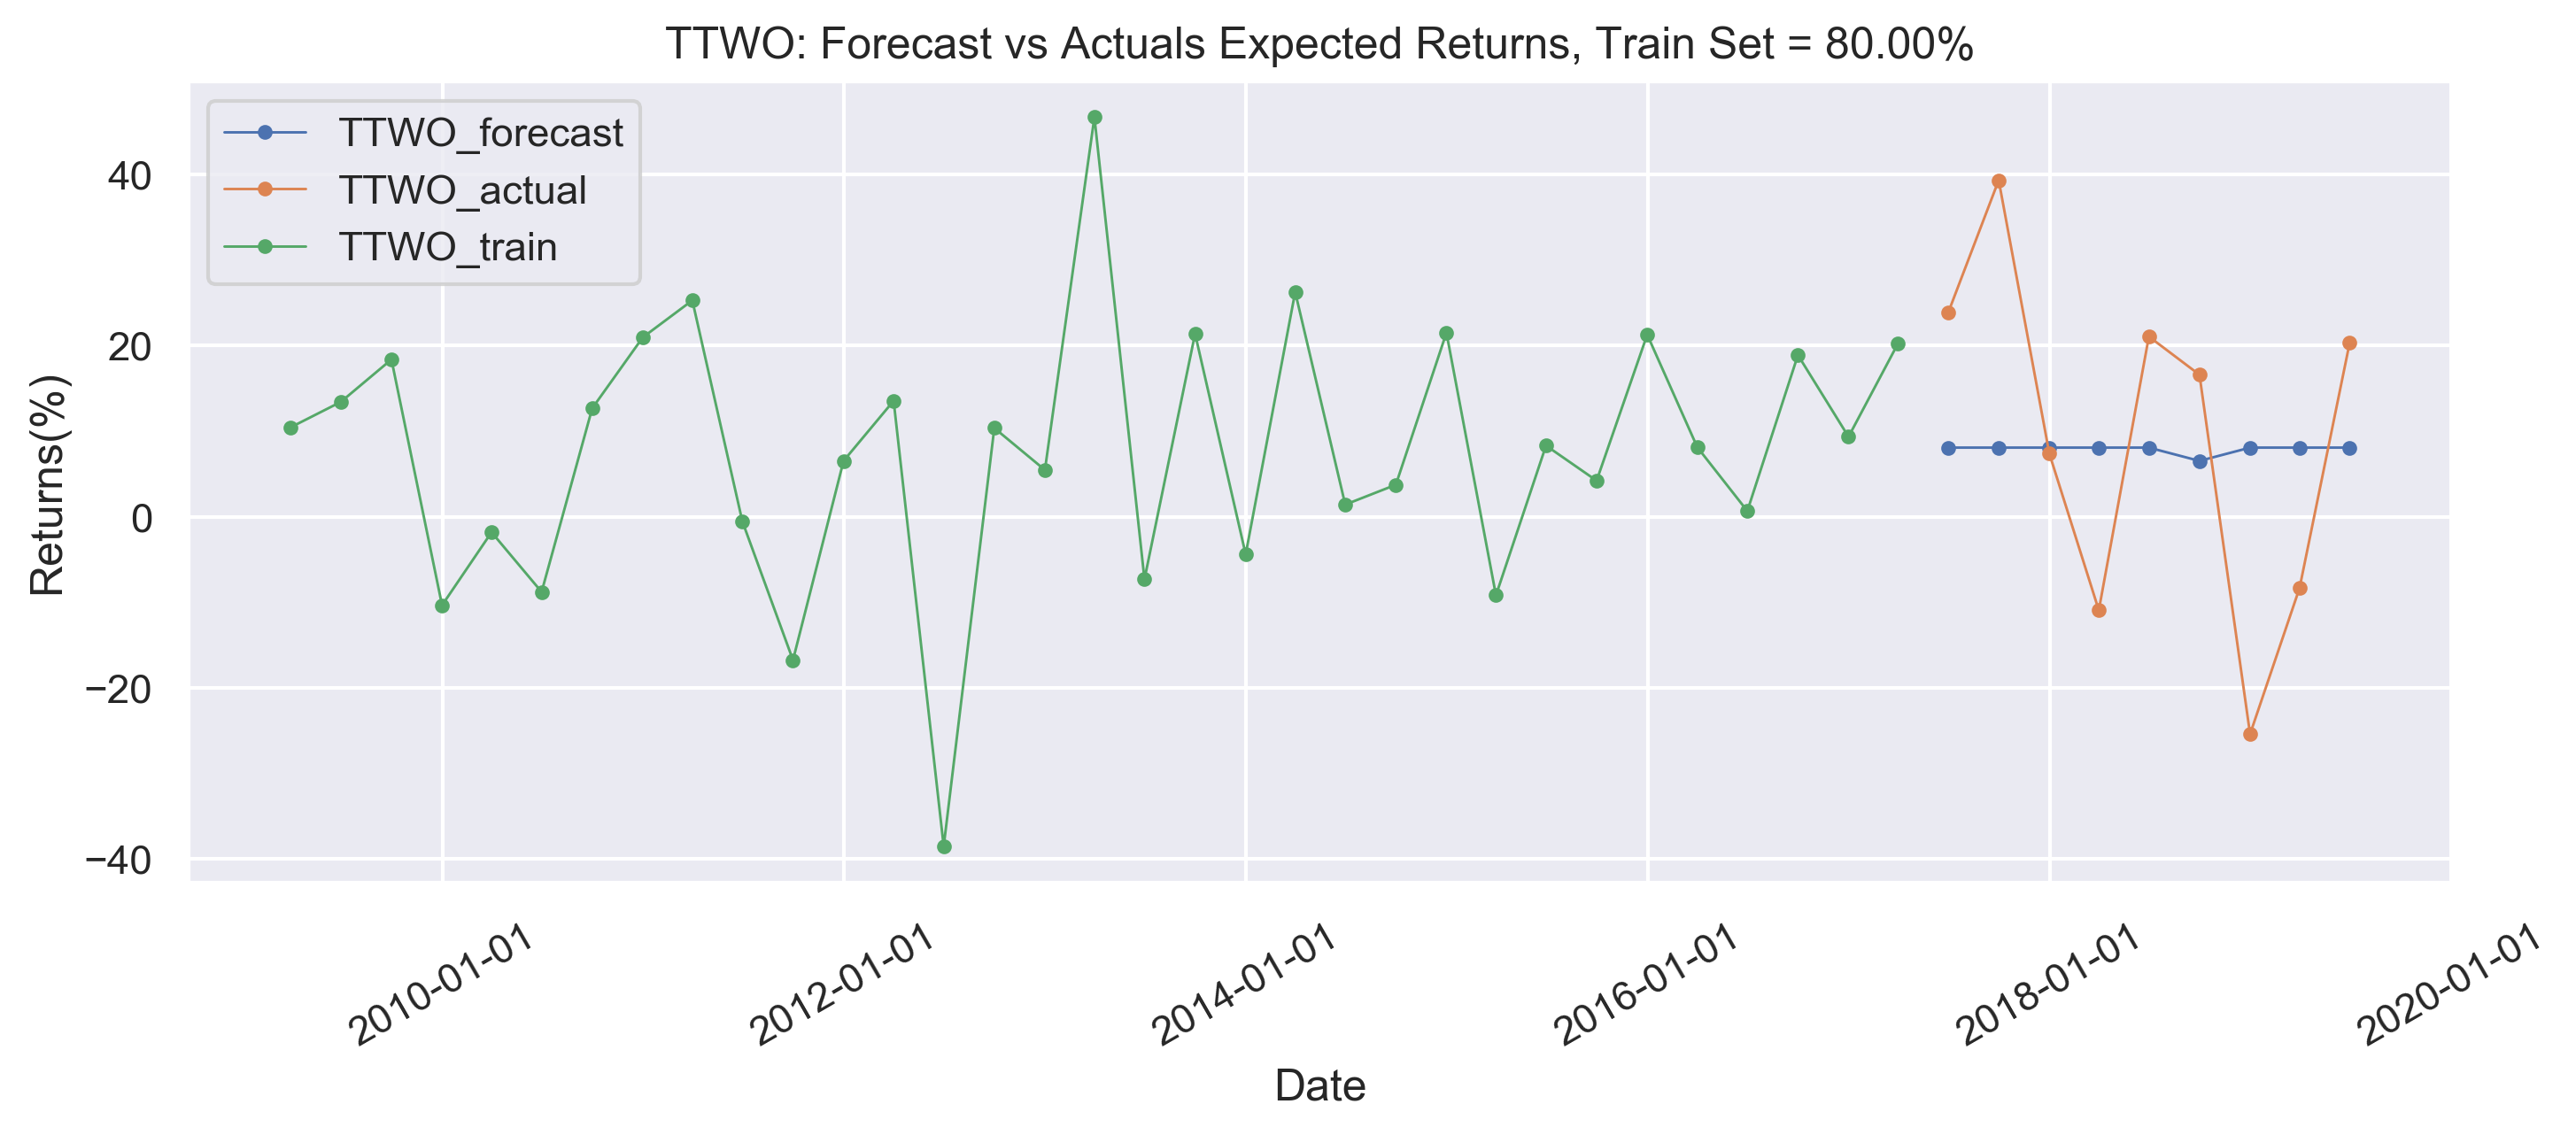

In [19]:
# Forecast and Plot Quarterly Returns
for ticker in ticker_list:
    size_linear_Q = select_size(data_Q,ticker)
    [y_test_Q,y_train_Q,y_pred_Q,test_size_Q,table_Q] = linear_regression(data_Q,ticker,size_linear_Q)
    table_Q = pd.DataFrame(table_Q)
    table_Q = table_Q[table_Q.iloc[:,0]!=0]
    table_Q.to_csv(ticker+"_table_Q_Purchase"+".csv")
#     table_Q.to_csv(ticker+"_table_Q.csv")
    forecast_plot(y_test_Q,y_train_Q,y_pred_Q,test_size_Q)

* With one independent Variable "Transaction Dollar Value_S"

In [20]:
def select_size(data,ticker):
    X = data[ticker].filter(regex = 'Transaction Dollar Value_S')
    y = data[ticker].iloc[:,-1:]
    
#     X = data[ticker].iloc[:-1,:-1]
#     y = data[ticker].iloc[1:,-1:]
#     X.index=y.index
    
    # Split data into testing and test data
    test_size = [0.05,0.1,0.2,0.3]
    R2_score = []
    for size in test_size:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, shuffle=False) 
        # fit the linear model and calculate R2 score
        clf = LinearRegression().fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        R2_score.append(r2_score(y_test, y_pred))
    # select size with best r2 score
    size_linear = test_size[R2_score.index(max(R2_score))]
    print("The test size is: ",size_linear)
    
    return size_linear

In [21]:
# run simple linear regression
def linear_regression(data,ticker,size_linear): 
    X = data[ticker].filter(regex = 'Transaction Dollar Value_S')
    y = data[ticker].iloc[:,-1:]
    
#     X = data[ticker].iloc[:-1,:-1]
#     y = data[ticker].iloc[1:,-1:]
#     X.index=y.index
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size_linear, shuffle=False)
    # fit the model with best alpha and best size
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train)
    results_fr = model.fit()
    results_as_html = results_fr.summary().tables[1].as_html()
    table = pd.read_html(results_as_html, header=0, index_col=0)[0]
    print(results_fr.summary())
    X_test = sm.add_constant(X_test,has_constant='add')
    y_pred  = results_fr.predict(X_test)
    print("The r2 score is: ", r2_score(y_test,y_pred))
    return y_test,y_train,y_pred,size_linear,table

The test size is:  0.3
                            OLS Regression Results                            
Dep. Variable:         AAPL US EQUITY   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     4.293
Date:                Tue, 24 Sep 2019   Prob (F-statistic):             0.0483
Time:                        10:46:45   Log-Likelihood:                -113.17
No. Observations:                  28   AIC:                             230.3
Df Residuals:                      26   BIC:                             233.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


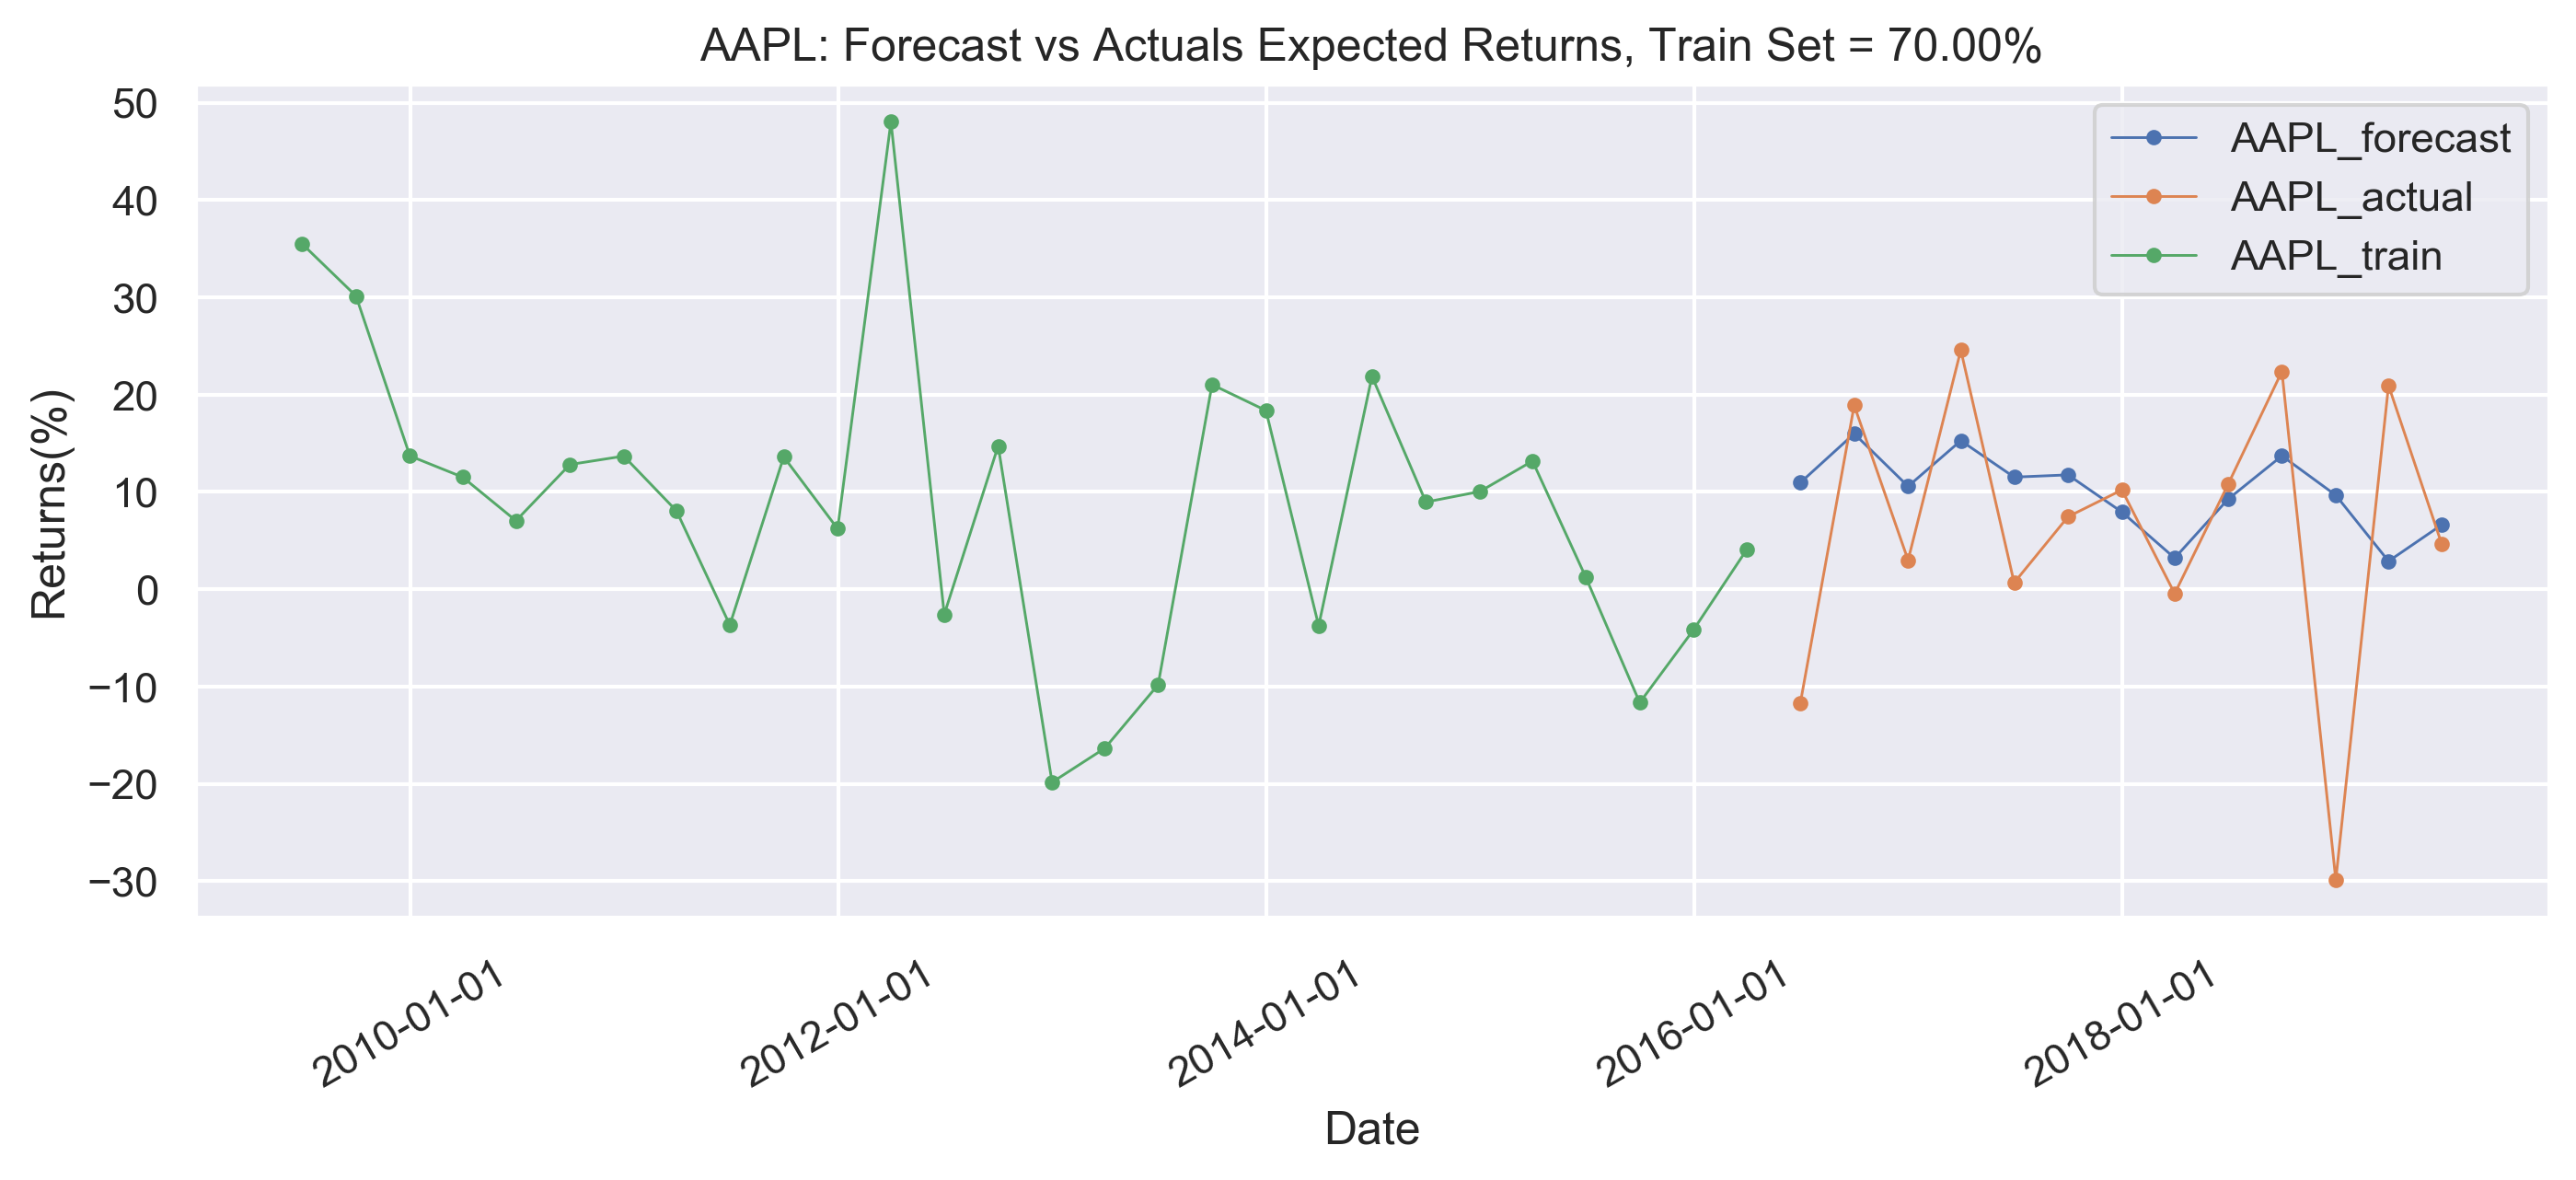

The test size is:  0.3
                            OLS Regression Results                            
Dep. Variable:         ATVI US EQUITY   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.037
Method:                 Least Squares   F-statistic:                   0.01002
Date:                Tue, 24 Sep 2019   Prob (F-statistic):              0.921
Time:                        10:46:46   Log-Likelihood:                -115.28
No. Observations:                  29   AIC:                             234.6
Df Residuals:                      27   BIC:                             237.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


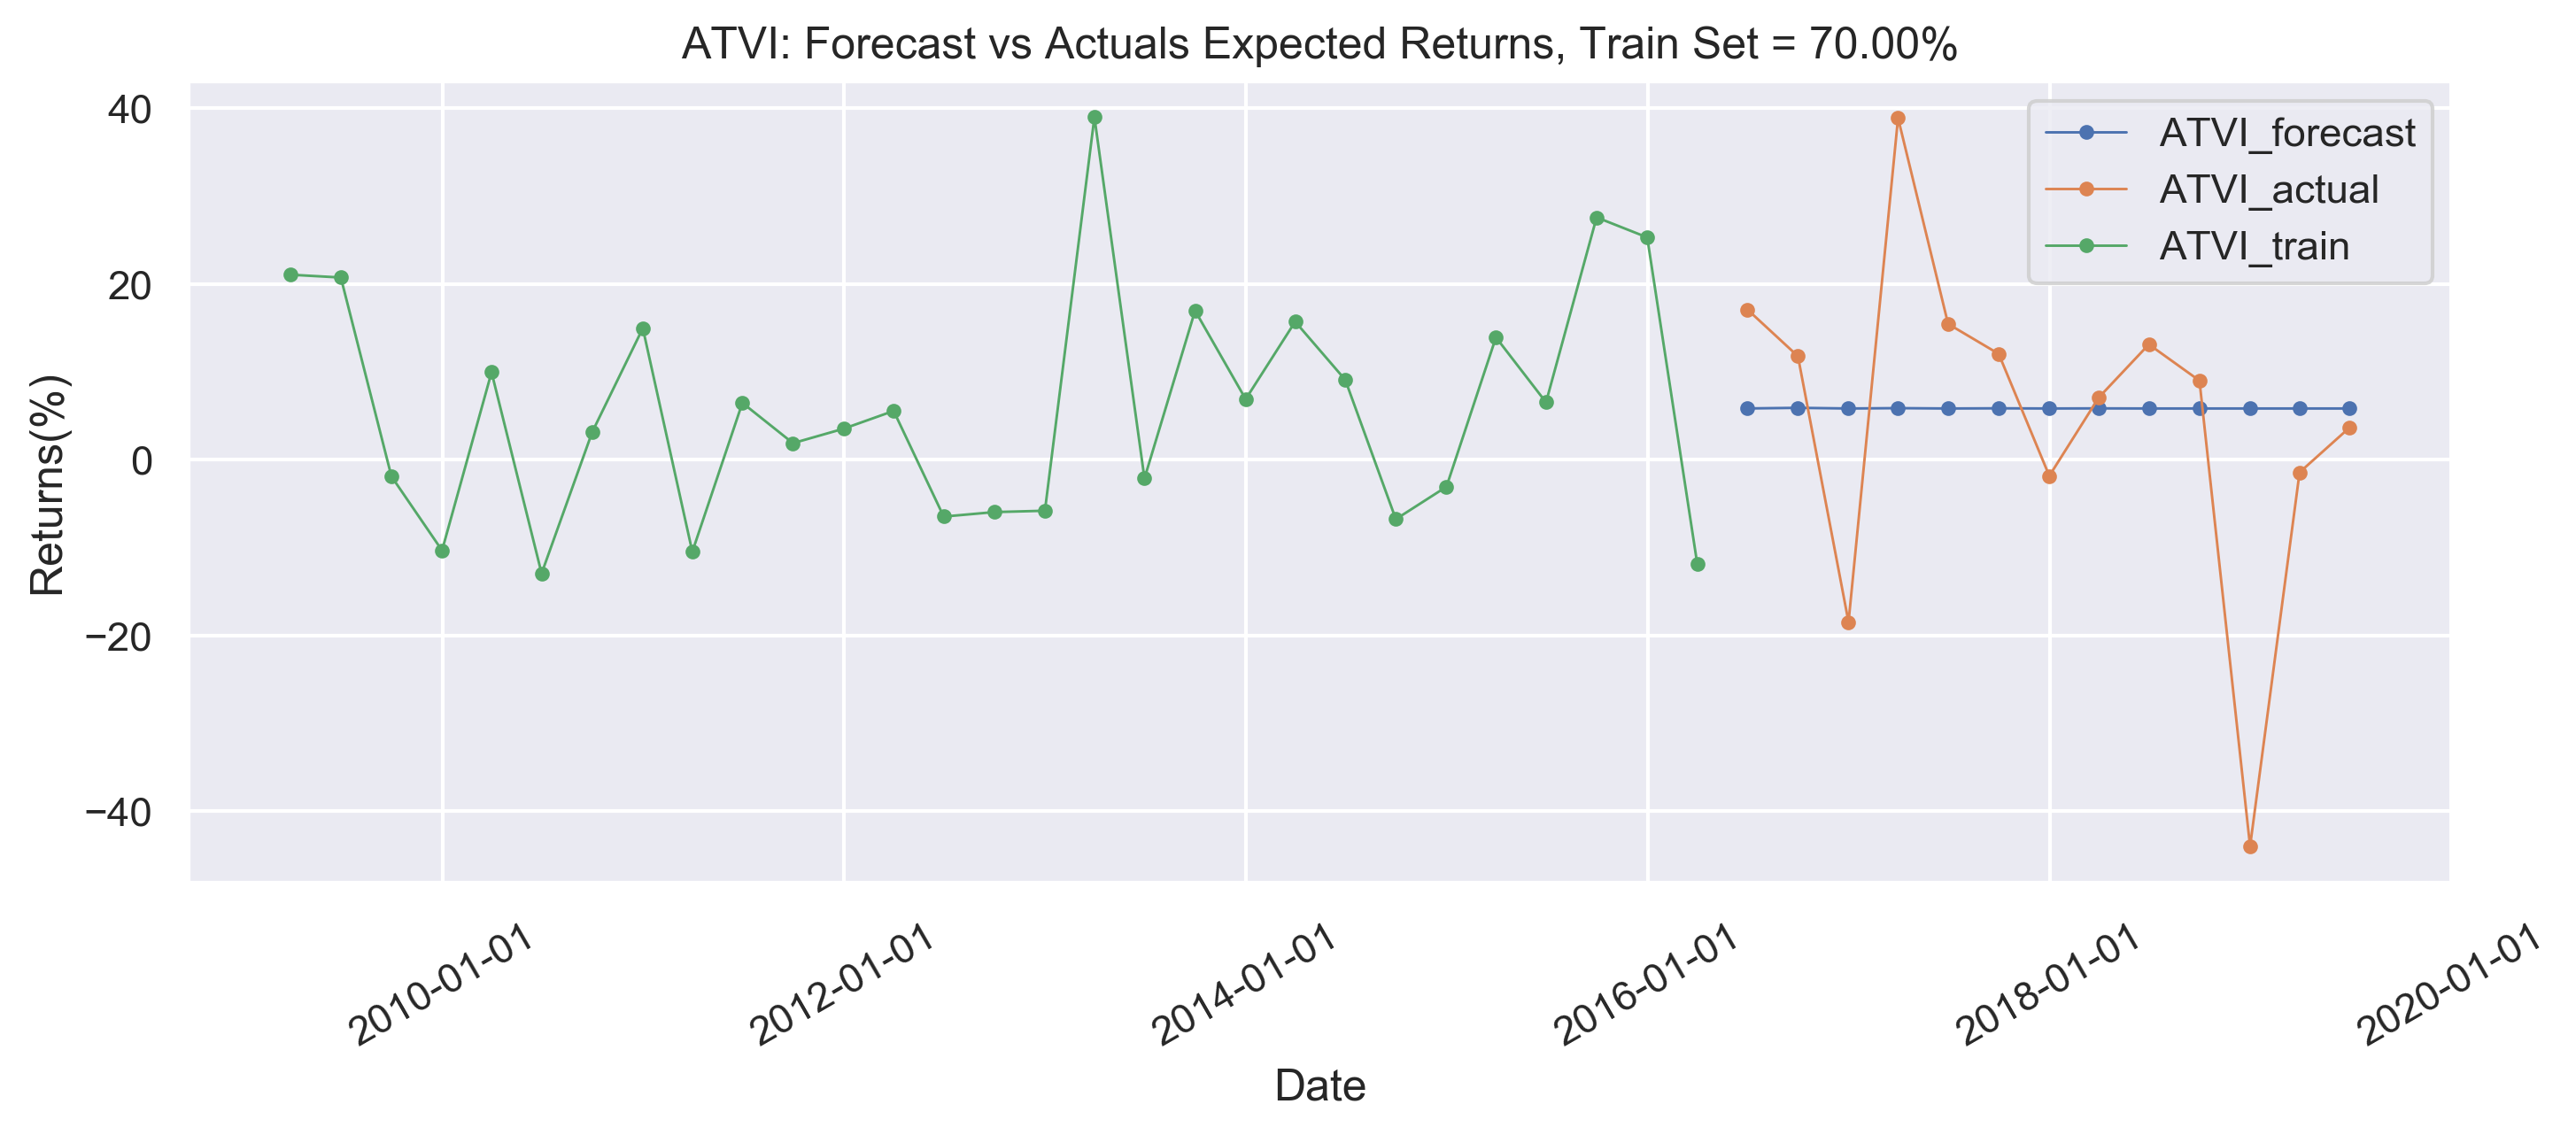

The test size is:  0.05
                            OLS Regression Results                            
Dep. Variable:          ABT US EQUITY   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     2.590
Date:                Tue, 24 Sep 2019   Prob (F-statistic):              0.116
Time:                        10:46:47   Log-Likelihood:                -136.87
No. Observations:                  39   AIC:                             277.7
Df Residuals:                      37   BIC:                             281.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


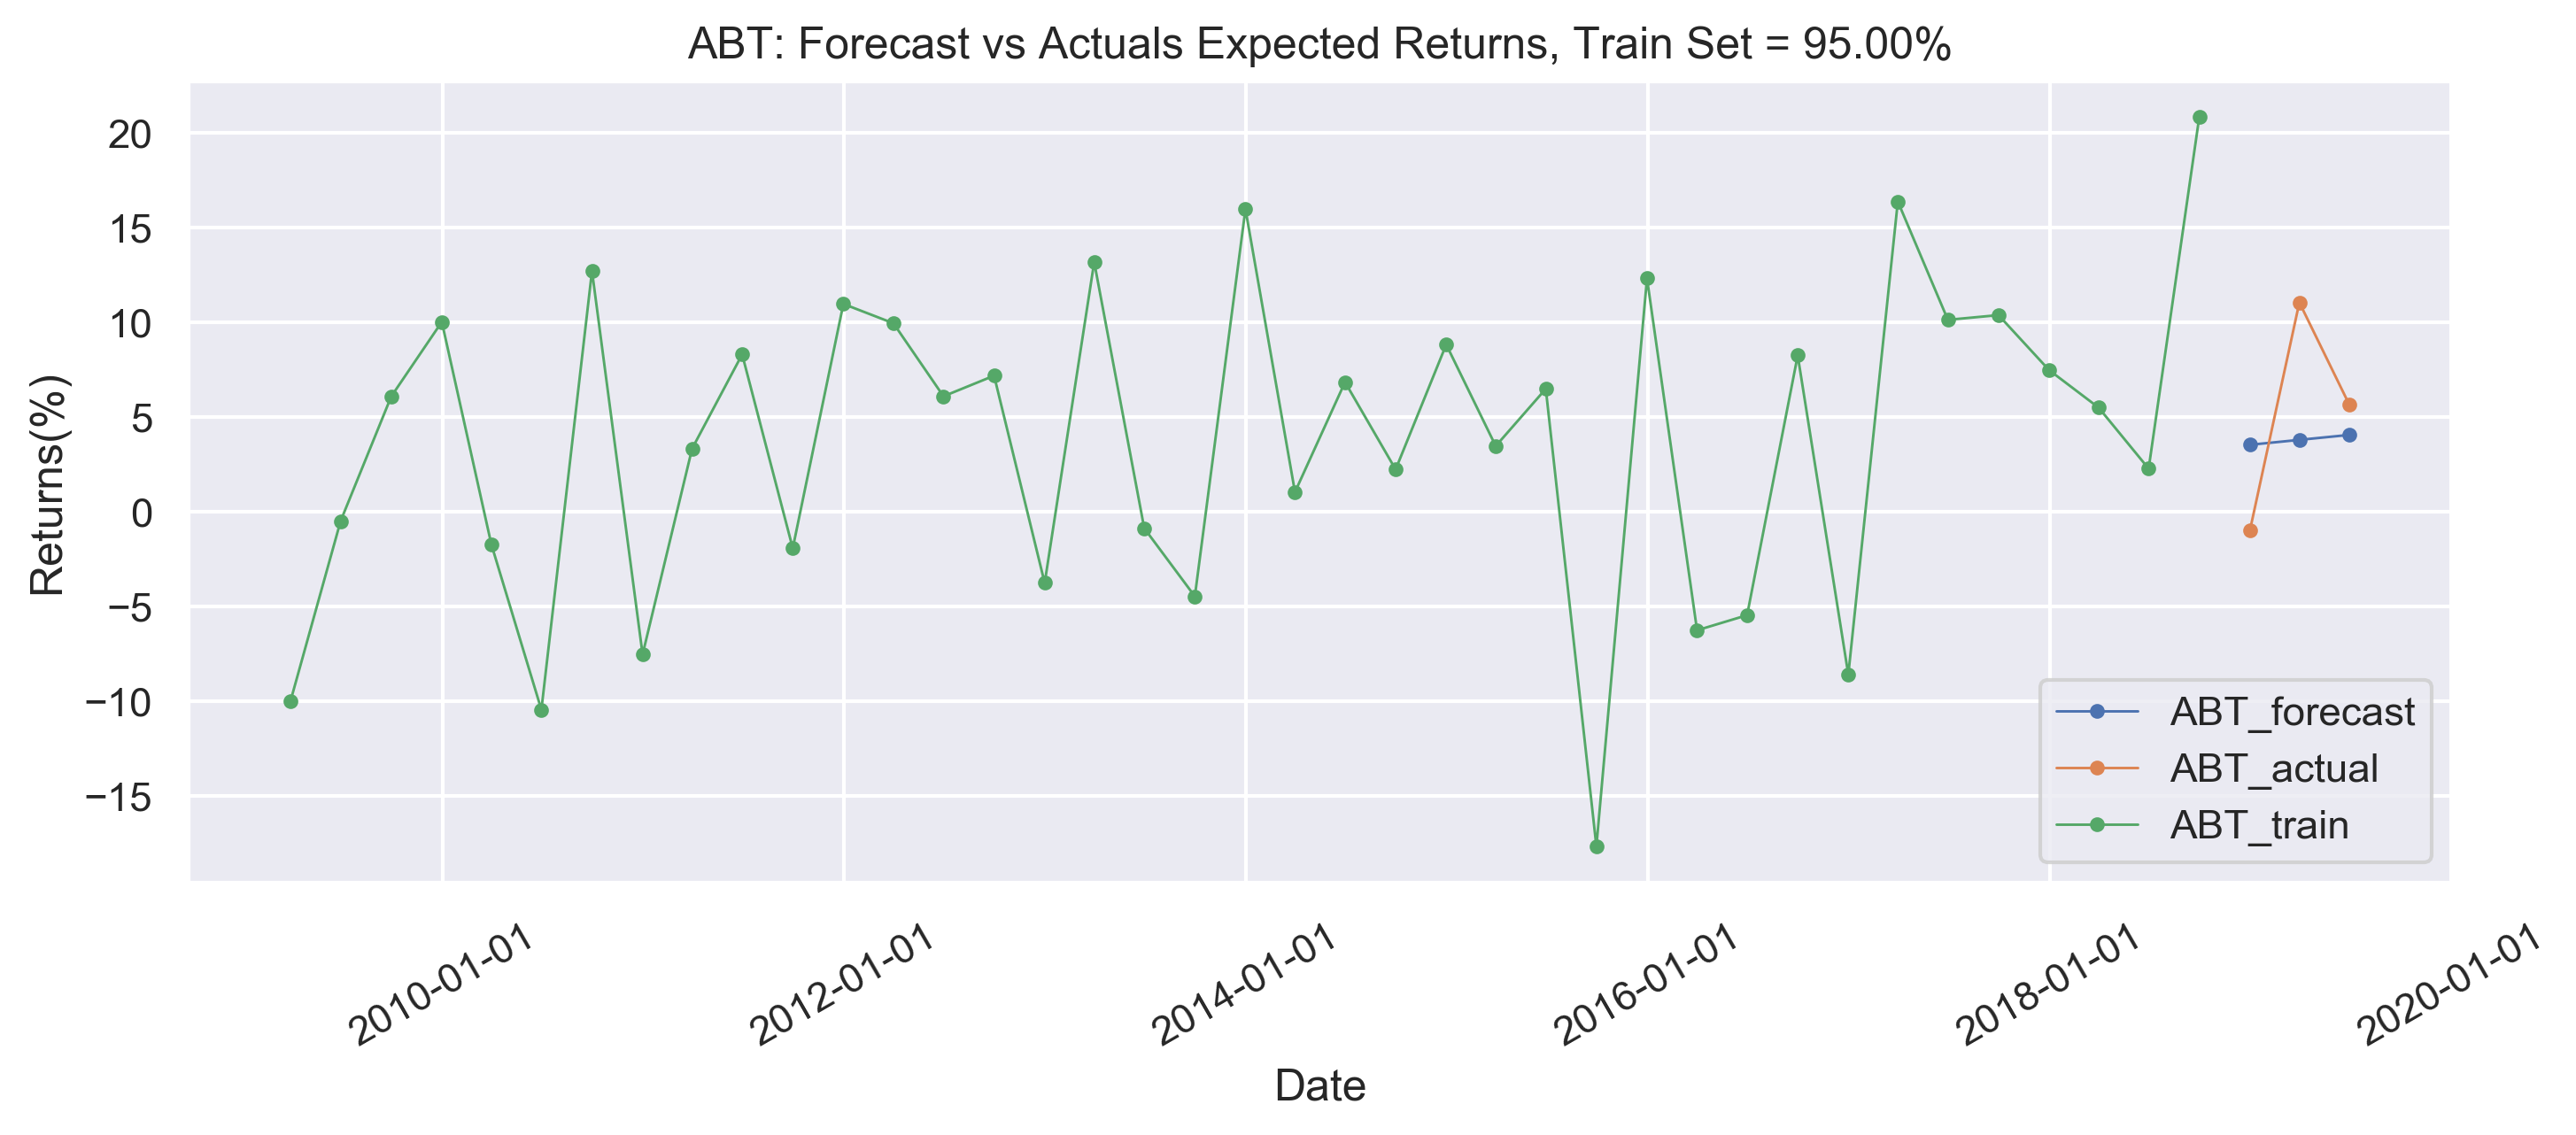

The test size is:  0.3
                            OLS Regression Results                            
Dep. Variable:         BIIB US EQUITY   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     4.027
Date:                Tue, 24 Sep 2019   Prob (F-statistic):             0.0553
Time:                        10:46:48   Log-Likelihood:                -112.76
No. Observations:                  28   AIC:                             229.5
Df Residuals:                      26   BIC:                             232.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


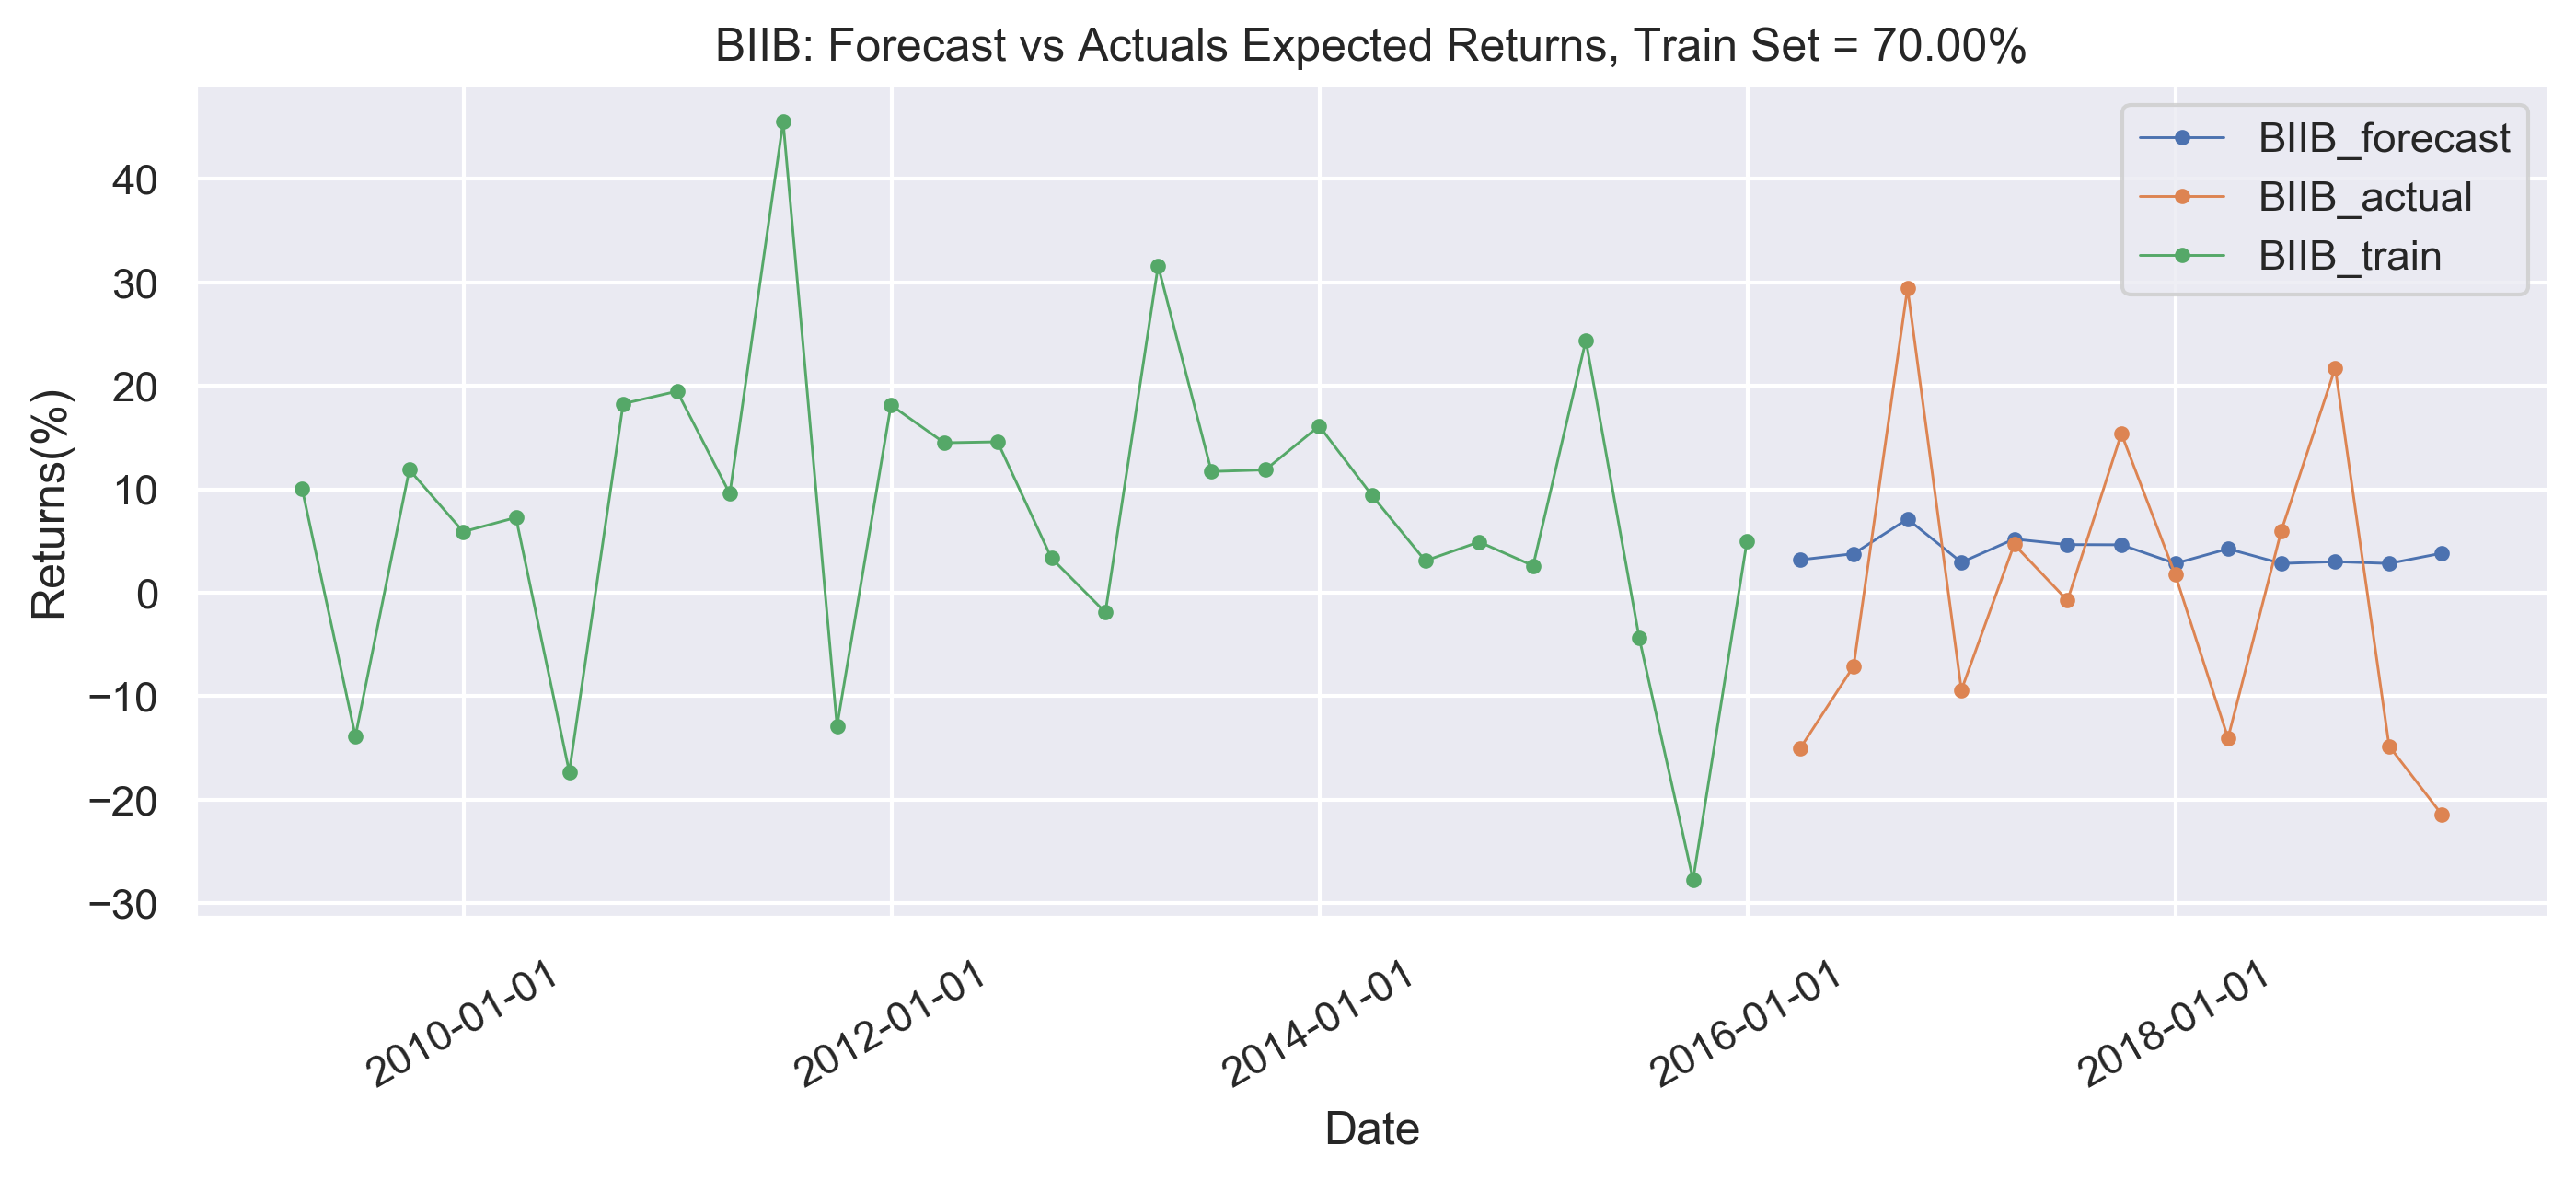

The test size is:  0.3
                            OLS Regression Results                            
Dep. Variable:           EA US Equity   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     2.336
Date:                Tue, 24 Sep 2019   Prob (F-statistic):              0.138
Time:                        10:46:49   Log-Likelihood:                -120.12
No. Observations:                  29   AIC:                             244.2
Df Residuals:                      27   BIC:                             247.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


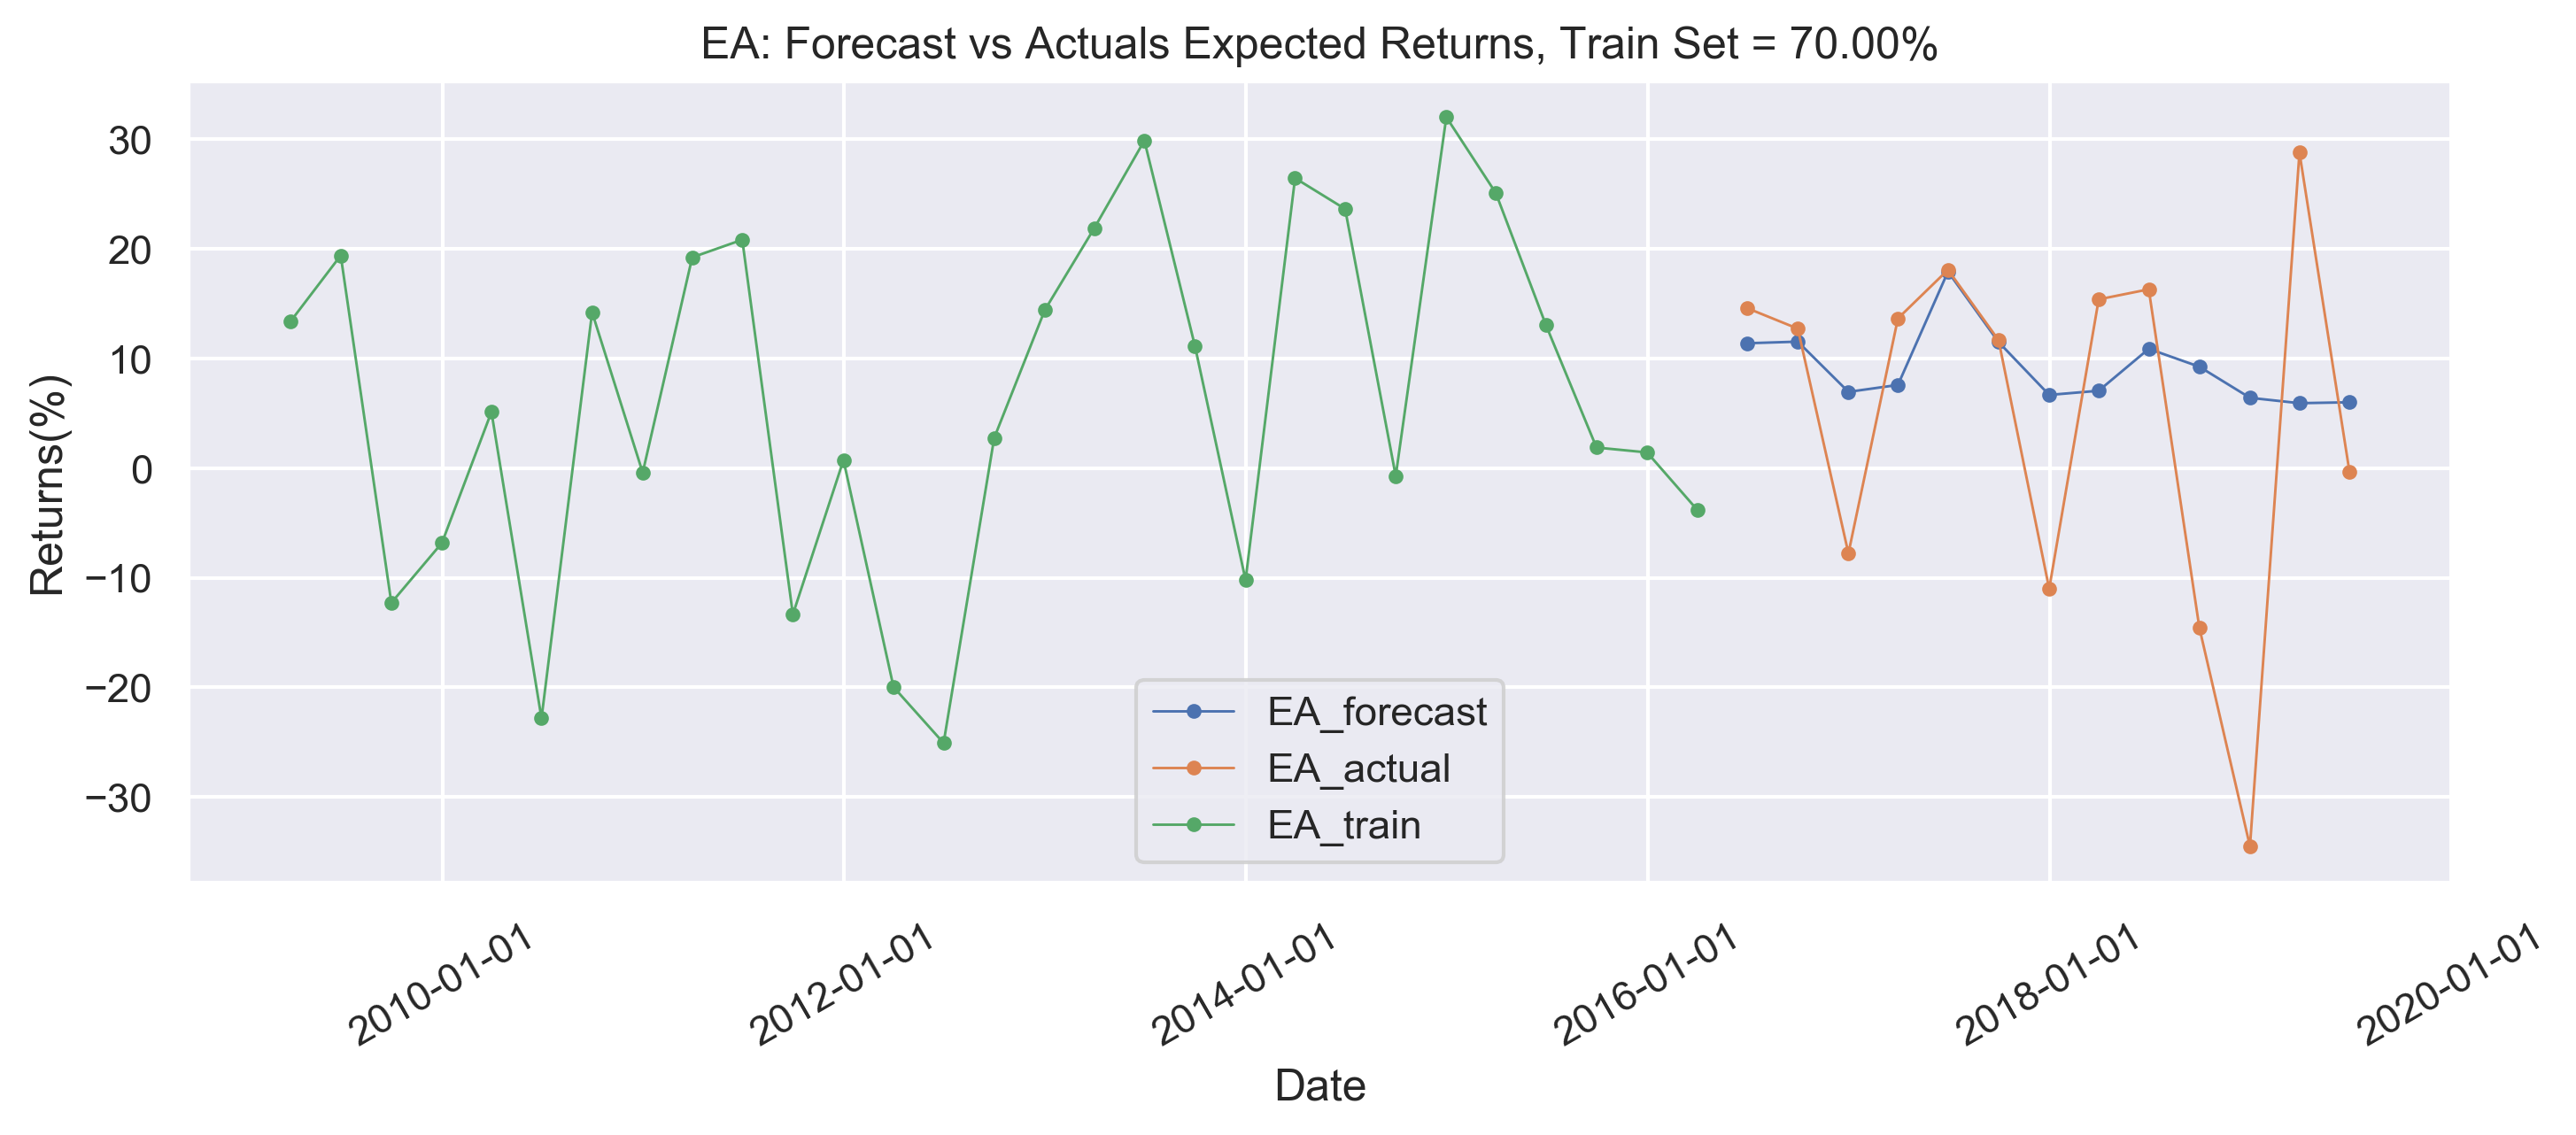

The test size is:  0.3
                            OLS Regression Results                            
Dep. Variable:         TTWO US EQUITY   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.7471
Date:                Tue, 24 Sep 2019   Prob (F-statistic):              0.395
Time:                        10:46:50   Log-Likelihood:                -120.99
No. Observations:                  29   AIC:                             246.0
Df Residuals:                      27   BIC:                             248.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


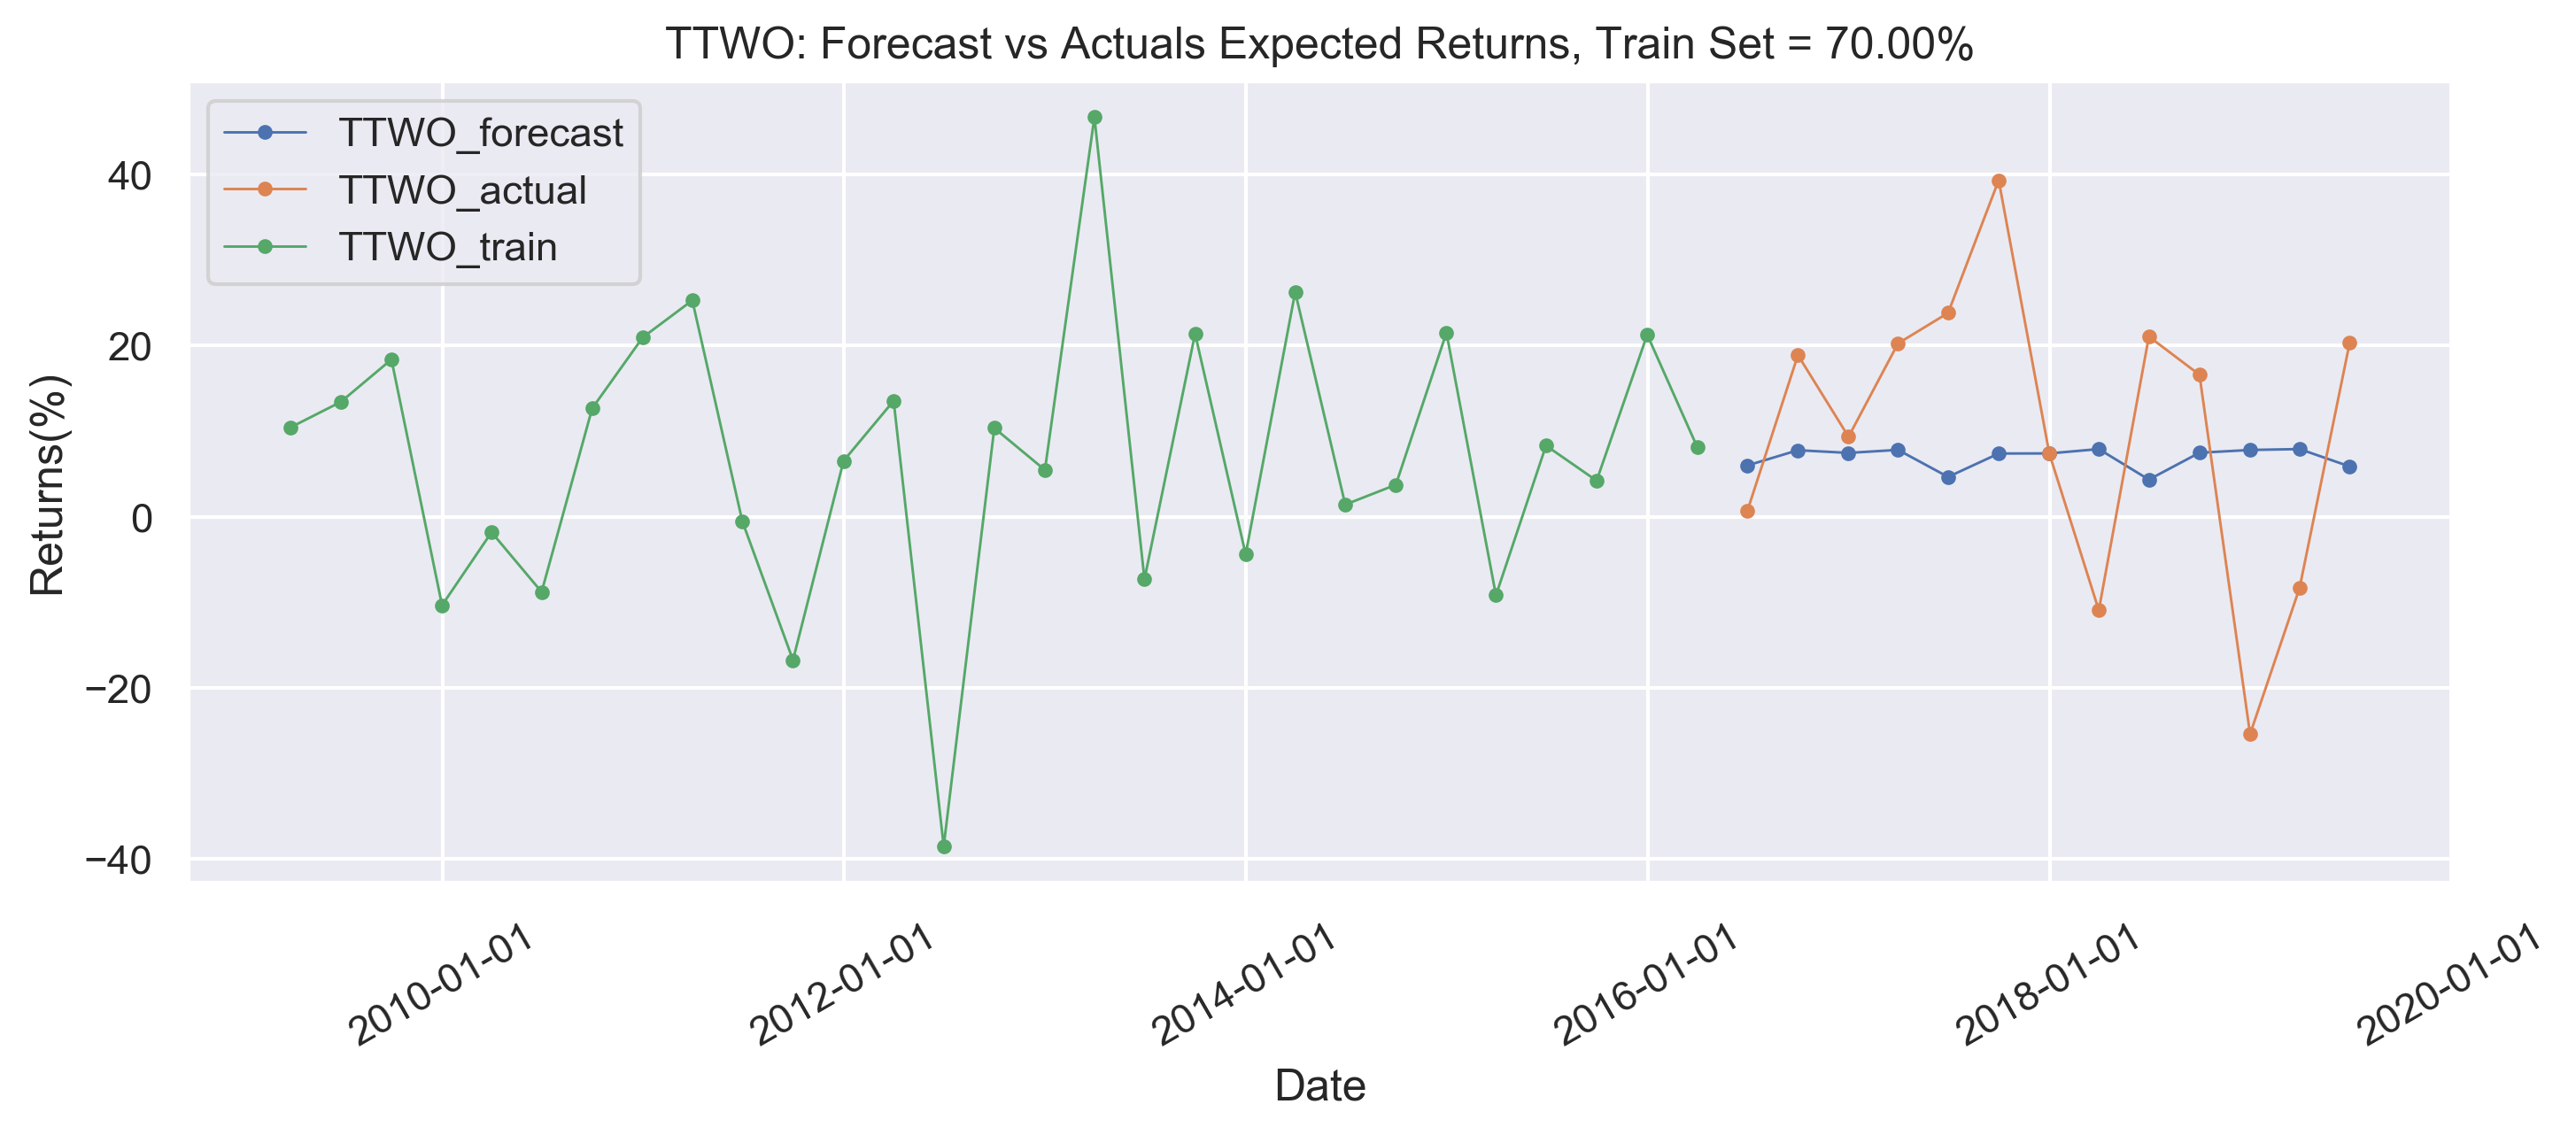

In [22]:
# Forecast and Plot Quarterly Returns
for ticker in ticker_list:
    size_linear_Q = select_size(data_Q,ticker)
    [y_test_Q,y_train_Q,y_pred_Q,test_size_Q,table_Q] = linear_regression(data_Q,ticker,size_linear_Q)
    table_Q = pd.DataFrame(table_Q)
    table_Q = table_Q[table_Q.iloc[:,0]!=0]
    table_Q.to_csv(ticker+"_table_Q_Sale"+".csv")
#     table_Q.to_csv(ticker+"_table_Q.csv")
    forecast_plot(y_test_Q,y_train_Q,y_pred_Q,test_size_Q)